In [174]:
# 데이터 로딩 (자기 파일 위치로 바꿔서 하세요)
import pandas as pd                 # DB 분석 위한 핵심 라이브러리 -> DataFrame, Series 등 DB 구조 제공
import numpy as np                  # 수치 연산 위한 핵심 라이브러리 -> 수치 계산, 배열 연산
import matplotlib.pyplot as plt     # 시각화 위한 핵심 라이브러리 -> 그래프, 차트 그리기
import seaborn as sns               # 시각화 위한 핵심 라이브러리 -> matplolib 기반 고급 통계 시각화 라이브러리
from scipy import stats             # 통계 연산 위한 핵심 라이브러리 -> 통계 분석, 확률 분포 관련 함수들 제공
import warnings                     # 경고 메세지 제어
warnings.filterwarnings('ignore')   # 경고 메세지 무시
df = pd.read_csv(r'C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway21.csv', encoding='cp949')
# 컬럼명 매핑
column_mapping = {
    'train_subway21.tm': 'tm',
    'train_subway21.line': 'line',
    'train_subway21.station_number': 'station_number',
    'train_subway21.station_name': 'station_name',
    'train_subway21.direction': 'direction',
    'train_subway21.stn': 'stn',
    'train_subway21.ta': 'ta',
    'train_subway21.wd': 'wd',
    'train_subway21.ws': 'ws',
    'train_subway21.rn_day': 'rn_day',
    'train_subway21.rn_hr1': 'rn_hr1',
    'train_subway21.hm': 'hm',
    'train_subway21.si': 'si',
    'train_subway21.ta_chi': 'ta_chi',
    'train_subway21.congestion': 'congestion'
}
df = df.rename(columns=column_mapping)

print("=== 🔍 초기 데이터 확인 ===")
print(f"📊 데이터 shape: {df.shape}")       # dataframe의 크기(행, 열 수) 출력 -> f-string 사용하여 변수 값을 문자열에 삽입
print(f"📋 컬럼명: {df.columns.tolist()}")  # dataframe의 컬럼명 리스트 형태로 출력

# dataframe의 전체적인 정보 출력 (각 컬럼의 데이터 타입, 결측치 개수, 메모리 사용량 등)
print("\n📈 기본 정보:")
df.info()

# 데이터의 상위 5행 섹션 제목 출력
print("\n📄 상위 5행:")
print(df.head())

# 결측치 처리 (-99를 NaN으로 변환)
print("\n🚨 결측치 처리 중...")
weather_cols = ['rn_day', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi','ta','wd']
for col in weather_cols:
    before_count = (df[col] == -99).sum()
    df[col] = df[col].replace(-99, np.nan)
    print(f"{col}: -99 값 {before_count:,}개를 NaN으로 변환")
df['wd'] = df['wd'].replace(-9.9, np.nan)

# 결측치 비율 분석
print("\n📊 결측치 비율 분석:")
total_records = len(df)
for col in weather_cols:
    missing_count = df[col].isnull().sum()
    missing_rate = (missing_count / total_records) * 100
    print(f"{col}: {missing_count:,}개 ({missing_rate:.2f}%)")

print(f"\n전체 데이터: {total_records:,}개")
print(f"모든 기후변수가 완전한 행: {len(df[weather_cols].dropna()):,}개 ({len(df[weather_cols].dropna())/total_records*100:.2f}%)")

# 시간 변수 추출
## 현재 tm 컬럼은 년월일시간이 합쳐진 상태임. -> 시간대별 분석이 필요하기 때문에 시간 변수 추출
df['m_hr1'] = df['tm'] % 100

print(f"\n⏰ 시간 변수 추출 확인:")
print(f"tm 샘플: {df['tm'].head().tolist()}")
print(f"추출된 시간 범위: {df['m_hr1'].min()} ~ {df['m_hr1'].max()}")
print(df['m_hr1'].value_counts().sort_index())
print(f"시간 분포 (상위 10개):")
print(df['m_hr1'].value_counts().sort_index().head(10))

# 일사량 야간시간대 물리적 처리
print("\n🌙 일사량 야간시간대 처리 중...")
night_hours = [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]
night_mask = df['m_hr1'].isin(night_hours)
night_si_missing = df.loc[night_mask, 'si'].isnull().sum()
df.loc[night_mask, 'si'] = 0.0
print(f"야간시간대({night_hours}) 일사량 결측값 {night_si_missing:,}개를 0으로 설정")

# 동시 결측 패턴 확인
print("\n🔍 동시 결측 패턴 확인:")
basic_weather = ['rn_day', 'ws', 'rn_hr1', 'hm']
df['missing_count'] = df[basic_weather].isnull().sum(axis=1)
df['multiple_missing'] = df['missing_count'] >= 2
print(f"2개 이상 동시 결측: {df['multiple_missing'].sum():,}개 ({df['multiple_missing'].sum()/len(df)*100:.2f}%)")

# 변수들 대한 기술통계(평균, 표준편차, 최솟값, 최댓값 등)
print("\n📊 기본 통계:")
print(df[weather_cols + ['congestion', 'm_hr1']].describe())

# 혼잡도 관련 범위, 평균, 결측치 확인
print("\n🎯 타겟 변수 확인:")
target_col = 'congestion'
print(f"혼잡도 범위: {df[target_col].min():.2f} ~ {df[target_col].max():.2f}")
print(f"혼잡도 평균: {df[target_col].mean():.2f}")
print(f"혼잡도 결측치: {df[target_col].isnull().sum()}개")

# 날씨 변수 관련 범위 및 결측치 수
print("\n🌡️ 날씨 변수 확인:")
for col in weather_cols:
    non_null_data = df[col].dropna()
    if len(non_null_data) > 0:
        print(f"{col}: {non_null_data.min():.2f} ~ {non_null_data.max():.2f} (결측치: {df[col].isnull().sum():,}개)")
    else:
        print(f"{col}: 모든 값이 결측치")

print(f"\n📊 최종 데이터 현황:")
print(f"전체 행 수: {len(df):,}")
print(f"결측치가 없는 완전한 행 수: {len(df.dropna()):,}")

=== 🔍 초기 데이터 확인 ===
📊 데이터 shape: (5452143, 16)
📋 컬럼명: ['Unnamed: 0', 'tm', 'line', 'station_number', 'station_name', 'direction', 'stn', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi', 'congestion']

📈 기본 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452143 entries, 0 to 5452142
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   tm              int64  
 2   line            int64  
 3   station_number  int64  
 4   station_name    object 
 5   direction       object 
 6   stn             int64  
 7   ta              float64
 8   wd              float64
 9   ws              float64
 10  rn_day          float64
 11  rn_hr1          float64
 12  hm              float64
 13  si              float64
 14  ta_chi          float64
 15  congestion      int64  
dtypes: float64(8), int64(6), object(2)
memory usage: 665.5+ MB

📄 상위 5행:
   Unnamed: 0          tm  line  station_number station_name direction

In [175]:
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'
print(min(df['wd']))

0.0


In [107]:
# 임시 파일 생성
df = pd.read_csv(r"C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway23.csv", encoding='cp949')


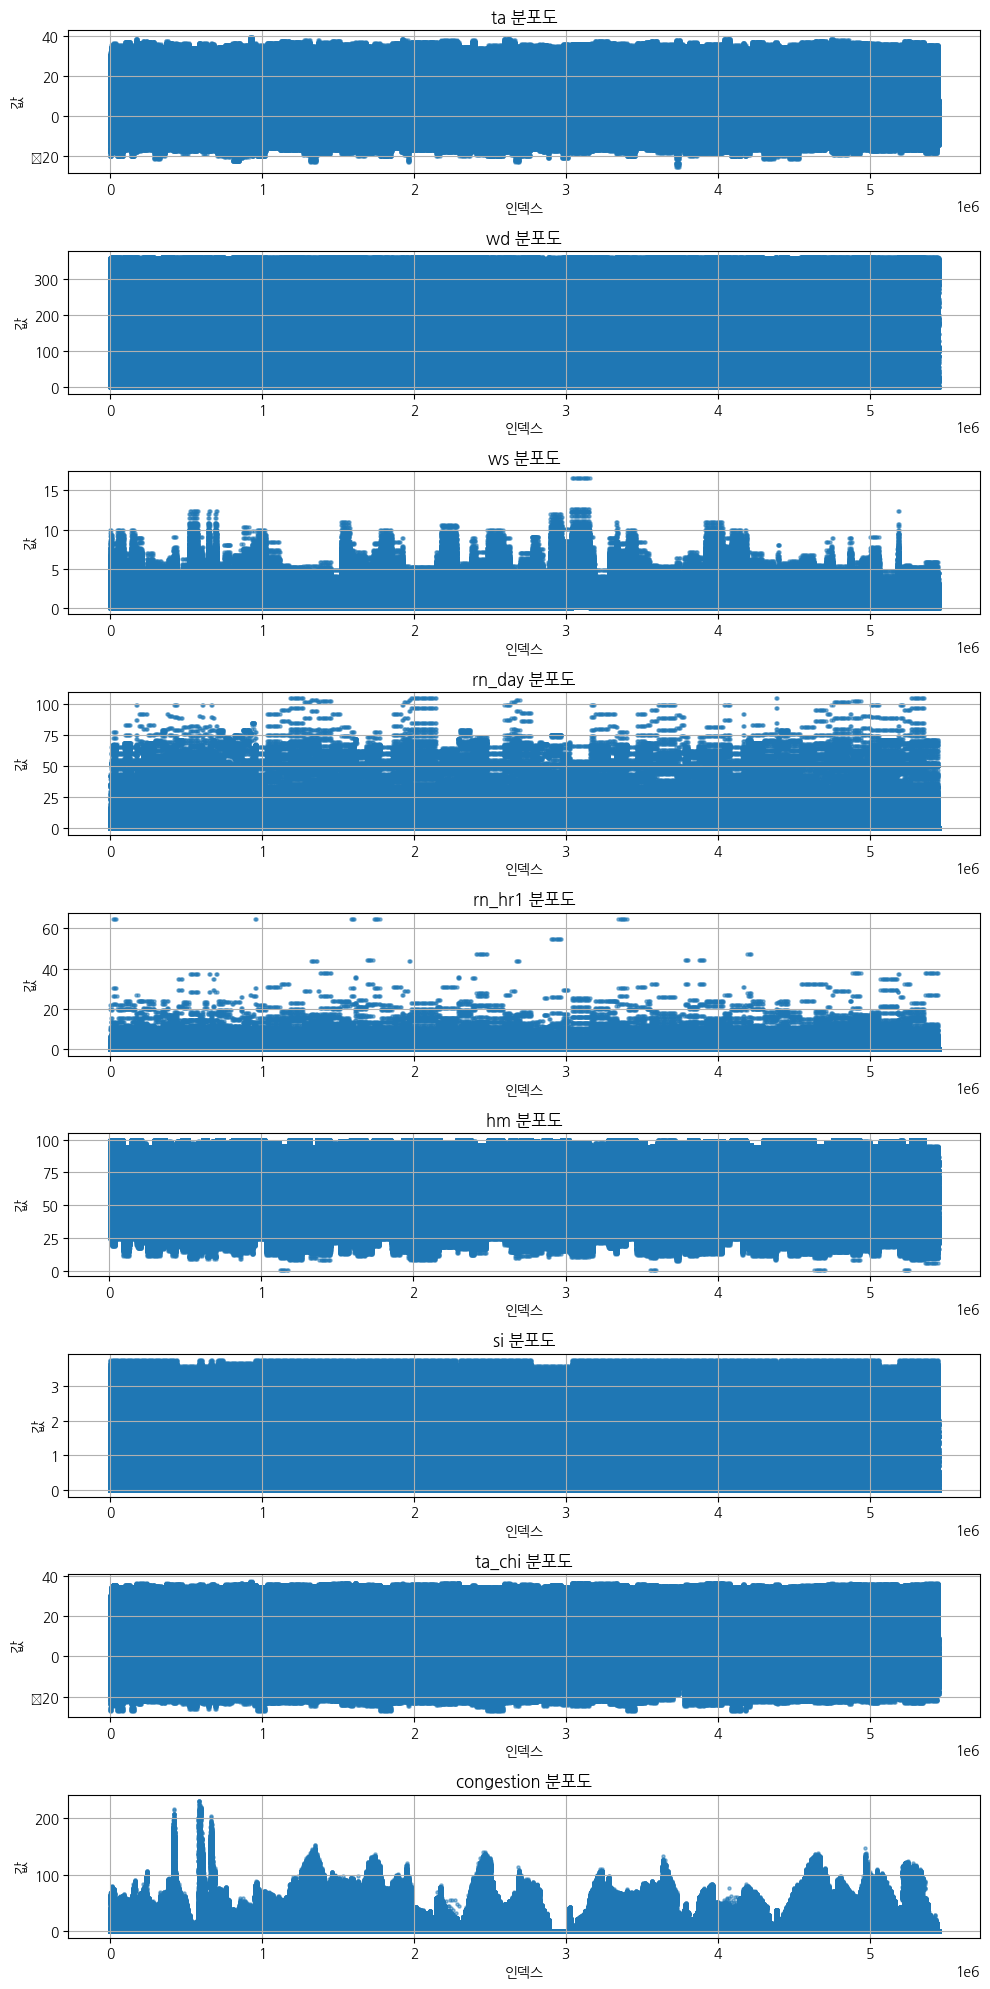

In [114]:
#결측치 확인용 코드 (이상없음)
import missingno as msno
import matplotlib.pyplot as plt
# 상대습도, 일사량, 강수량, 혼잡도 변수들의 박스플롯 시각화
columns_to_check = ['ta','wd','ws','rn_day','rn_hr1',
                    'hm','si', 'ta_chi','congestion',]
# 분포도 (산점도) 개별 출력
plt.figure(figsize=(10, 20))

for i, col in enumerate(columns_to_check):
    plt.subplot(len(columns_to_check), 1, i+1)
    plt.scatter(df.index, df[col], s=5, alpha=0.5)
    plt.title(f'{col} 분포도')
    plt.ylabel('값')
    plt.xlabel('인덱스')
    plt.grid(True)

plt.tight_layout()
plt.show()

[강남 - 여름] H1 - 기온 vs 혼잡도 상관계수: r = nan, p = nan
[강남 - 여름] H2 - 강수 vs 무강수 혼잡도 차이: t = 1.198, p = 0.2317


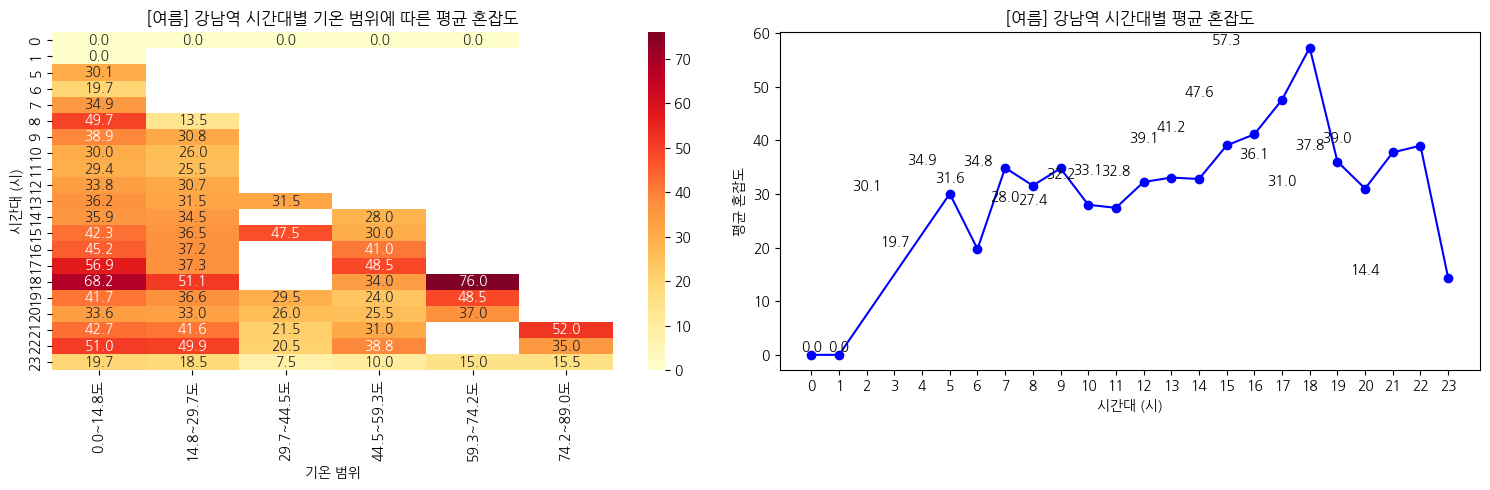

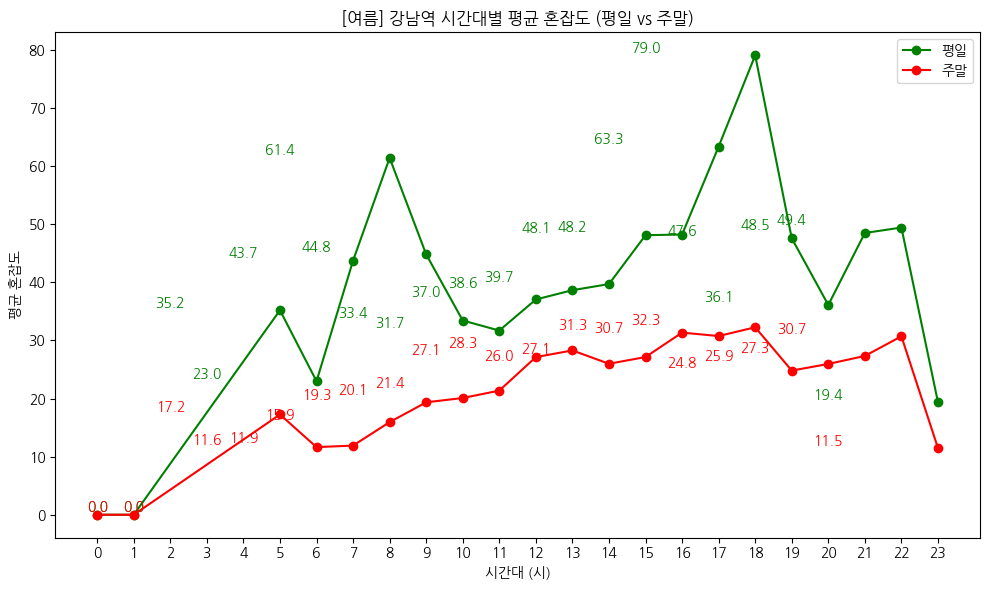

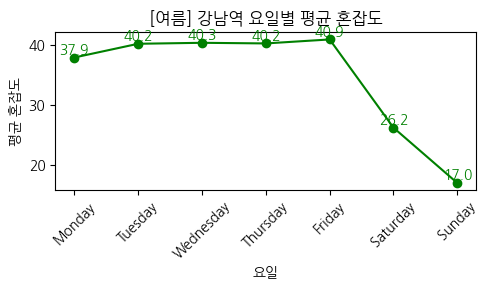

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'


# ✅ datetime 변환 및 시간 정보 추출
df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
df['m_hr1'] = df['datetime'].dt.hour #시간
df['month'] = df['datetime'].dt.month #달
df['dayofweek'] = df['datetime'].dt.dayofweek  # 요일 0 = 월요일, 6 = 일요일

# ✅ 2. 여름(6~8월) + 특정 역 필터링
selected_station = '강남'  # <- 원하는 역으로 바꾸면 됨
df_summer = df[(df['month'].isin([6,7,8])) & (df['station_name'] == selected_station)].copy() # 원하는 계절절

# ✅ 3. 기온 구간 설정 (min-max 기반 6등분)
ta_min = df_summer['rn_day'].min() # 여기다가 기상변수 넣기 지금은 강수량으로 되어있음음
ta_max = df_summer['rn_day'].max()
bins = np.linspace(ta_min, ta_max, 7) # 구간 설정정
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}도' for i in range(len(bins)-1)]
df_summer['temp_range'] = pd.cut(df_summer['rn_day'], bins=bins, labels=labels, include_lowest=True)

# ✅ 4. H1 - 기온 vs 혼잡도 상관계수
corr1, pval1 = pearsonr(df_summer['rn_day'], df_summer['congestion'])
print(f"[{selected_station} - 여름] H1 - 기온 vs 혼잡도 상관계수: r = {corr1:.3f}, p = {pval1:.4f}")

# ✅ 5. H2 - 강수 vs 무강수 혼잡도 차이
rain = df_summer[df_summer['rn_hr1'] > 0]['congestion']
no_rain = df_summer[df_summer['rn_hr1'] == 0]['congestion']
t_stat, t_pval = ttest_ind(rain, no_rain, equal_var=False)
print(f"[{selected_station} - 여름] H2 - 강수 vs 무강수 혼잡도 차이: t = {t_stat:.3f}, p = {t_pval:.4f}")

# ✅ 6. H3 - 시간대별 기온구간 vs 혼잡도 히트맵
pivot = df_summer.pivot_table(index='m_hr1', columns='temp_range', values='congestion', aggfunc='mean')

# 시간대별 혼잡도 히트맵
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt=".1f")
plt.title(f'[여름] {selected_station}역 시간대별 기온 범위에 따른 평균 혼잡도')
plt.xlabel('기온 범위')
plt.ylabel('시간대 (시)')

# 시간대별 혼잡도 그래프
plt.subplot(1, 2, 2)
pivot_mean = pivot.mean(axis=1)
pivot_mean.plot(kind='line', marker='o', color='b')
plt.title(f'[여름] {selected_station}역 시간대별 평균 혼잡도')
plt.xlabel('시간대 (시)')
plt.ylabel('평균 혼잡도')
plt.xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

# 각 점에 숫자 추가 (위쪽에 숫자 배치)
for x, y in zip(np.arange(0, 24, 1), pivot_mean):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom')  # 숫자를 위쪽으로 배치

plt.tight_layout()
plt.show()

# ✅ 7. 평일과 주말을 하나의 plot에 표시
df_summer['weekday'] = df_summer['dayofweek'].apply(lambda x: '평일' if x < 5 else '주말')
pivot_weekday = df_summer[df_summer['weekday'] == '평일'].pivot_table(index='m_hr1', columns='temp_range', values='congestion', aggfunc='mean')
pivot_weekend = df_summer[df_summer['weekday'] == '주말'].pivot_table(index='m_hr1', columns='temp_range', values='congestion', aggfunc='mean')

# 평일과 주말을 하나의 plot에 그리기
plt.figure(figsize=(10, 6))
pivot_weekday_mean = pivot_weekday.mean(axis=1)
pivot_weekend_mean = pivot_weekend.mean(axis=1)

# 평일과 주말 그래프 그리기
plt.plot(pivot_weekday_mean, marker='o', label='평일', color='g')
plt.plot(pivot_weekend_mean, marker='o', label='주말', color='r')
plt.title(f'[여름] {selected_station}역 시간대별 평균 혼잡도 (평일 vs 주말)')
plt.xlabel('시간대 (시)')
plt.ylabel('평균 혼잡도')
plt.xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정
plt.legend()

# 각 점에 숫자 추가 (평일, 주말)
for x, y in zip(np.arange(0, 24, 1), pivot_weekday_mean):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom', color='g')

for x, y in zip(np.arange(0, 24, 1), pivot_weekend_mean):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom', color='r')

plt.tight_layout()
plt.show()

# ✅ 8. 요일별 평균 혼잡도 (평일+주말)
# 요일 순서 고정 (월~일)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_summer['day_name'] = df_summer['datetime'].dt.strftime('%A')

# 요일을 월~일 순서대로 정렬
df_summer['day_name'] = pd.Categorical(df_summer['day_name'], categories=day_order, ordered=True)

# 요일별 평균 혼잡도 계산
daily_avg_congestion = df_summer.groupby('day_name')['congestion'].mean()


# 요일별 혼잡도 그래프
plt.figure(figsize=(5, 3))
daily_avg_congestion.plot(kind='line', marker='o', color='g')
plt.title(f'[여름] {selected_station}역 요일별 평균 혼잡도')
plt.xlabel('요일')
plt.ylabel('평균 혼잡도')
plt.xticks(rotation=45)

# 각 점에 숫자 추가 (요일별 평균 혼잡도)
for x, y in zip(np.arange(len(daily_avg_congestion)), daily_avg_congestion):
    plt.text(x, y + 0.1, f'{y:.1f}', ha='center', va='bottom', color='g')

plt.tight_layout()
plt.show()

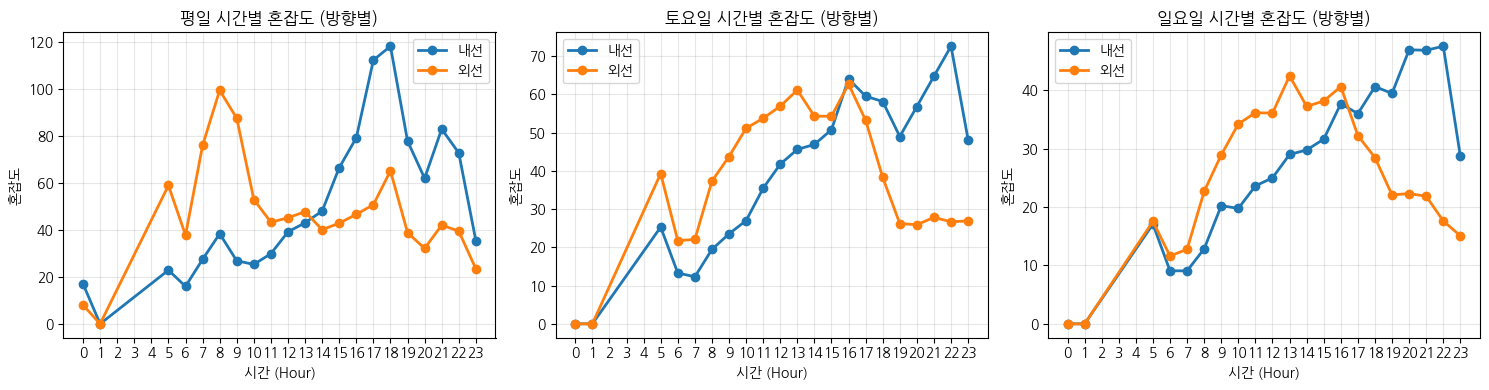

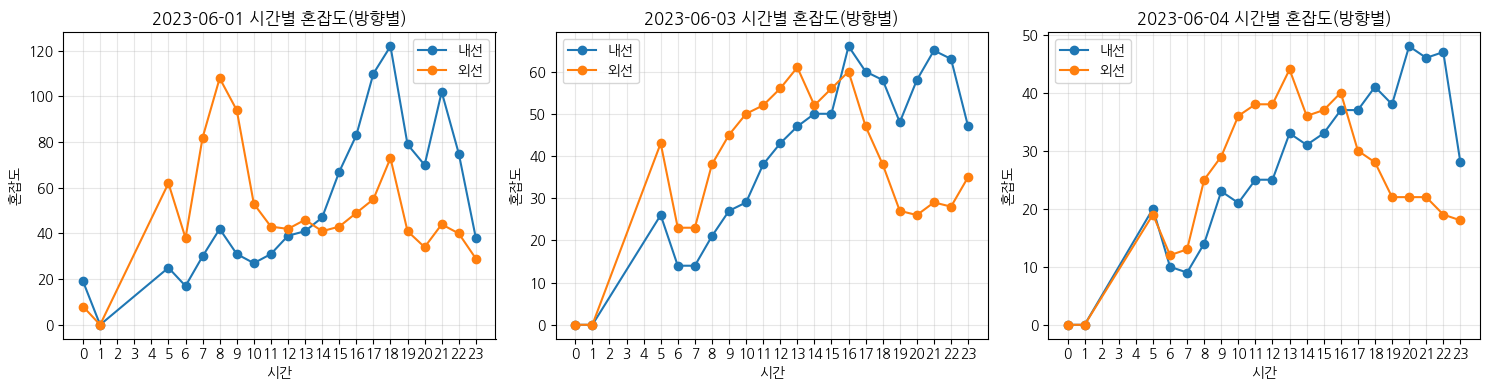


=== 요일별 방향별 평균 혼잡도 ===

평일:
  내선 평균 혼잡도: 49.53
  외선 평균 혼잡도: 46.53

토요일:
  내선 평균 혼잡도: 38.79
  외선 평균 혼잡도: 37.32

일요일:
  내선 평균 혼잡도: 26.23
  외선 평균 혼잡도: 24.67


In [85]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# 데이터 로드
result_df = pd.read_csv('../../pred_result_hour_only.csv', encoding='utf-8-sig')
result_df['datetime'] = pd.to_datetime(result_df['train_subway21.tm'], format='%Y%m%d%H%M')
result_df['date'] = result_df['datetime'].dt.date
result_df['hour'] = result_df['datetime'].dt.hour
result_df['dayofweek'] = result_df['datetime'].dt.dayofweek  # 0: 월요일, 6: 일요일

# 평일, 토요일, 일요일 시간별 혼잡도 시각화 (방향별) - Subplot으로 합치기
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. 평일 시간별 혼잡도 (월~금)
weekday_df = result_df[result_df['dayofweek'].isin([0,1,2,3,4])]
for direction in ['내선', '외선']:
    direction_data = weekday_df[weekday_df['direction'] == direction]
    hourly_mean = direction_data.groupby('hour')['congestion1'].mean()
    axes[0].plot(hourly_mean.index, hourly_mean.values, marker='o', label=f'{direction}', linewidth=2)

axes[0].set_xlabel('시간 (Hour)')
axes[0].set_ylabel('혼잡도')
axes[0].set_title('평일 시간별 혼잡도 (방향별)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

# 2. 토요일 시간별 혼잡도
saturday_df = result_df[result_df['dayofweek'].isin([5])]
for direction in ['내선', '외선']:
    direction_data = saturday_df[saturday_df['direction'] == direction]
    hourly_mean = direction_data.groupby('hour')['congestion1'].mean()
    axes[1].plot(hourly_mean.index, hourly_mean.values, marker='o', label=f'{direction}', linewidth=2)

axes[1].set_xlabel('시간 (Hour)')
axes[1].set_ylabel('혼잡도')
axes[1].set_title('토요일 시간별 혼잡도 (방향별)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

# 3. 일요일 시간별 혼잡도
sunday_df = result_df[result_df['dayofweek'].isin([6])]
for direction in ['내선', '외선']:
    direction_data = sunday_df[sunday_df['direction'] == direction]
    hourly_mean = direction_data.groupby('hour')['congestion1'].mean()
    axes[2].plot(hourly_mean.index, hourly_mean.values, marker='o', label=f'{direction}', linewidth=2)

axes[2].set_xlabel('시간 (Hour)')
axes[2].set_ylabel('혼잡도')
axes[2].set_title('일요일 시간별 혼잡도 (방향별)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

plt.tight_layout()
plt.show()


# 2. 하루씩 시간별 혼잡도 비교 (방향별)
''' 전체 다 보기기
unique_dates = result_df['date'].unique()
for d in unique_dates:
    day_df = result_df[result_df['date'] == d]
    plt.figure(figsize=(10, 4))
    for direction in day_df['direction'].unique():
        dir_df = day_df[day_df['direction'] == direction]
        hourly_mean = dir_df.groupby('hour')['congestion1'].mean()
        plt.plot(hourly_mean.index, hourly_mean.values, label=f'{direction}', marker='o')
    plt.title(f'{d} 시간별 혼잡도(방향별)')
    plt.xlabel('시간')
    plt.ylabel('혼잡도')
    plt.legend()
    plt.tight_layout()
    plt.show()
'''
# 특정 날짜만 선택 (2023-06-01, 2023-06-03, 2023-06-04)
selected_dates = [datetime(2023, 6, 1).date(), datetime(2023, 6, 3).date(), datetime(2023, 6, 4).date()]

# 날짜별 시간별 혼잡도 시각화 - Subplot으로 합치기
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, d in enumerate(selected_dates):
    day_df = result_df[result_df['date'] == d]
    
    for direction in day_df['direction'].unique():
        dir_df = day_df[day_df['direction'] == direction]
        hourly_mean = dir_df.groupby('hour')['congestion1'].mean()
        axes[i].plot(hourly_mean.index, hourly_mean.values, label=f'{direction}', marker='o')
    
    axes[i].set_title(f'{d} 시간별 혼잡도(방향별)')
    axes[i].set_xlabel('시간')
    axes[i].set_ylabel('혼잡도')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(np.arange(0, 24, 1))  # x축을 1시간 단위로 설정

plt.tight_layout()
plt.show()

# 방향별 평균 혼잡도 출력
print("\n=== 요일별 방향별 평균 혼잡도 ===")
for day_name, day_numbers in [("평일", [0,1,2,3,4]), ("토요일", [5]), ("일요일", [6])]:
    day_df = result_df[result_df['dayofweek'].isin(day_numbers)]
    print(f"\n{day_name}:")
    for direction in ['내선', '외선']:
        direction_mean = day_df[day_df['direction'] == direction]['congestion1'].mean()
        print(f"  {direction} 평균 혼잡도: {direction_mean:.2f}") 



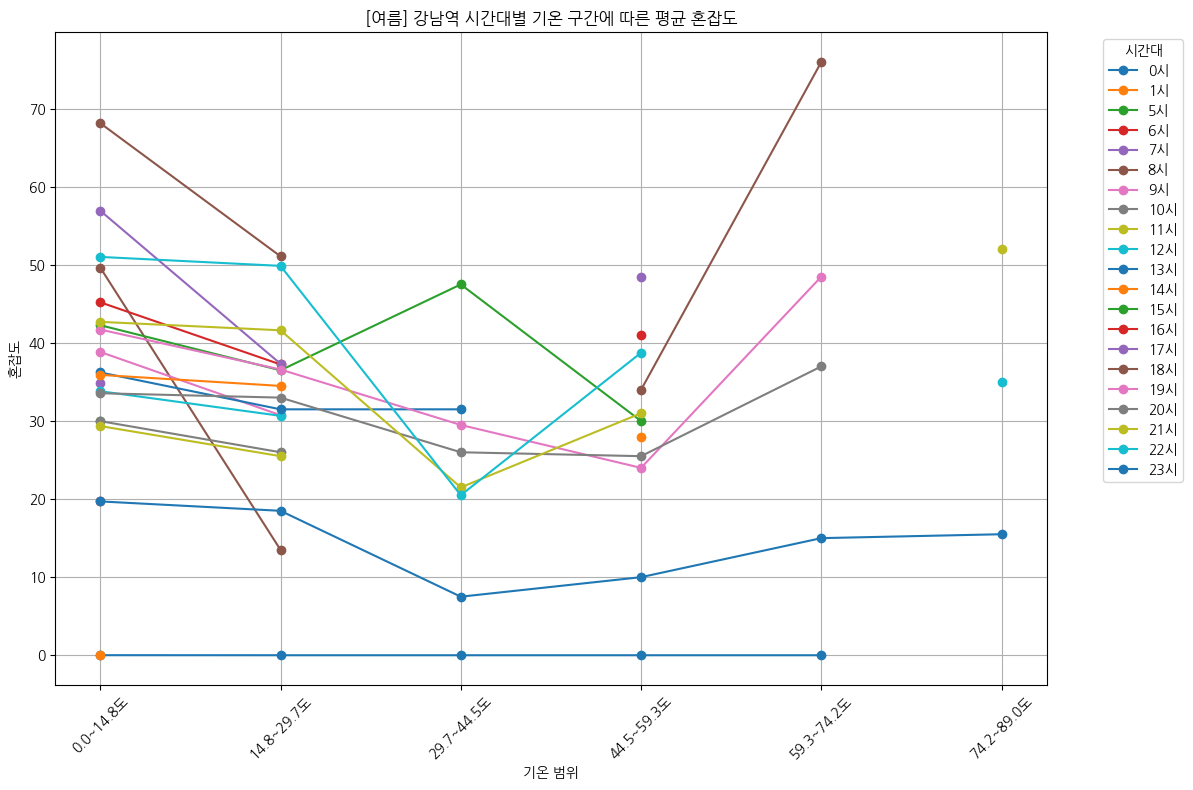

In [55]:
# ✅ 7. 시간대별 기온구간 vs 혼잡도 선그래프 #여기서 기상변수에 따른 혼잡도를 봐줘야함줘야함
unique_hours = sorted(df_summer['m_hr1'].unique())
plt.figure(figsize=(12, 8))
for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr]
    avg_by_temp = sub.groupby('temp_range')['congestion'].mean()
    plt.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")

plt.title(f"[여름] {selected_station}역 시간대별 기온 구간에 따른 평균 혼잡도")
plt.xlabel("기온 범위")
plt.ylabel("혼잡도")
plt.legend(title='시간대', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [56]:
# ✅ 7. 시간대별 강수량 vs 혼잡도 상관계수 (Pearson + Spearman) #여기도기도
from scipy.stats import pearsonr, spearmanr, ttest_ind

print(f"\n📊 [{selected_station}] 시간대별 강수량 vs 혼잡도 상관계수 (선형/비선형)")
print("=" * 60)
unique_hours = sorted(df_summer['m_hr1'].unique())
for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][['rn_day', 'congestion']].dropna()
    if len(sub) >= 2:
        r_pear, p_pear = pearsonr(sub['rn_day'], sub['congestion'])
        r_spear, p_spear = spearmanr(sub['rn_day'], sub['congestion'])
        print(f"{hr}시 (n={len(sub)}): Pearson r = {r_pear:.3f}, p = {p_pear:.4f} | Spearman ρ = {r_spear:.3f}, p = {p_spear:.4f}")
    else:
        print(f"{hr}시: 데이터 부족 (n={len(sub)})")


📊 [강남] 시간대별 강수량 vs 혼잡도 상관계수 (선형/비선형)
0시 (n=178): Pearson r = -0.033, p = 0.6577 | Spearman ρ = -0.061, p = 0.4224
1시 (n=184): Pearson r = nan, p = nan | Spearman ρ = nan, p = nan
5시 (n=182): Pearson r = -0.100, p = 0.1809 | Spearman ρ = -0.119, p = 0.1096
6시 (n=182): Pearson r = -0.129, p = 0.0830 | Spearman ρ = -0.097, p = 0.1944
7시 (n=180): Pearson r = -0.158, p = 0.0341 | Spearman ρ = -0.119, p = 0.1120
8시 (n=178): Pearson r = -0.113, p = 0.1324 | Spearman ρ = -0.084, p = 0.2651
9시 (n=178): Pearson r = -0.081, p = 0.2815 | Spearman ρ = -0.059, p = 0.4356
10시 (n=176): Pearson r = -0.040, p = 0.6021 | Spearman ρ = -0.008, p = 0.9109
11시 (n=178): Pearson r = -0.063, p = 0.4044 | Spearman ρ = -0.007, p = 0.9266
12시 (n=178): Pearson r = -0.033, p = 0.6597 | Spearman ρ = 0.052, p = 0.4934
13시 (n=178): Pearson r = -0.089, p = 0.2400 | Spearman ρ = -0.003, p = 0.9719
14시 (n=178): Pearson r = -0.075, p = 0.3175 | Spearman ρ = 0.000, p = 0.9952
15시 (n=178): Pearson r = -0.048, p = 0.5213 | S

In [57]:
# Pearson 상관 분석 (결측치를 동시에 삭제하여 두 변수 길이 맞추기)
print("📊 Pearson 상관 계수 (기상 변수 vs 혼잡도):")
for col in weather_cols:
    # 두 변수에서 결측치가 있는 행을 동시에 제거
    valid_data = df[['congestion', col]].dropna()
    corr, p_val = pearsonr(valid_data[col], valid_data['congestion'])
    print(f"{col} vs 혼잡도: Pearson r = {corr:.3f}, p-value = {p_val:.4f}")

# Spearman 상관 분석 (결측치를 동시에 삭제하여 두 변수 길이 맞추기)
print("\n📊 Spearman 상관 계수 (기상 변수 vs 혼잡도):")
for col in weather_cols:
    # 두 변수에서 결측치가 있는 행을 동시에 제거
    valid_data = df[['congestion', col]].dropna()
    corr, p_val = spearmanr(valid_data[col], valid_data['congestion'])
    print(f"{col} vs 혼잡도: Spearman ρ = {corr:.3f}, p-value = {p_val:.4f}")


📊 Pearson 상관 계수 (기상 변수 vs 혼잡도):
rn_day vs 혼잡도: Pearson r = -0.027, p-value = 0.0000
ws vs 혼잡도: Pearson r = 0.040, p-value = 0.0000
rn_hr1 vs 혼잡도: Pearson r = -0.013, p-value = 0.0000
hm vs 혼잡도: Pearson r = -0.125, p-value = 0.0000
si vs 혼잡도: Pearson r = 0.108, p-value = 0.0000
ta_chi vs 혼잡도: Pearson r = 0.063, p-value = 0.0000
ta vs 혼잡도: Pearson r = 0.071, p-value = 0.0000
wd vs 혼잡도: Pearson r = 0.021, p-value = 0.0000

📊 Spearman 상관 계수 (기상 변수 vs 혼잡도):
rn_day vs 혼잡도: Spearman ρ = -0.005, p-value = 0.0000
ws vs 혼잡도: Spearman ρ = 0.111, p-value = 0.0000
rn_hr1 vs 혼잡도: Spearman ρ = -0.025, p-value = 0.0000
hm vs 혼잡도: Spearman ρ = -0.183, p-value = 0.0000
si vs 혼잡도: Spearman ρ = 0.305, p-value = 0.0000
ta_chi vs 혼잡도: Spearman ρ = 0.092, p-value = 0.0000
ta vs 혼잡도: Spearman ρ = 0.102, p-value = 0.0000
wd vs 혼잡도: Spearman ρ = 0.026, p-value = 0.0000


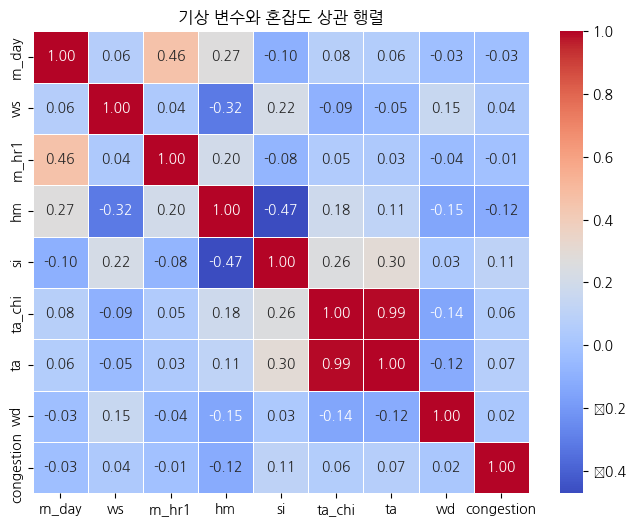

In [4]:
# 상관 행렬 시각화
correlation_matrix = df[weather_cols + ['congestion']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("기상 변수와 혼잡도 상관 행렬")
plt.show()


In [116]:
df_summer['datetime'] = pd.to_datetime(df['datetime'])  # 혹시 모를 datetime 변환
df['hour'] = df['datetime'].dt.hour
print(df.columns)

Index(['Unnamed: 0', 'tm', 'line', 'station_number', 'station_name',
       'direction', 'stn', 'ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si',
       'ta_chi', 'congestion', 'm_hr1', 'missing_count', 'multiple_missing',
       'datetime', 'month', 'dayofweek', 'hour'],
      dtype='object')


In [117]:
df_pred = pd.read_csv(r"C:\Users\COEL_03\Desktop\CLIMAX-main\projet\pred_result_hour_only.csv")
print(df_pred['congestion2'])

0       -0.060183
1       -0.092247
2       36.349316
3       24.167376
4       46.379284
          ...    
3859    45.475117
3860    37.562683
3861    52.531760
3862    39.879246
3863    17.170315
Name: congestion2, Length: 3864, dtype: float64


In [171]:
import pandas as pd

# 예측 결과 불러오기
df_pred = pd.read_csv(r"C:\Users\COEL_03\Desktop\CLIMAX-main\projet\pred_result_hour_only.csv")
# 인덱스를 리셋해서 0부터 맞춰줌
df_summer = df_summer.reset_index(drop=True)
df_pred = df_pred.reset_index(drop=True)

# 같은 순서로 예측값 삽입
df_summer['predicted_congestion'] = df_pred['congestion2']
df_summer['residual'] = df_summer['congestion'] - df_summer['predicted_congestion']



0        0.060183
1        0.092247
2      -18.349316
3       -9.167376
4      -18.379284
          ...    
3859   -13.475117
3860   -10.562683
3861   -15.531760
3862   -10.879246
3863    -7.170315
Name: residual, Length: 3864, dtype: float64


In [173]:
print(df_summer['congestion'])
print(df_pred['congestion2'])
print(df_summer['residual'])

0        0
1        0
2       18
3       15
4       28
        ..
3859    32
3860    27
3861    37
3862    29
3863    10
Name: congestion, Length: 3864, dtype: int64
0       -0.060183
1       -0.092247
2       36.349316
3       24.167376
4       46.379284
          ...    
3859    45.475117
3860    37.562683
3861    52.531760
3862    39.879246
3863    17.170315
Name: congestion2, Length: 3864, dtype: float64
0        0.060183
1        0.092247
2      -18.349316
3       -9.167376
4      -18.379284
          ...    
3859   -13.475117
3860   -10.562683
3861   -15.531760
3862   -10.879246
3863    -7.170315
Name: residual, Length: 3864, dtype: float64


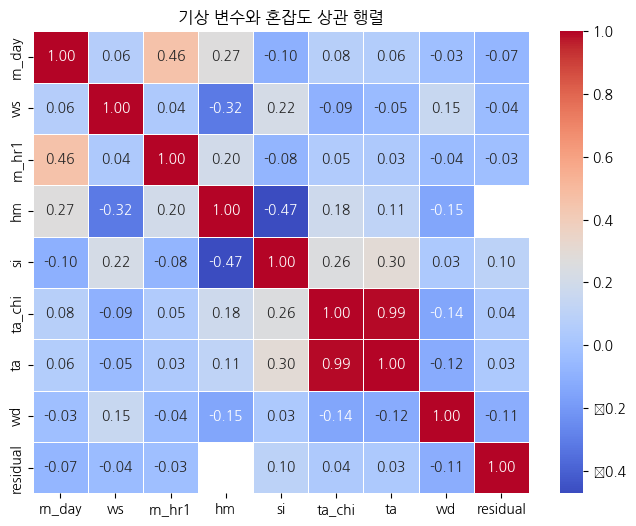

In [31]:
# 상관 행렬 시각화
correlation_matrix = df[weather_cols + ['residual']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("기상 변수와 혼잡도 상관 행렬")
plt.show()


In [172]:
import matplotlib.pyplot as plt
# 시간별 평균값 계산
df_hourly_avg = df.groupby('hour')[['residual', 'ta', 'ws', 'wd', 'rn_day', 'hm', 'si', 'ta_chi']].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_hourly_avg['hour'], df_hourly_avg['residual'], label='잔차 혼잡도', marker='o')
plt.plot(df_hourly_avg['hour'], df_hourly_avg['ta'], label='기온(ta)', marker='x')
plt.xlabel('시간대 (hour)')
plt.ylabel('평균값')
plt.title('시간대별 잔차 혼잡도 및 기온 평균')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


KeyError: "Columns not found: 'residual'"

In [189]:
# 데이터 로딩 (자기 파일 위치로 바꿔서 하세요)
import pandas as pd                 # DB 분석 위한 핵심 라이브러리 -> DataFrame, Series 등 DB 구조 제공
import numpy as np                  # 수치 연산 위한 핵심 라이브러리 -> 수치 계산, 배열 연산
import matplotlib.pyplot as plt     # 시각화 위한 핵심 라이브러리 -> 그래프, 차트 그리기
import seaborn as sns               # 시각화 위한 핵심 라이브러리 -> matplolib 기반 고급 통계 시각화 라이브러리
from scipy import stats             # 통계 연산 위한 핵심 라이브러리 -> 통계 분석, 확률 분포 관련 함수들 제공
import warnings                     # 경고 메세지 제어
warnings.filterwarnings('ignore')   # 경고 메세지 무시
df = pd.read_csv(r'C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway23.csv', encoding='cp949') #경로에 맞게, 안되면 utf-8로 바꿔서 해보기
# 컬럼명 매핑
column_mapping = {
    'train_subway23.tm': 'tm',
    'train_subway23.line': 'line',
    'train_subway23.station_number': 'station_number',
    'train_subway23.station_name': 'station_name',
    'train_subway23.direction': 'direction',
    'train_subway23.stn': 'stn',
    'train_subway23.ta': 'ta',
    'train_subway23.wd': 'wd',
    'train_subway23.ws': 'ws',
    'train_subway23.rn_day': 'rn_day',
    'train_subway23.rn_hr1': 'rn_hr1',
    'train_subway23.hm': 'hm',
    'train_subway23.si': 'si',
    'train_subway23.ta_chi': 'ta_chi',
    'train_subway23.congestion': 'congestion'
}
df = df.rename(columns=column_mapping)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'


# ✅ datetime 변환 및 시간 정보 추출
df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
df['m_hr1'] = df['datetime'].dt.hour #시간
df['month'] = df['datetime'].dt.month #달
df['dayofweek'] = df['datetime'].dt.dayofweek  # 요일 0 = 월요일, 6 = 일요일

# ✅ 2. 여름(6~8월) + 특정 역 필터링
selected_station = '강남'  # <- 원하는 역으로 바꾸면 됨
df_summer = df[(df['month'].isin([6,7,8])) & (df['station_name'] == selected_station)].copy() # 원하는 계절

# 예측 결과 불러오기
df_pred = pd.read_csv(r"C:\Users\COEL_03\Desktop\CLIMAX-main\pred_result_hour_only.csv") #경로에 맞게
# 인덱스를 리셋해서 0부터 맞춰줌
df_summer = df_summer.reset_index(drop=True)
df_pred = df_pred.reset_index(drop=True)

# 같은 순서로 예측값 삽입
df_summer['predicted_congestion'] = df_pred['congestion2']
df_summer['residual'] = df_summer['congestion'] - df_summer['predicted_congestion']

In [190]:
print(df_summer['congestion'])
print(df_pred['congestion2'])

0       19
1        0
2       25
3       17
4       30
        ..
3859    42
3860    33
3861    46
3862    42
3863    25
Name: congestion, Length: 3864, dtype: int64
0       11.254757
1        0.038509
2       24.471100
3       16.057055
4       28.028915
          ...    
3859    33.735966
3860    28.535564
3861    36.803997
3862    35.303010
3863    22.415932
Name: congestion2, Length: 3864, dtype: float64


In [191]:
# 결측치 처리 (-99를 NaN으로 변환)
print("\n🚨 결측치 처리 중...")
weather_cols = ['rn_day', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi','ta','wd']
for col in weather_cols:
    before_count = (df_summer[col] == -99).sum()
    df_summer[col] = df_summer[col].replace(-99, np.nan)
    print(f"{col}: -99 값 {before_count:,}개를 NaN으로 변환")
df_summer['wd'] = df_summer['wd'].replace(-9.9, np.nan)

# 결측치 비율 분석
print("\n📊 결측치 비율 분석:")
total_records = len(df_summer)
for col in weather_cols:
    missing_count = df_summer[col].isnull().sum()
    missing_rate = (missing_count / total_records) * 100
    print(f"{col}: {missing_count:,}개 ({missing_rate:.2f}%)")

print(f"\n전체 데이터: {total_records:,}개")
print(f"모든 기후변수가 완전한 행: {len(df_summer[weather_cols].dropna()):,}개 ({len(df_summer[weather_cols].dropna())/total_records*100:.2f}%)")

# 시간 변수 추출
## 현재 tm 컬럼은 년월일시간이 합쳐진 상태임. -> 시간대별 분석이 필요하기 때문에 시간 변수 추출
df_summer['m_hr1'] = df_summer['tm'] % 100

print(f"\n⏰ 시간 변수 추출 확인:")
print(f"tm 샘플: {df_summer['tm'].head().tolist()}")
print(f"추출된 시간 범위: {df_summer['m_hr1'].min()} ~ {df_summer['m_hr1'].max()}")
print(df['m_hr1'].value_counts().sort_index())
print(f"시간 분포 (상위 10개):")
print(df['m_hr1'].value_counts().sort_index().head(10))

# 일사량 야간시간대 물리적 처리
print("\n🌙 일사량 야간시간대 처리 중...")
night_hours = [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]
night_mask = df_summer['m_hr1'].isin(night_hours)
night_si_missing = df_summer.loc[night_mask, 'si'].isnull().sum()
df_summer.loc[night_mask, 'si'] = 0.0
print(f"야간시간대({night_hours}) 일사량 결측값 {night_si_missing:,}개를 0으로 설정")

# 동시 결측 패턴 확인
print("\n🔍 동시 결측 패턴 확인:")
basic_weather = ['rn_day', 'ws', 'rn_hr1', 'hm']
df_summer['missing_count'] = df_summer[basic_weather].isnull().sum(axis=1)
df_summer['multiple_missing'] = df_summer['missing_count'] >= 2
print(f"2개 이상 동시 결측: {df_summer['multiple_missing'].sum():,}개 ({df_summer['multiple_missing'].sum()/len(df_summer)*100:.2f}%)")

# 변수들 대한 기술통계(평균, 표준편차, 최솟값, 최댓값 등)
print("\n📊 기본 통계:")
print(df_summer[weather_cols + ['congestion', 'm_hr1']].describe())

# 혼잡도 관련 범위, 평균, 결측치 확인
print("\n🎯 타겟 변수 확인:")
target_col = 'congestion'
print(f"혼잡도 범위: {df_summer[target_col].min():.2f} ~ {df_summer[target_col].max():.2f}")
print(f"혼잡도 평균: {df_summer[target_col].mean():.2f}")
print(f"혼잡도 결측치: {df_summer[target_col].isnull().sum()}개")

# 날씨 변수 관련 범위 및 결측치 수
print("\n🌡️ 날씨 변수 확인:")
for col in weather_cols:
    non_null_data = df[col].dropna()
    if len(non_null_data) > 0:
        print(f"{col}: {non_null_data.min():.2f} ~ {non_null_data.max():.2f} (결측치: {df_summer[col].isnull().sum():,}개)")
    else:
        print(f"{col}: 모든 값이 결측치")

print(f"\n📊 최종 데이터 현황:")
print(f"전체 행 수: {len(df):,}")
print(f"결측치가 없는 완전한 행 수: {len(df.dropna()):,}")


🚨 결측치 처리 중...
rn_day: -99 값 4개를 NaN으로 변환
ws: -99 값 6개를 NaN으로 변환
rn_hr1: -99 값 6개를 NaN으로 변환
hm: -99 값 4개를 NaN으로 변환
si: -99 값 1,108개를 NaN으로 변환
ta_chi: -99 값 0개를 NaN으로 변환
ta: -99 값 4개를 NaN으로 변환
wd: -99 값 6개를 NaN으로 변환

📊 결측치 비율 분석:
rn_day: 4개 (0.10%)
ws: 6개 (0.16%)
rn_hr1: 6개 (0.16%)
hm: 4개 (0.10%)
si: 1,108개 (28.67%)
ta_chi: 0개 (0.00%)
ta: 4개 (0.10%)
wd: 6개 (0.16%)

전체 데이터: 3,864개
모든 기후변수가 완전한 행: 2,750개 (71.17%)

⏰ 시간 변수 추출 확인:
tm 샘플: [2023060100, 2023060101, 2023060105, 2023060106, 2023060107]
추출된 시간 범위: 0 ~ 23
m_hr1
0     262904
1     262903
5     262904
6     262904
7     262904
8     262904
9     262904
10    262904
11    262904
12    262904
13    262904
14    262904
15    262903
16    262904
17    262904
18    262904
19    262904
20    262903
21    262904
22    262904
23    262904
Name: count, dtype: int64
시간 분포 (상위 10개):
m_hr1
0     262904
1     262903
5     262904
6     262904
7     262904
8     262904
9     262904
10    262904
11    262904
12    262904
Name: count, dtype: int64



In [192]:
print(df_summer['residual'])

0       7.745243
1      -0.038509
2       0.528900
3       0.942945
4       1.971085
          ...   
3859    8.264034
3860    4.464436
3861    9.196003
3862    6.696990
3863    2.584068
Name: residual, Length: 3864, dtype: float64


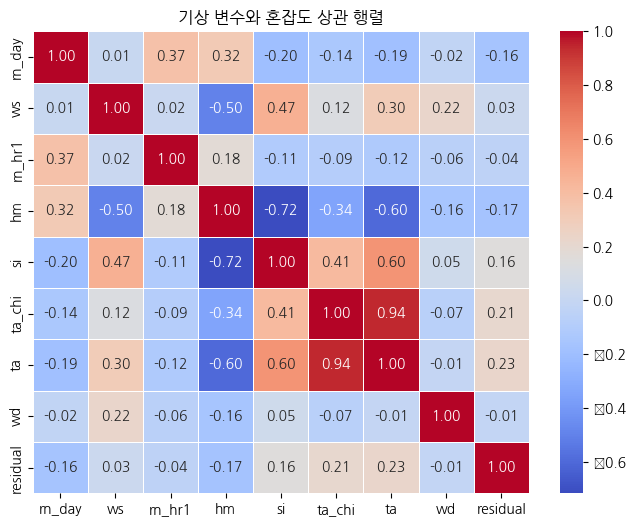

In [193]:
# 상관 행렬 시각화
correlation_matrix = df_summer[weather_cols + ['residual']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("기상 변수와 혼잡도 상관 행렬")
plt.show()


🔴 기상변수 vs 시간대별 혼잡도 보기

🔴 기온 vs 시간대별 혼잡도 보기

In [225]:
from scipy.stats import pearsonr, spearmanr

clim = 'ta'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")



📊 [강남] 시간대별 'ta' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=-0.300 (p=0.0000, 📉 보통) | Spearman ρ=-0.236 (p=0.0013, 📉 보통) → ✔✔ 모두 유의
 1시 (n=184): Pearson r=+0.121 (p=0.1017, 🔹 약함) | Spearman ρ=+0.171 (p=0.0205, 🔹 약함) → ✔❌ 한쪽만 유의
 5시 (n=184): Pearson r=+0.204 (p=0.0054, 📉 보통) | Spearman ρ=+0.150 (p=0.0420, 🔹 약함) → ✔✔ 모두 유의
 6시 (n=184): Pearson r=+0.103 (p=0.1628, 🔹 약함) | Spearman ρ=+0.055 (p=0.4605, 🔹 약함) → ✖✖ 무유의
 7시 (n=184): Pearson r=+0.079 (p=0.2864, 🔹 약함) | Spearman ρ=+0.040 (p=0.5926, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=+0.096 (p=0.1949, 🔹 약함) | Spearman ρ=+0.125 (p=0.0911, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.155 (p=0.0360, 🔹 약함) | Spearman ρ=-0.187 (p=0.0109, 🔹 약함) → ✔✔ 모두 유의
10시 (n=184): Pearson r=+0.121 (p=0.1018, 🔹 약함) | Spearman ρ=+0.099 (p=0.1834, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=+0.280 (p=0.0001, 📉 보통) | Spearman ρ=+0.282 (p=0.0001, 📉 보통) → ✔✔ 모두 유의
12시 (n=184): Pearson r=+0.181 (p=0.0138, 🔹 약함) | Spearman ρ=+0.211 (p=0.0040, 📉 보통) → ✔✔ 모두 유의
13시 (n=184): Pearson r=+

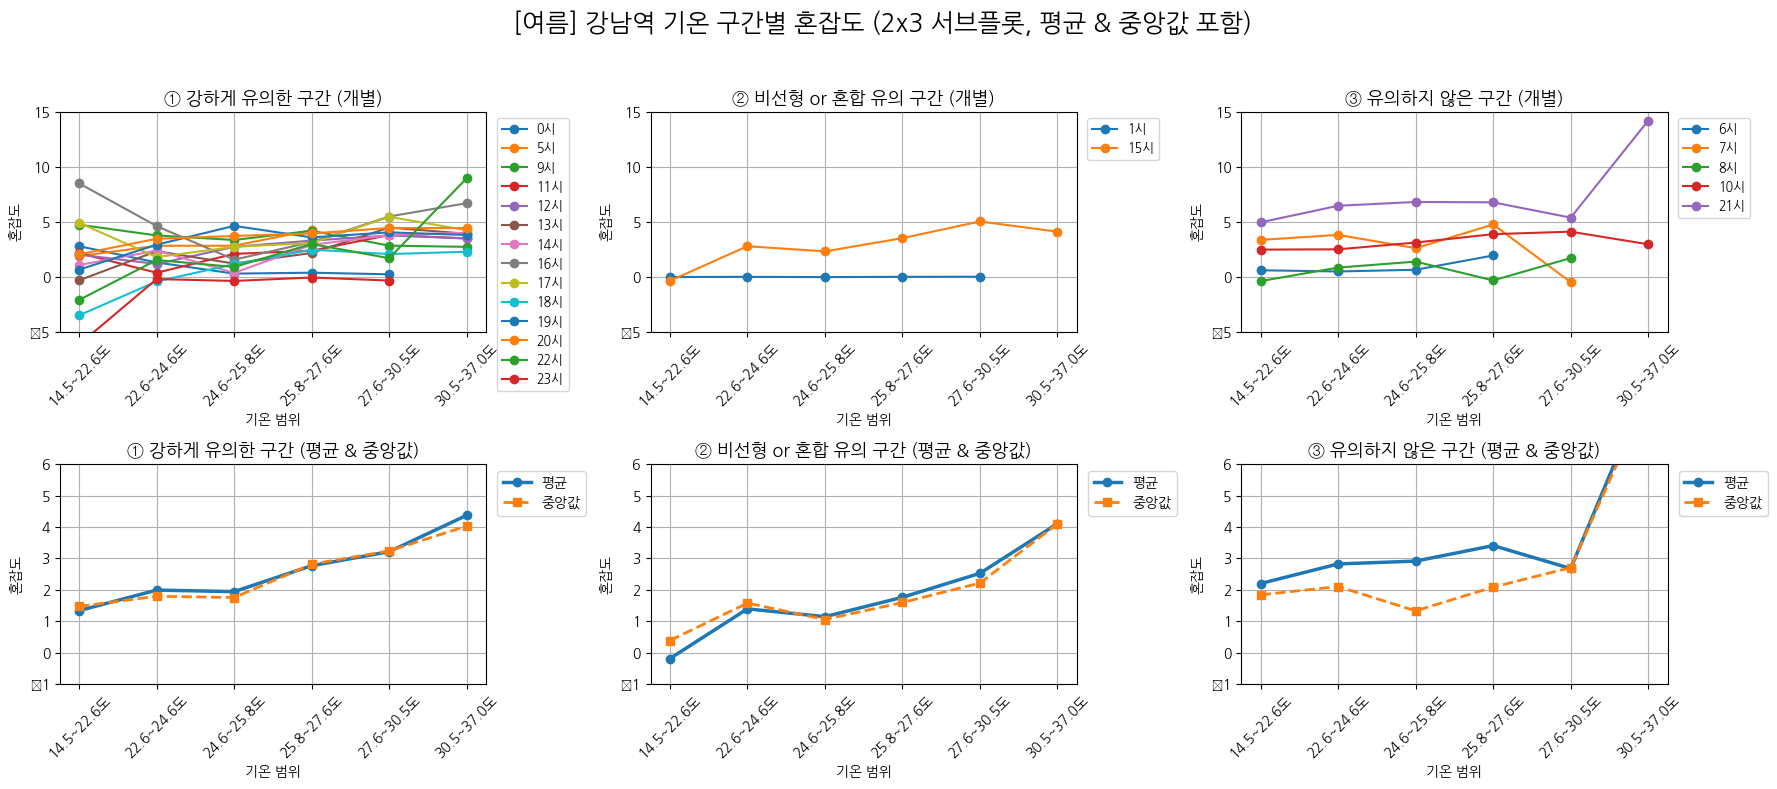

In [226]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

clim = 'ta'
quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = quantiles.values
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}도' for i in range(len(bins)-1)]
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=bins, labels=labels, include_lowest=True)


groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 설정
ylim = (-5, 15)
ylim2 = (-1, 6)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("기온 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("기온 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 기온 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


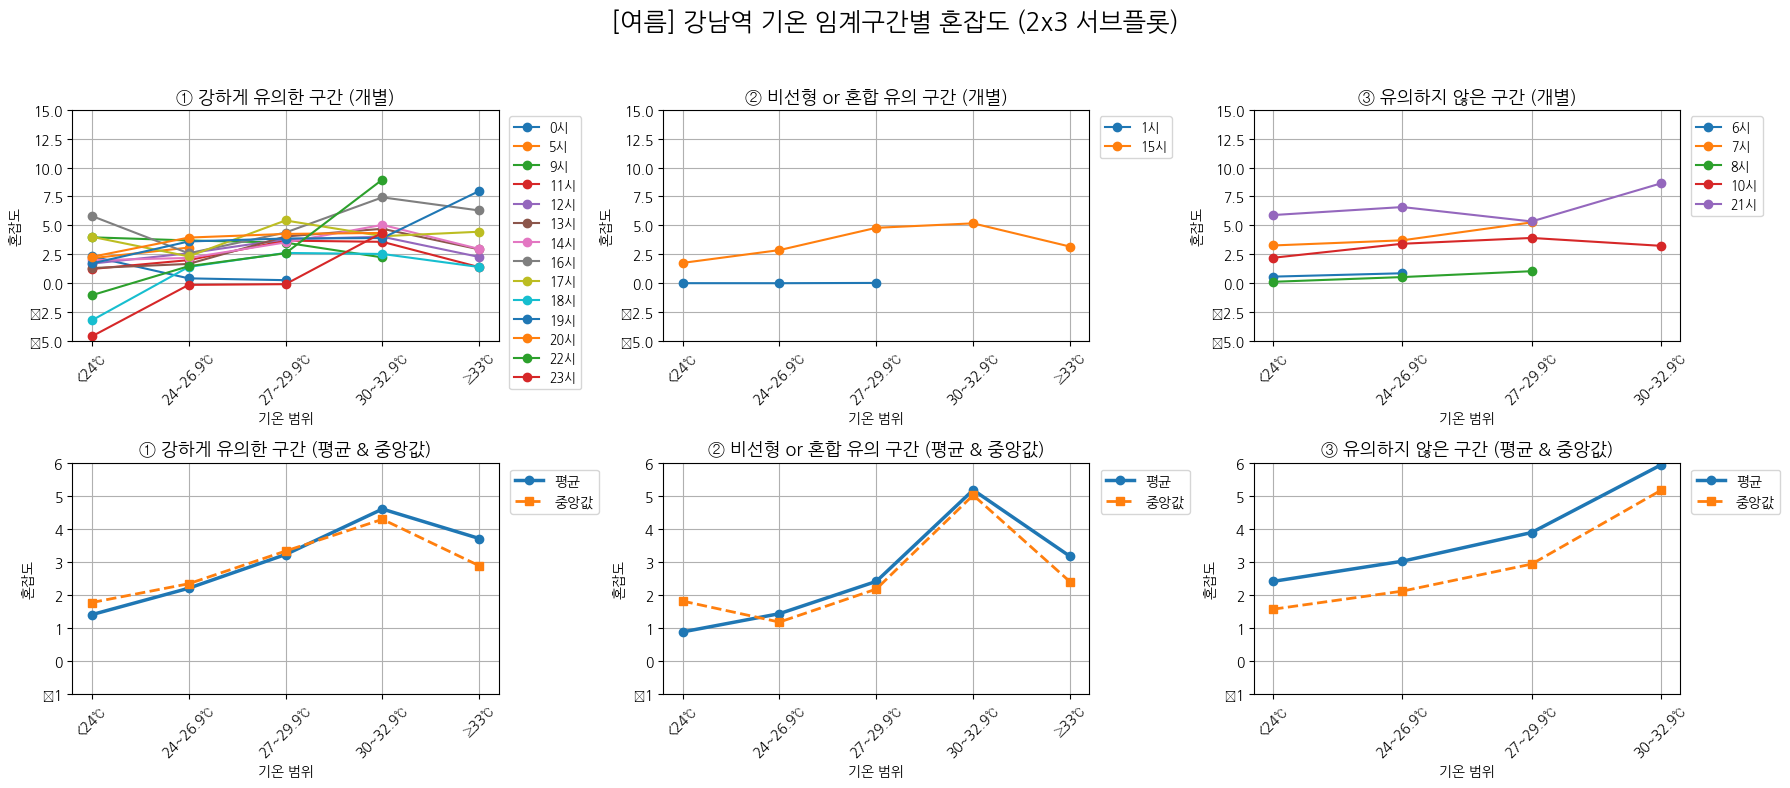

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 임계치 기반 기온 구간 설정 (여름 기준)
clim = 'ta'
bins = [df_summer[clim].min()-1, 24, 27, 30, 33, df_summer[clim].max()+1]
labels = ["<24℃", "24~26.9℃", "27~29.9℃", "30~32.9℃", "≥33℃"]
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=bins, labels=labels, include_lowest=True)


groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 통일
ylim = (-5, 15)
ylim2 = (-1, 6)

# ✅ 2x3 subplot 그리기
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# 🔹 (1행) 개별 시간대 그래프
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("기온 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))

# 🔹 (2행) 평균 + 중앙값 그래프
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("기온 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))

# 🔹 전체 제목
plt.suptitle(f"[여름] {selected_station}역 기온 임계구간별 잔차혼잡도 (2x3 서브플롯)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


🔴 강수량(일별) vs 시간대별 혼잡도 보기


📊 [강남] 시간대별 'rn_day' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=+0.031 (p=0.6721, 🔹 약함) | Spearman ρ=+0.092 (p=0.2139, 🔹 약함) → ✖✖ 무유의
 1시 (n=184): Pearson r=+0.021 (p=0.7789, 🔹 약함) | Spearman ρ=-0.028 (p=0.7051, 🔹 약함) → ✖✖ 무유의
 5시 (n=184): Pearson r=-0.185 (p=0.0121, 🔹 약함) | Spearman ρ=-0.272 (p=0.0002, 📉 보통) → ✔✔ 모두 유의
 6시 (n=184): Pearson r=-0.199 (p=0.0067, 🔹 약함) | Spearman ρ=-0.266 (p=0.0003, 📉 보통) → ✔✔ 모두 유의
 7시 (n=184): Pearson r=-0.013 (p=0.8660, 🔹 약함) | Spearman ρ=-0.002 (p=0.9748, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=-0.063 (p=0.3931, 🔹 약함) | Spearman ρ=-0.098 (p=0.1868, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.046 (p=0.5356, 🔹 약함) | Spearman ρ=-0.002 (p=0.9749, 🔹 약함) → ✖✖ 무유의
10시 (n=184): Pearson r=-0.087 (p=0.2387, 🔹 약함) | Spearman ρ=-0.064 (p=0.3904, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=-0.261 (p=0.0003, 📉 보통) | Spearman ρ=-0.246 (p=0.0007, 📉 보통) → ✔✔ 모두 유의
12시 (n=184): Pearson r=-0.262 (p=0.0003, 📉 보통) | Spearman ρ=-0.352 (p=0.0000, 📉 보통) → ✔✔ 모두 유의
13시 (n=184): Pearson r=-0

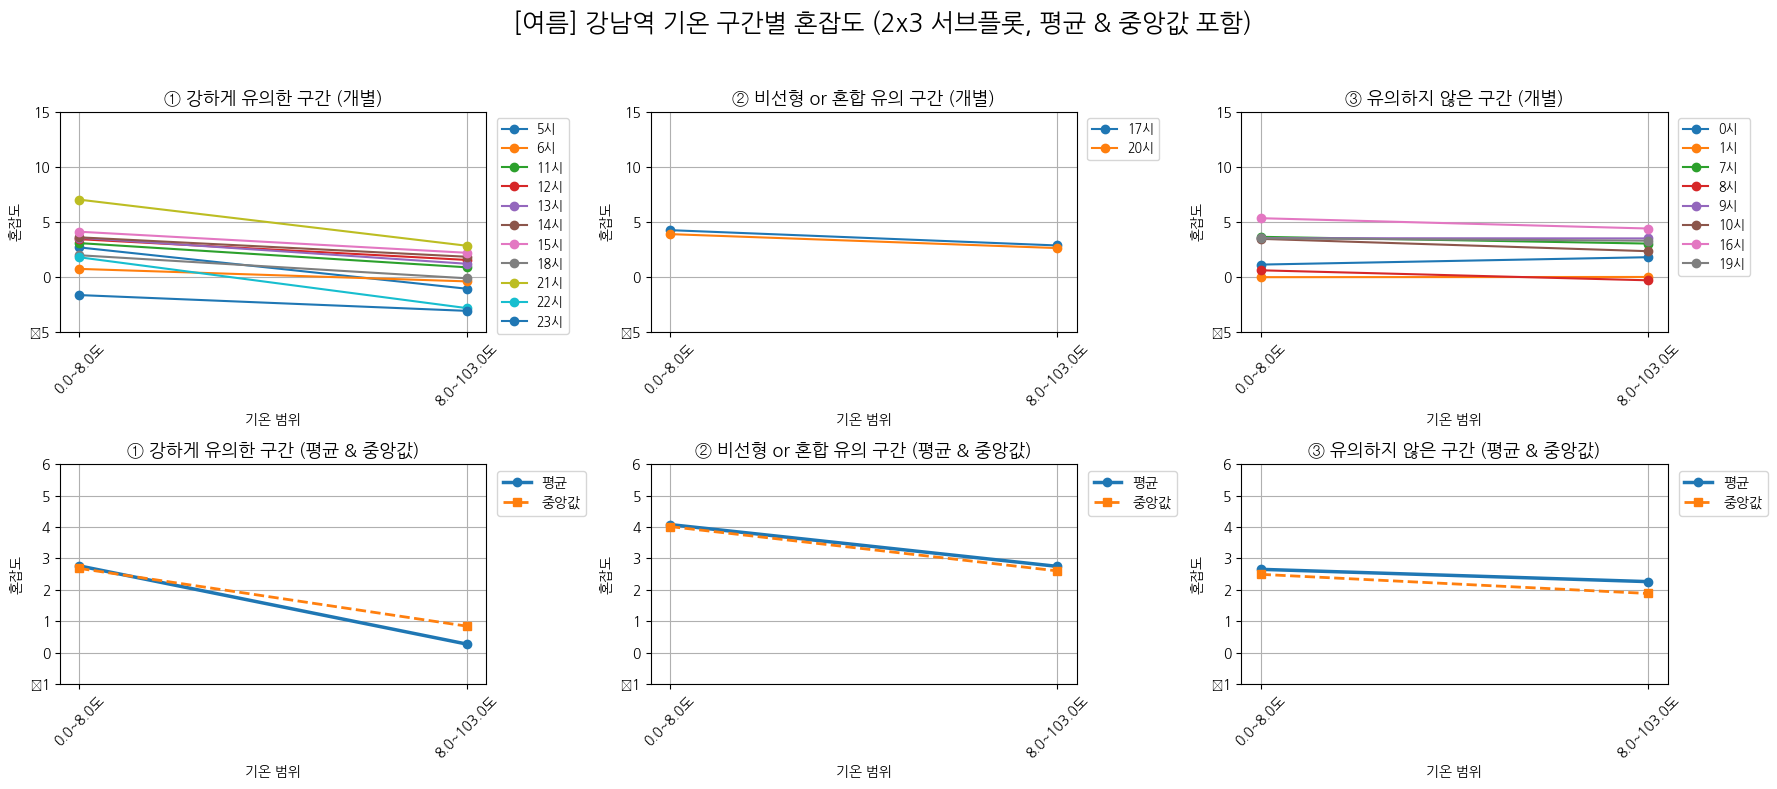

In [ ]:
from scipy.stats import pearsonr, spearmanr

clim = 'rn_day'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = quantiles.values
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}mm' for i in range(len(bins)-1)]
# 중복 제거된 분위수 경계값 얻기
unique_bins = np.unique(quantiles.values)

# 라벨도 새로 생성
labels = [f'{round(unique_bins[i],1)}~{round(unique_bins[i+1],1)}mm' for i in range(len(unique_bins)-1)]

# 구간 분류
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=unique_bins, labels=labels, include_lowest=True)

groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 설정
ylim = (-5, 15)
ylim2 = (-1, 6)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("일강수량 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("일강수량 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 일강수량 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
#이거

🔴 일사량 vs 시간대별 혼잡도 보기


📊 [강남] 시간대별 'si' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=+nan (p=nan, 🔹 약함) | Spearman ρ=+nan (p=nan, 🔹 약함) → ✖✖ 무유의
 1시 (n=184): Pearson r=+nan (p=nan, 🔹 약함) | Spearman ρ=+nan (p=nan, 🔹 약함) → ✖✖ 무유의
 5시 (n=184): Pearson r=+nan (p=nan, 🔹 약함) | Spearman ρ=+nan (p=nan, 🔹 약함) → ✖✖ 무유의
 6시 (n=184): Pearson r=+nan (p=nan, 🔹 약함) | Spearman ρ=+nan (p=nan, 🔹 약함) → ✖✖ 무유의
 7시 (n=184): Pearson r=-0.121 (p=0.1024, 🔹 약함) | Spearman ρ=-0.095 (p=0.1986, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=+0.000 (p=0.9985, 🔹 약함) | Spearman ρ=+0.084 (p=0.2545, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.067 (p=0.3634, 🔹 약함) | Spearman ρ=-0.081 (p=0.2740, 🔹 약함) → ✖✖ 무유의
10시 (n=184): Pearson r=+0.033 (p=0.6565, 🔹 약함) | Spearman ρ=+0.018 (p=0.8086, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=+0.192 (p=0.0091, 🔹 약함) | Spearman ρ=+0.148 (p=0.0445, 🔹 약함) → ✔✔ 모두 유의
12시 (n=184): Pearson r=+0.283 (p=0.0001, 📉 보통) | Spearman ρ=+0.288 (p=0.0001, 📉 보통) → ✔✔ 모두 유의
13시 (n=184): Pearson r=+0.311 (p=0.0000, 📉 보통) | Spearman ρ=+0.303 (p=0.0

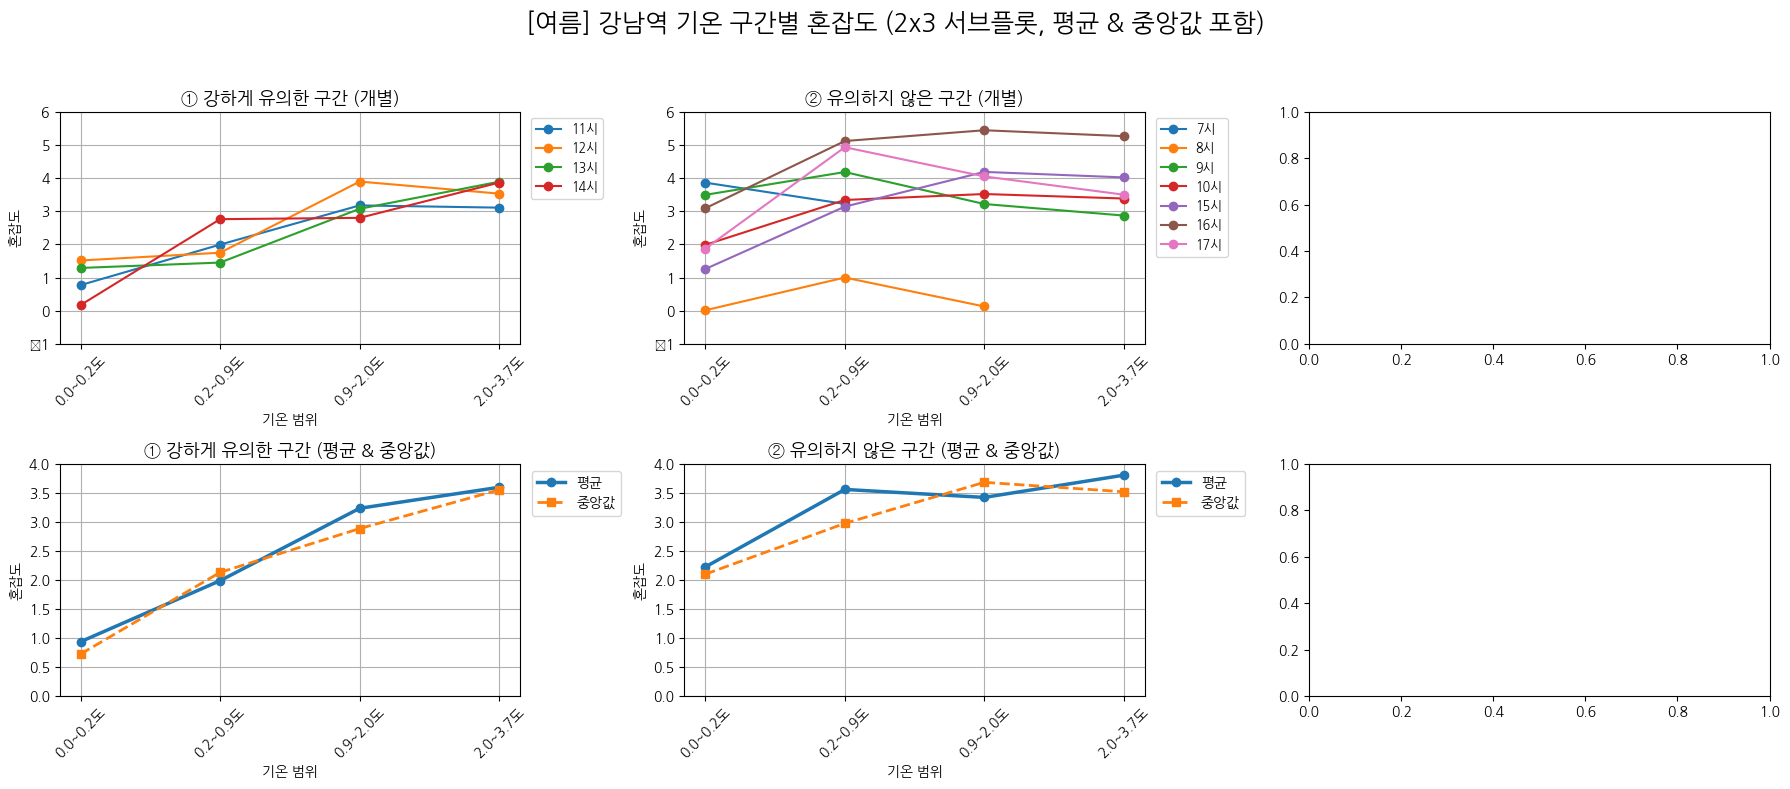

In [245]:
from scipy.stats import pearsonr, spearmanr

clim = 'si'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

group_1 = [11,12,13,14]
group_2 = [7,8,9,10,15,16,17]
quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = quantiles.values
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}MJ/m^2' for i in range(len(bins)-1)]
# 중복 제거된 분위수 경계값 얻기
unique_bins = np.unique(quantiles.values)

# 라벨도 새로 생성
labels = [f'{round(unique_bins[i],1)}~{round(unique_bins[i+1],1)}MJ/m^2' for i in range(len(unique_bins)-1)]

# 구간 분류
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=unique_bins, labels=labels, include_lowest=True)

groups = {
    "① 강하게 유의한 구간": group_1,
    "② 유의하지 않은 구간": group_2,
}

# ✅ y축 범위 설정
ylim = (-1, 6)
ylim2 = (0, 4)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("일사량 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("일사량 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 일사량 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


🔴 풍속 vs 시간대별 혼잡도 보기


📊 [강남] 시간대별 'ws' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=+0.051 (p=0.4898, 🔹 약함) | Spearman ρ=-0.009 (p=0.8983, 🔹 약함) → ✖✖ 무유의
 1시 (n=184): Pearson r=+0.034 (p=0.6488, 🔹 약함) | Spearman ρ=-0.007 (p=0.9229, 🔹 약함) → ✖✖ 무유의
 5시 (n=184): Pearson r=-0.180 (p=0.0147, 🔹 약함) | Spearman ρ=-0.221 (p=0.0025, 📉 보통) → ✔✔ 모두 유의
 6시 (n=184): Pearson r=-0.111 (p=0.1319, 🔹 약함) | Spearman ρ=-0.077 (p=0.2959, 🔹 약함) → ✖✖ 무유의
 7시 (n=184): Pearson r=+0.018 (p=0.8084, 🔹 약함) | Spearman ρ=+0.038 (p=0.6127, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=-0.020 (p=0.7876, 🔹 약함) | Spearman ρ=-0.040 (p=0.5863, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.074 (p=0.3169, 🔹 약함) | Spearman ρ=-0.106 (p=0.1503, 🔹 약함) → ✖✖ 무유의
10시 (n=182): Pearson r=-0.012 (p=0.8773, 🔹 약함) | Spearman ρ=-0.014 (p=0.8477, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=+0.103 (p=0.1641, 🔹 약함) | Spearman ρ=+0.070 (p=0.3485, 🔹 약함) → ✖✖ 무유의
12시 (n=184): Pearson r=+0.079 (p=0.2842, 🔹 약함) | Spearman ρ=+0.059 (p=0.4227, 🔹 약함) → ✖✖ 무유의
13시 (n=184): Pearson r=+0.010 (p=0.

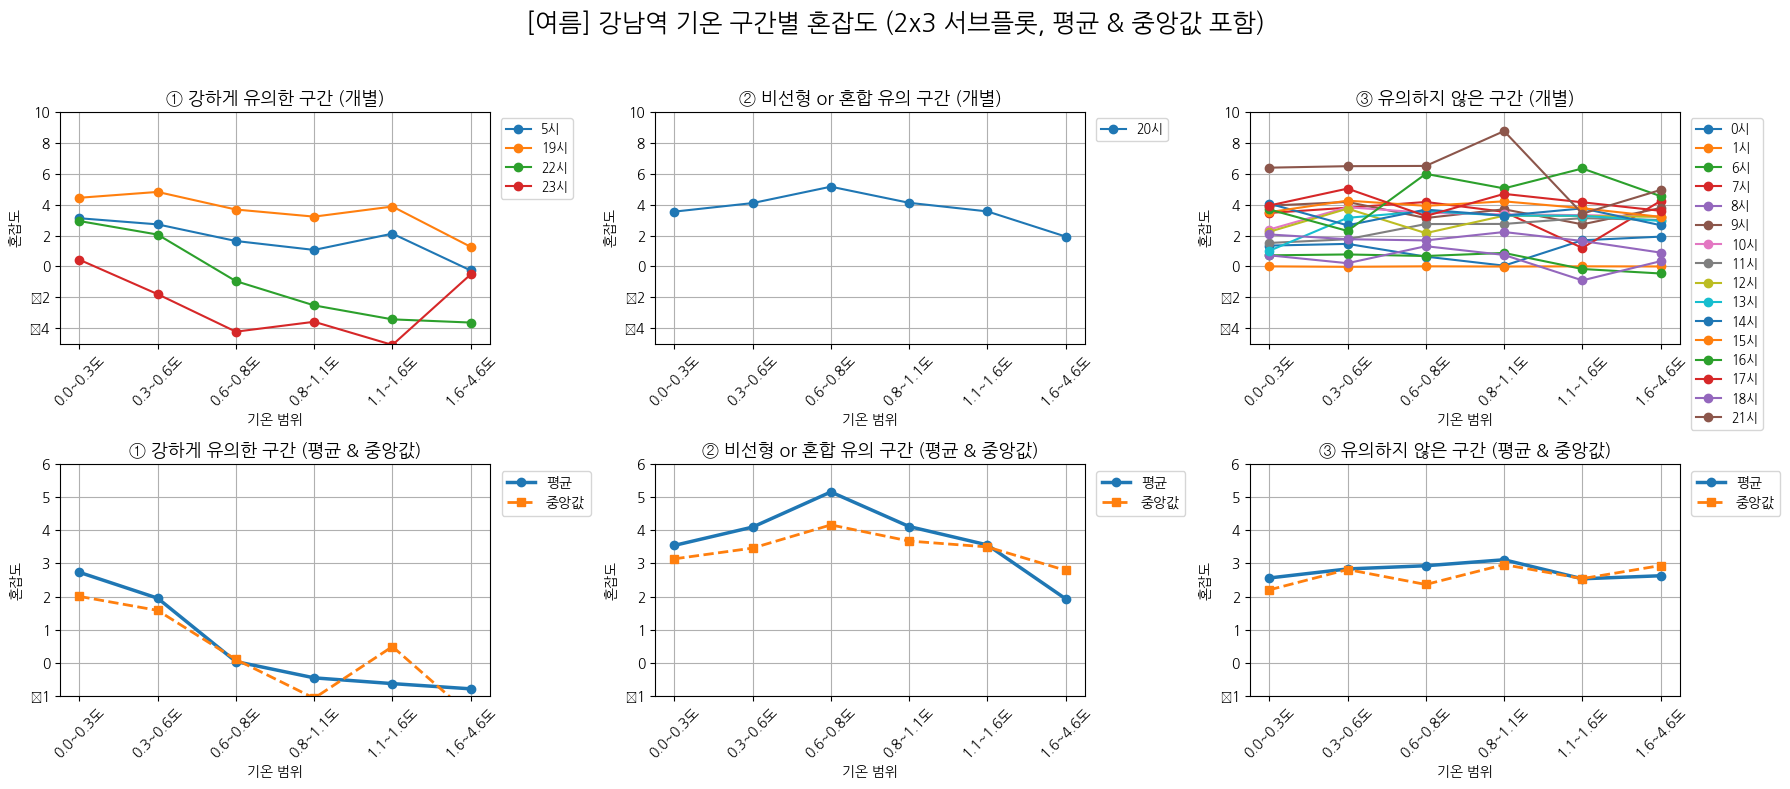

In [ ]:
from scipy.stats import pearsonr, spearmanr

clim = 'ws'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = quantiles.values
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}m/s' for i in range(len(bins)-1)]
# 중복 제거된 분위수 경계값 얻기
unique_bins = np.unique(quantiles.values)

# 라벨도 새로 생성
labels = [f'{round(unique_bins[i],1)}~{round(unique_bins[i+1],1)}m/s' for i in range(len(unique_bins)-1)]

# 구간 분류
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=unique_bins, labels=labels, include_lowest=True)

groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 설정
ylim = (-5, 10)
ylim2 = (-1, 6)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("풍속 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("풍속 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 풍속 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🔴 습도 vs 시간대별 혼잡도 보기


📊 [강남] 시간대별 'hm' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=-0.035 (p=0.6409, 🔹 약함) | Spearman ρ=+0.069 (p=0.3494, 🔹 약함) → ✖✖ 무유의
 1시 (n=184): Pearson r=-0.044 (p=0.5562, 🔹 약함) | Spearman ρ=+0.012 (p=0.8712, 🔹 약함) → ✖✖ 무유의
 5시 (n=184): Pearson r=-0.057 (p=0.4450, 🔹 약함) | Spearman ρ=-0.048 (p=0.5218, 🔹 약함) → ✖✖ 무유의
 6시 (n=184): Pearson r=-0.210 (p=0.0043, 📉 보통) | Spearman ρ=-0.171 (p=0.0204, 🔹 약함) → ✔✔ 모두 유의
 7시 (n=184): Pearson r=-0.053 (p=0.4758, 🔹 약함) | Spearman ρ=-0.009 (p=0.8991, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=-0.051 (p=0.4913, 🔹 약함) | Spearman ρ=-0.078 (p=0.2921, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.024 (p=0.7466, 🔹 약함) | Spearman ρ=+0.038 (p=0.6120, 🔹 약함) → ✖✖ 무유의
10시 (n=184): Pearson r=+0.026 (p=0.7297, 🔹 약함) | Spearman ρ=+0.051 (p=0.4957, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=-0.162 (p=0.0284, 🔹 약함) | Spearman ρ=-0.091 (p=0.2191, 🔹 약함) → ✔❌ 한쪽만 유의
12시 (n=184): Pearson r=-0.251 (p=0.0006, 📉 보통) | Spearman ρ=-0.242 (p=0.0009, 📉 보통) → ✔✔ 모두 유의
13시 (n=184): Pearson r=-0.222 

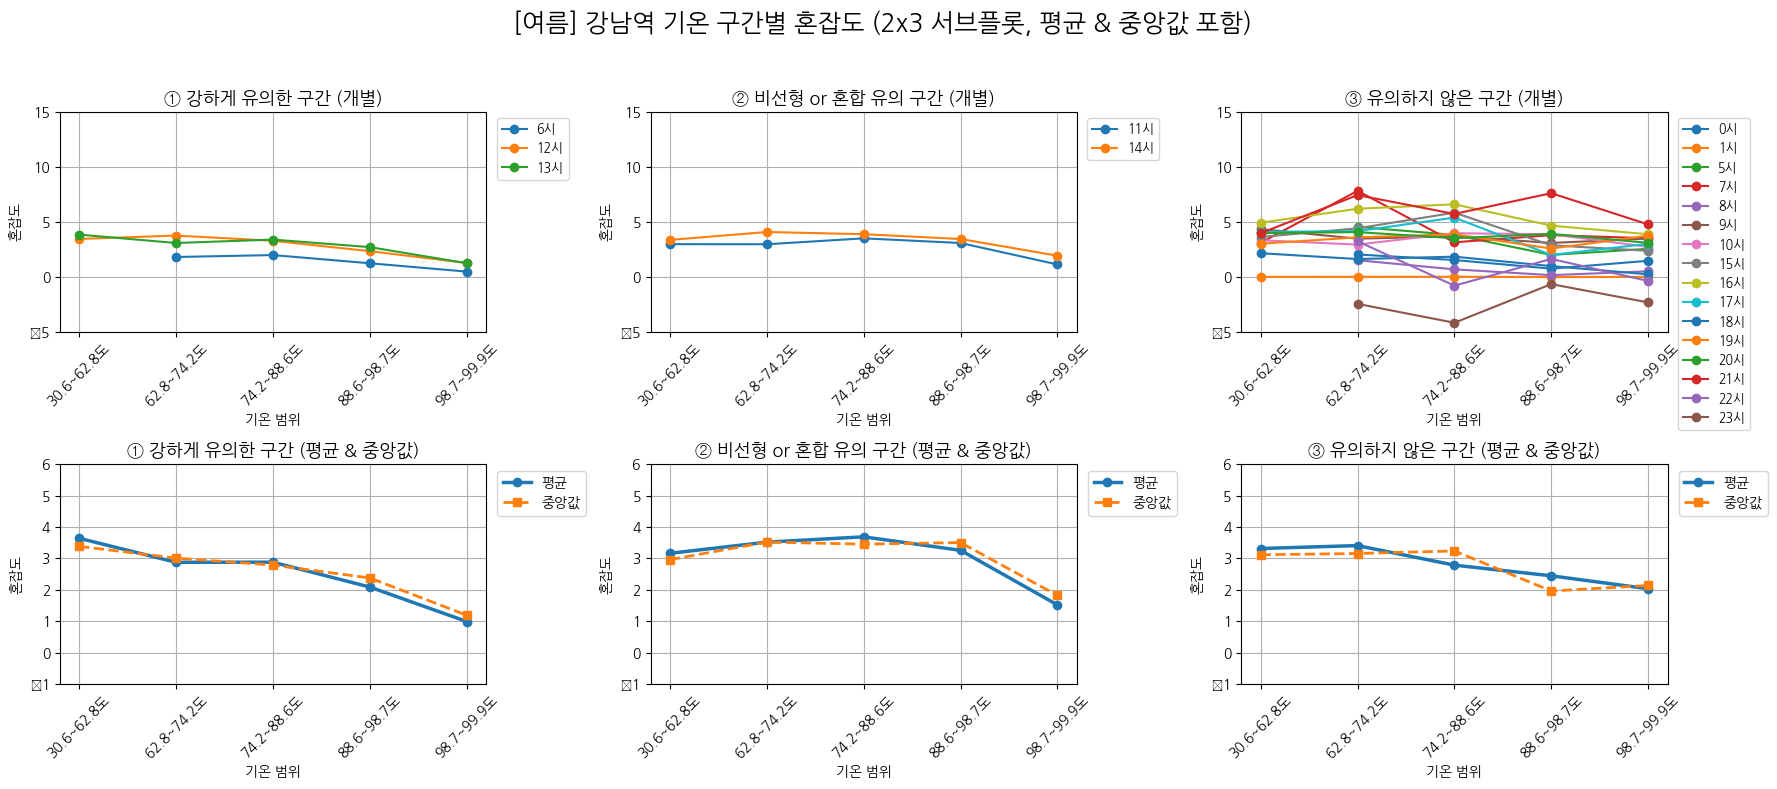

In [248]:
from scipy.stats import pearsonr, spearmanr

clim = 'hm'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = quantiles.values
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}%' for i in range(len(bins)-1)]
# 중복 제거된 분위수 경계값 얻기
unique_bins = np.unique(quantiles.values)

# 라벨도 새로 생성
labels = [f'{round(unique_bins[i],1)}~{round(unique_bins[i+1],1)}%' for i in range(len(unique_bins)-1)]

# 구간 분류
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=unique_bins, labels=labels, include_lowest=True)

groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 설정
ylim = (-5, 15)
ylim2 = (-1, 6)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("습도 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("습도 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 습도 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🔴체감온도 vs 시간대 혼잡도


📊 [강남] 시간대별 'ta_chi' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=-0.327 (p=0.0000, 📉 보통) | Spearman ρ=-0.252 (p=0.0006, 📉 보통) → ✔✔ 모두 유의
 1시 (n=184): Pearson r=+0.091 (p=0.2213, 🔹 약함) | Spearman ρ=+0.157 (p=0.0330, 🔹 약함) → ✔❌ 한쪽만 유의
 5시 (n=184): Pearson r=+0.239 (p=0.0011, 📉 보통) | Spearman ρ=+0.209 (p=0.0045, 📉 보통) → ✔✔ 모두 유의
 6시 (n=184): Pearson r=+0.083 (p=0.2632, 🔹 약함) | Spearman ρ=+0.080 (p=0.2815, 🔹 약함) → ✖✖ 무유의
 7시 (n=184): Pearson r=+0.063 (p=0.3962, 🔹 약함) | Spearman ρ=+0.032 (p=0.6670, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=+0.076 (p=0.3026, 🔹 약함) | Spearman ρ=+0.101 (p=0.1714, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.161 (p=0.0291, 🔹 약함) | Spearman ρ=-0.182 (p=0.0135, 🔹 약함) → ✔✔ 모두 유의
10시 (n=184): Pearson r=+0.126 (p=0.0888, 🔹 약함) | Spearman ρ=+0.097 (p=0.1883, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=+0.242 (p=0.0009, 📉 보통) | Spearman ρ=+0.245 (p=0.0008, 📉 보통) → ✔✔ 모두 유의
12시 (n=184): Pearson r=+0.144 (p=0.0518, 🔹 약함) | Spearman ρ=+0.172 (p=0.0199, 🔹 약함) → ✔❌ 한쪽만 유의
13시 (n=184): Pearso

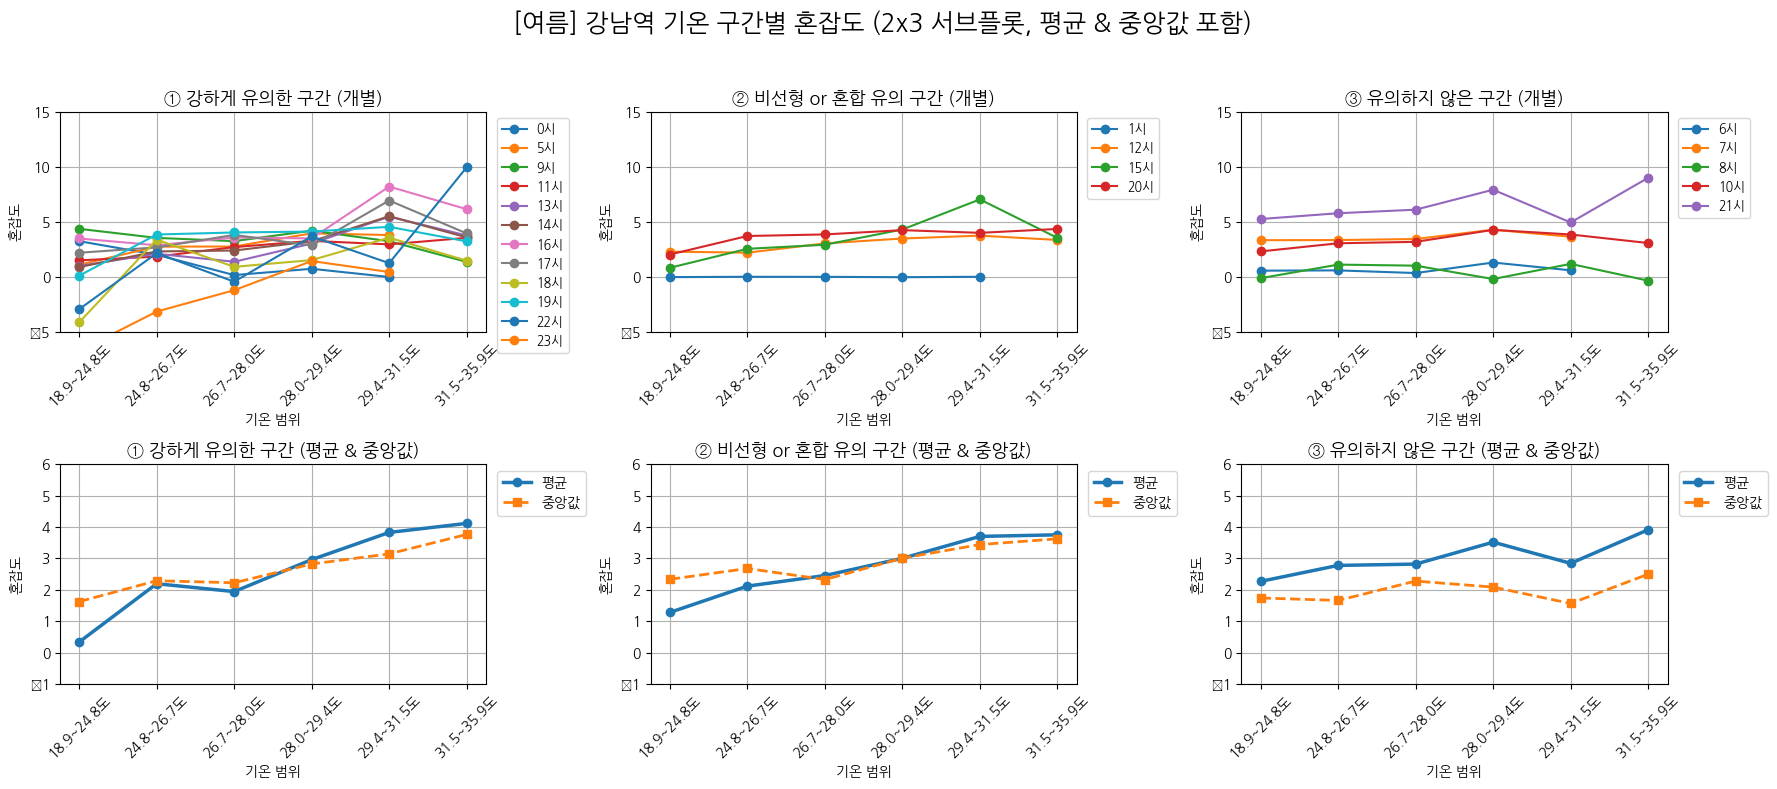

In [249]:
from scipy.stats import pearsonr, spearmanr

clim = 'ta_chi'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = quantiles.values
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}도' for i in range(len(bins)-1)]
# 중복 제거된 분위수 경계값 얻기
unique_bins = np.unique(quantiles.values)

# 라벨도 새로 생성
labels = [f'{round(unique_bins[i],1)}~{round(unique_bins[i+1],1)}도' for i in range(len(unique_bins)-1)]

# 구간 분류
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=unique_bins, labels=labels, include_lowest=True)

groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 설정
ylim = (-5, 15)
ylim2 = (-1, 6)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("체감온도 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("체감온도 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 체감온도 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🔴 강수량(시간별) vs 시간대 혼잡도 비교


📊 [강남] 시간대별 'rn_hr1' vs 혼잡도 상관계수 분석
 0시 (n=184): Pearson r=+0.005 (p=0.9470, 🔹 약함) | Spearman ρ=-0.121 (p=0.1006, 🔹 약함) → ✖✖ 무유의
 1시 (n=184): Pearson r=+0.021 (p=0.7789, 🔹 약함) | Spearman ρ=-0.028 (p=0.7051, 🔹 약함) → ✖✖ 무유의
 5시 (n=184): Pearson r=-0.263 (p=0.0003, 📉 보통) | Spearman ρ=-0.285 (p=0.0001, 📉 보통) → ✔✔ 모두 유의
 6시 (n=184): Pearson r=-0.140 (p=0.0584, 🔹 약함) | Spearman ρ=-0.290 (p=0.0001, 📉 보통) → ✔❌ 한쪽만 유의
 7시 (n=184): Pearson r=-0.104 (p=0.1580, 🔹 약함) | Spearman ρ=-0.085 (p=0.2486, 🔹 약함) → ✖✖ 무유의
 8시 (n=184): Pearson r=-0.046 (p=0.5344, 🔹 약함) | Spearman ρ=-0.107 (p=0.1492, 🔹 약함) → ✖✖ 무유의
 9시 (n=184): Pearson r=-0.021 (p=0.7801, 🔹 약함) | Spearman ρ=-0.050 (p=0.5028, 🔹 약함) → ✖✖ 무유의
10시 (n=184): Pearson r=-0.140 (p=0.0571, 🔹 약함) | Spearman ρ=-0.124 (p=0.0934, 🔹 약함) → ✖✖ 무유의
11시 (n=184): Pearson r=-0.258 (p=0.0004, 📉 보통) | Spearman ρ=-0.238 (p=0.0011, 📉 보통) → ✔✔ 모두 유의
12시 (n=184): Pearson r=-0.176 (p=0.0166, 🔹 약함) | Spearman ρ=-0.286 (p=0.0001, 📉 보통) → ✔✔ 모두 유의
13시 (n=184): Pearson r=-

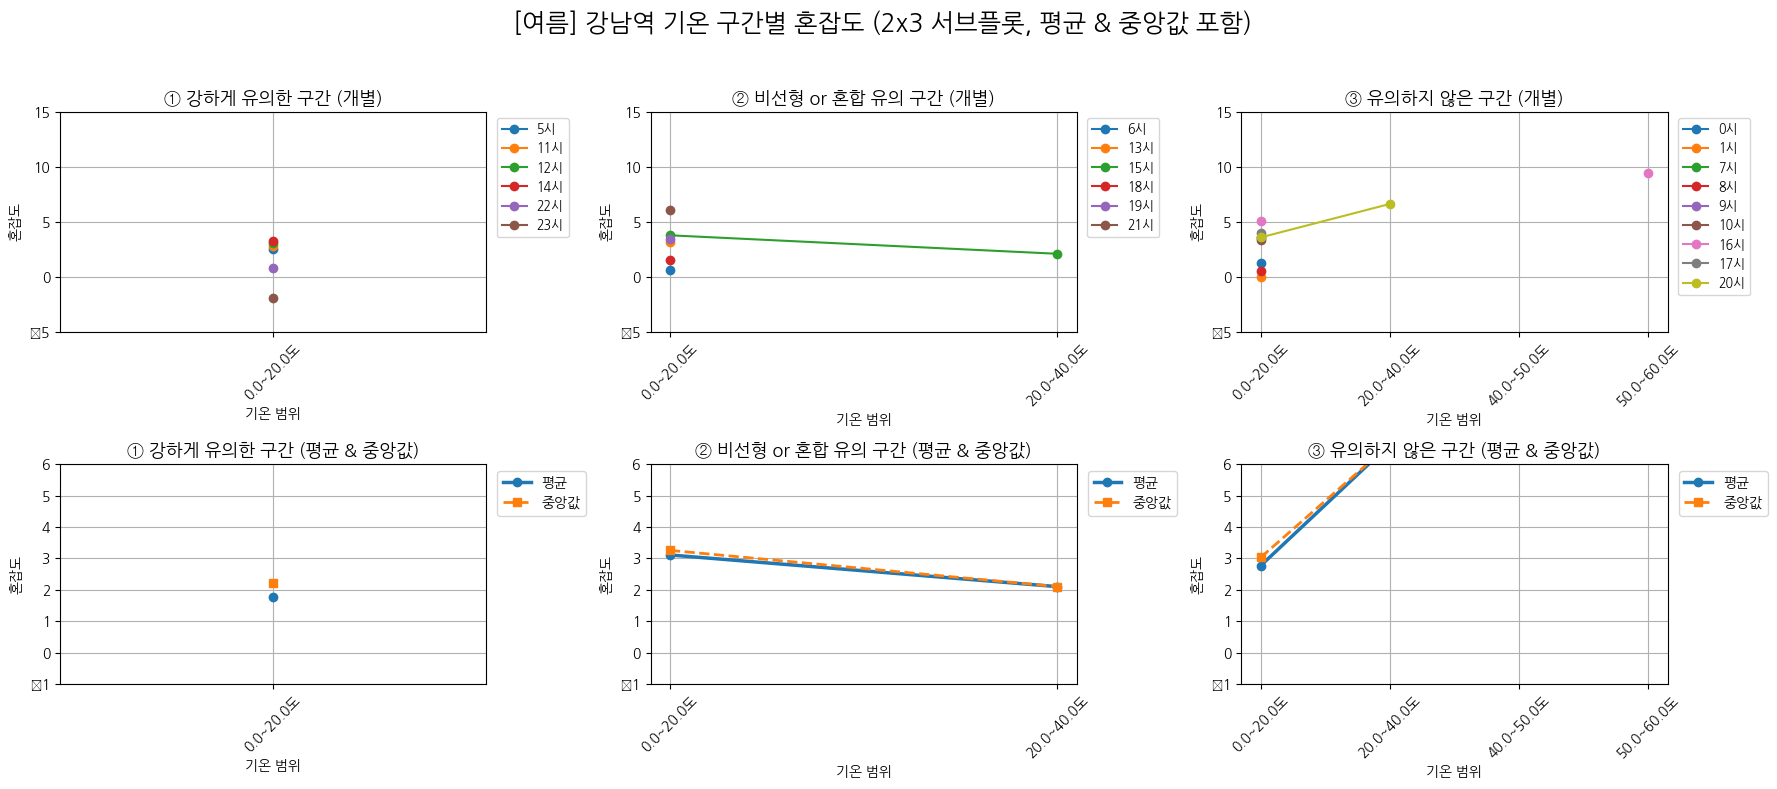

In [252]:
from scipy.stats import pearsonr, spearmanr

clim = 'rn_hr1'
alpha = 0.05  # 유의수준
group_1, group_2, group_3 = [], [], []

# 상관 강도 구분 함수
def strength(r):
    abs_r = abs(r)
    if abs_r >= 0.7:
        return "📈 매우 강함"
    elif abs_r >= 0.4:
        return "📊 강함"
    elif abs_r >= 0.2:
        return "📉 보통"
    else:
        return "🔹 약함"

print(f"\n📊 [{selected_station}] 시간대별 '{clim}' vs 잔차혼잡도 상관계수 분석")
print("=" * 85)

unique_hours = sorted(df_summer['m_hr1'].unique())

for hr in unique_hours:
    sub = df_summer[df_summer['m_hr1'] == hr][[clim, 'residual']].dropna()
    if len(sub) >= 3:
        r_pear, p_pear = pearsonr(sub[clim], sub['residual'])
        r_spear, p_spear = spearmanr(sub[clim], sub['residual'])

        strength_pear = strength(r_pear)
        strength_spear = strength(r_spear)

        # 그룹 분류
        if p_pear < alpha and p_spear < alpha:
            group_1.append(hr)
            sig_status = "✔✔ 모두 유의"
        elif p_pear < alpha or p_spear < alpha:
            group_2.append(hr)
            sig_status = "✔❌ 한쪽만 유의"
        else:
            group_3.append(hr)
            sig_status = "✖✖ 무유의"

        print(f"{hr:>2}시 (n={len(sub):>3}): "
              f"Pearson r={r_pear:+.3f} (p={p_pear:.4f}, {strength_pear}) | "
              f"Spearman ρ={r_spear:+.3f} (p={p_spear:.4f}, {strength_spear}) → {sig_status}")
    else:
        print(f"{hr:>2}시: 데이터 부족 (n={len(sub)})")

# ✅ 요약 출력
print("\n🧮 그룹 요약")
print(f"① 모두 유의한 시간대: {sorted(group_1)}")
print(f"② 한쪽만 유의한 시간대: {sorted(group_2)}")
print(f"③ 둘 다 무유의한 시간대: {sorted(group_3)}")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 기온 구간 설정 (분위수 기반)

quantiles = df_summer[clim].quantile(np.linspace(0, 1, 7))
bins = [0,20,40,50,60,np.inf]
labels = [f'{round(bins[i],1)}~{round(bins[i+1],1)}mm' for i in range(len(bins)-1)]
# 중복 제거된 분위수 경계값 얻기
unique_bins = np.unique(bins)

# 라벨도 새로 생성
labels = [f'{round(unique_bins[i],1)}~{round(unique_bins[i+1],1)}mm' for i in range(len(unique_bins)-1)]

# 구간 분류
df_summer['temp_range'] = pd.cut(df_summer[clim], bins=unique_bins, labels=labels, include_lowest=True)

groups = {
    "① 강하게 유의한 구간": group_1,
    "② 비선형 or 혼합 유의 구간": group_2,
    "③ 유의하지 않은 구간": group_3,
}

# ✅ y축 범위 설정
ylim = (-5, 15)
ylim2 = (-1, 6)

# ✅ 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# (1행) 개별
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[0][idx]
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        avg_by_temp = sub.groupby('temp_range')['residual'].mean()
        ax.plot(avg_by_temp.index, avg_by_temp.values, marker='o', label=f"{hr}시")
    ax.set_title(f"{group_name} (개별)", fontsize=13)
    ax.set_xlabel("시간 강수량 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim)
    ax.grid(True)
    ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

# (2행) 평균+중앙값
for idx, (group_name, group_hours) in enumerate(groups.items()):
    ax = axes[1][idx]
    temp_avg_all, temp_median_all = [], []
    for hr in group_hours:
        sub = df_summer[df_summer['m_hr1'] == hr]
        group_by_temp = sub.groupby('temp_range')['residual']
        temp_avg_all.append(group_by_temp.mean())
        temp_median_all.append(group_by_temp.median())
    temp_avg_df = pd.concat(temp_avg_all, axis=1).mean(axis=1)
    temp_median_df = pd.concat(temp_median_all, axis=1).median(axis=1)

    ax.plot(temp_avg_df.index, temp_avg_df.values, marker='o', linewidth=2.5, label="평균")
    ax.plot(temp_median_df.index, temp_median_df.values, marker='s', linestyle='--', linewidth=2, label="중앙값")
    ax.set_title(f"{group_name} (평균 & 중앙값)", fontsize=13)
    ax.set_xlabel("시간 강수량 범위")
    ax.set_ylabel("잔차혼잡도")
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(ylim2)
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))  # 🔄 범례 위치 수정

plt.suptitle(f"[여름] {selected_station}역 시간 강수량 구간별 잔차혼잡도 (2x3 서브플롯, 평균 & 중앙값 포함)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

🔴 기상변수 vs 시간대별 혼잡도 서브플롯 분석
📊 데이터 로드 중...
  로드 중: C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway23.csv
✅ 전체 데이터: 5,520,981개

🚨 결측치 처리 중...
rn_day: -99 값 4개를 NaN으로 변환
ws: -99 값 6개를 NaN으로 변환
rn_hr1: -99 값 6개를 NaN으로 변환
hm: -99 값 4개를 NaN으로 변환
si: -99 값 1,108개를 NaN으로 변환
ta_chi: -99 값 0개를 NaN으로 변환
ta: -99 값 4개를 NaN으로 변환
wd: -99 값 6개를 NaN으로 변환

🌙 일사량 야간시간대 처리 중...
야간시간대([0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]) 일사량 결측값 1,108개를 0으로 설정

📊 데이터 기본 정보:
  전체 데이터: 3,864개
  시간대 범위: 0시 ~ 23시
  혼잡도 범위: -38.3 ~ 39.4
  평균 혼잡도: 2.58

📊 기상변수 결측치:
  ta: 4개 (0.1%)
  hm: 4개 (0.1%)
  ws: 6개 (0.2%)
  rn_hr1: 6개 (0.2%)
  rn_day: 4개 (0.1%)
  si: 0개 (0.0%)
  ta_chi: 0개 (0.0%)
  wd: 6개 (0.2%)

🔴 기상변수 vs 시간대별 혼잡도 분석
📊 분석 대상 기상변수: ['ta', 'hm', 'ws', 'rn_hr1', 'rn_day', 'si', 'ta_chi', 'wd']

📈 기온 (°C) 분석 중...
  전체 상관계수: 0.228
  최강 상관관계: 23시 (0.393)

📈 습도 (%) 분석 중...
  전체 상관계수: -0.171
  최강 상관관계: 12시 (-0.251)

📈 풍속 (m/s) 분석 중...
  전체 상관계수: 0.030
  최강 상관관계: 22시 (-0.299)

📈 시간강수량 (mm) 분석 중...
  전체 상관계수: -0.

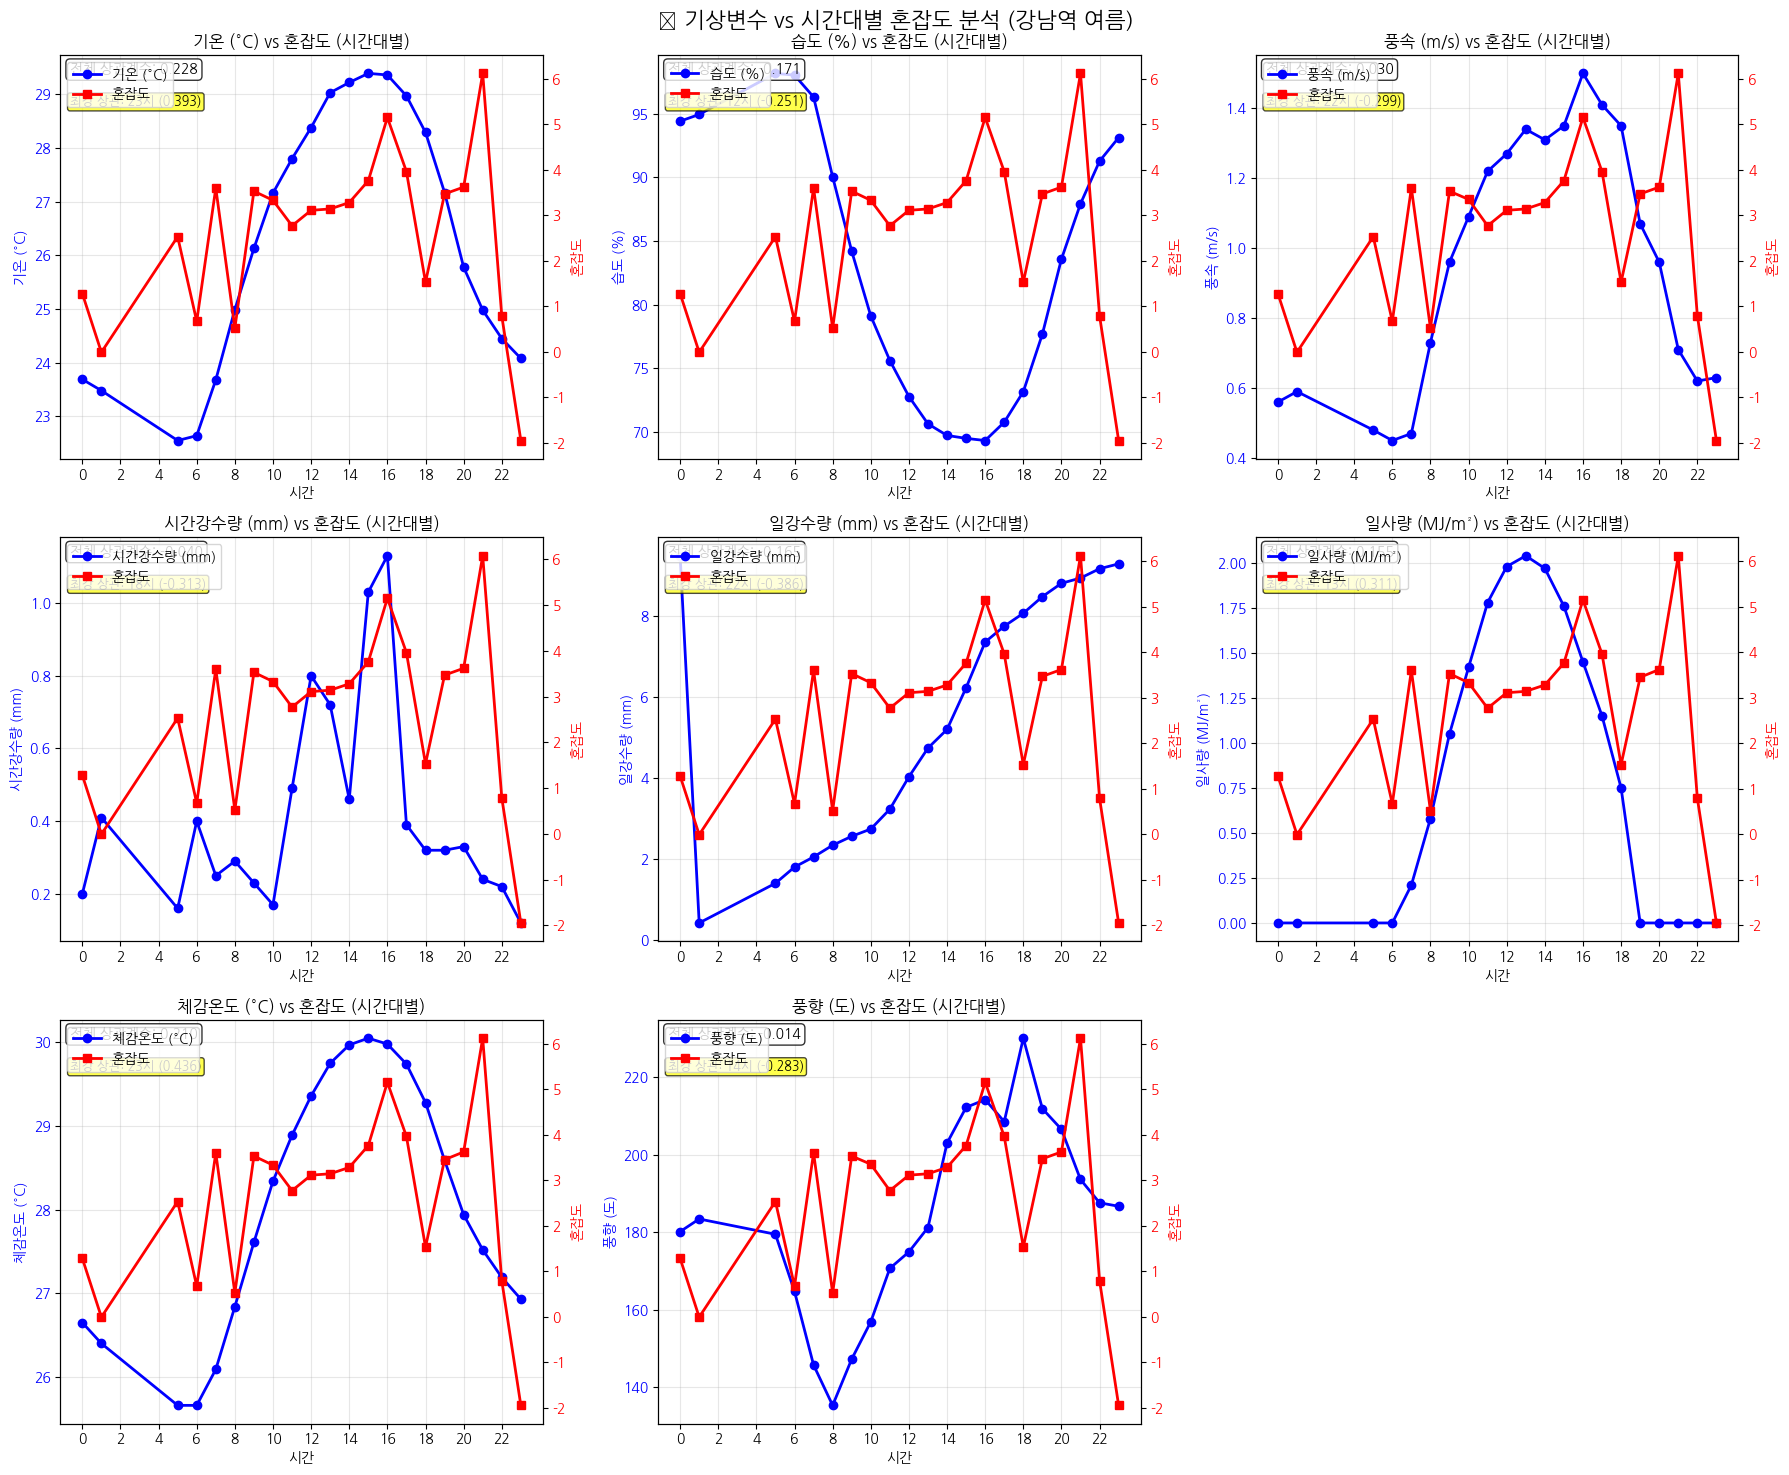


📊 상세 분석 그래프 생성 중...


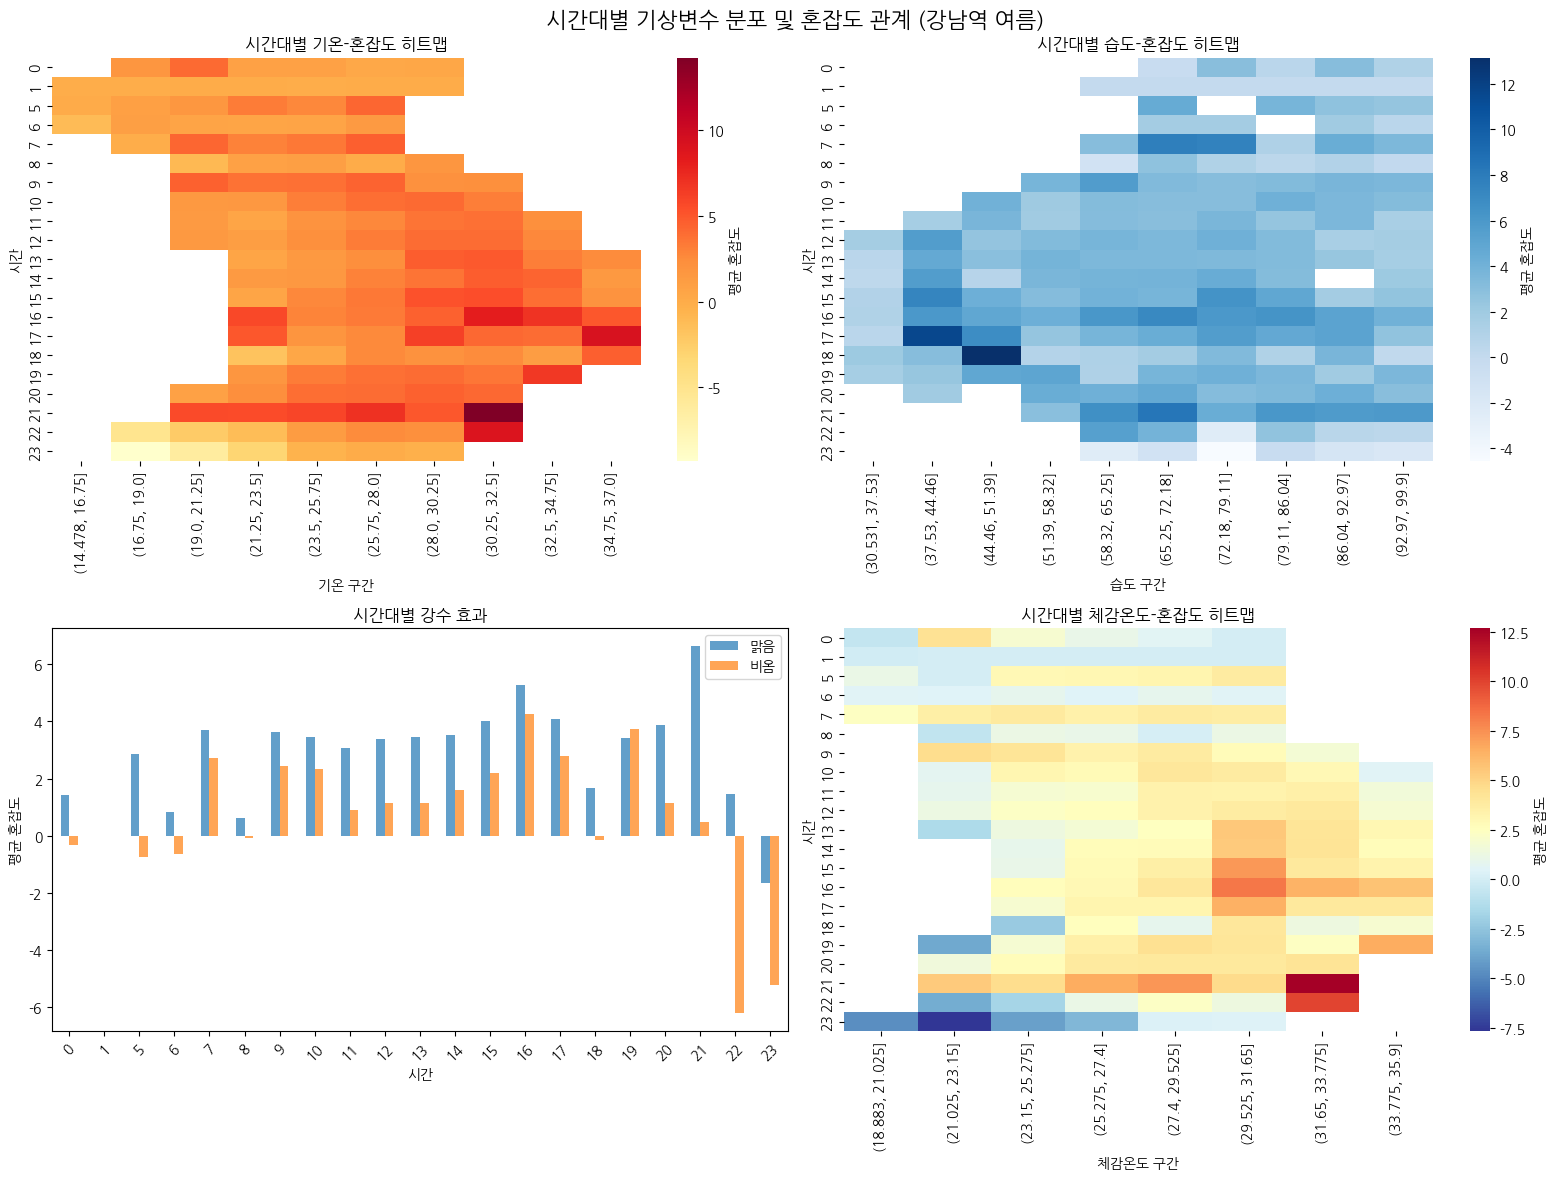


🌪️ 극한 기상 조건 분석...


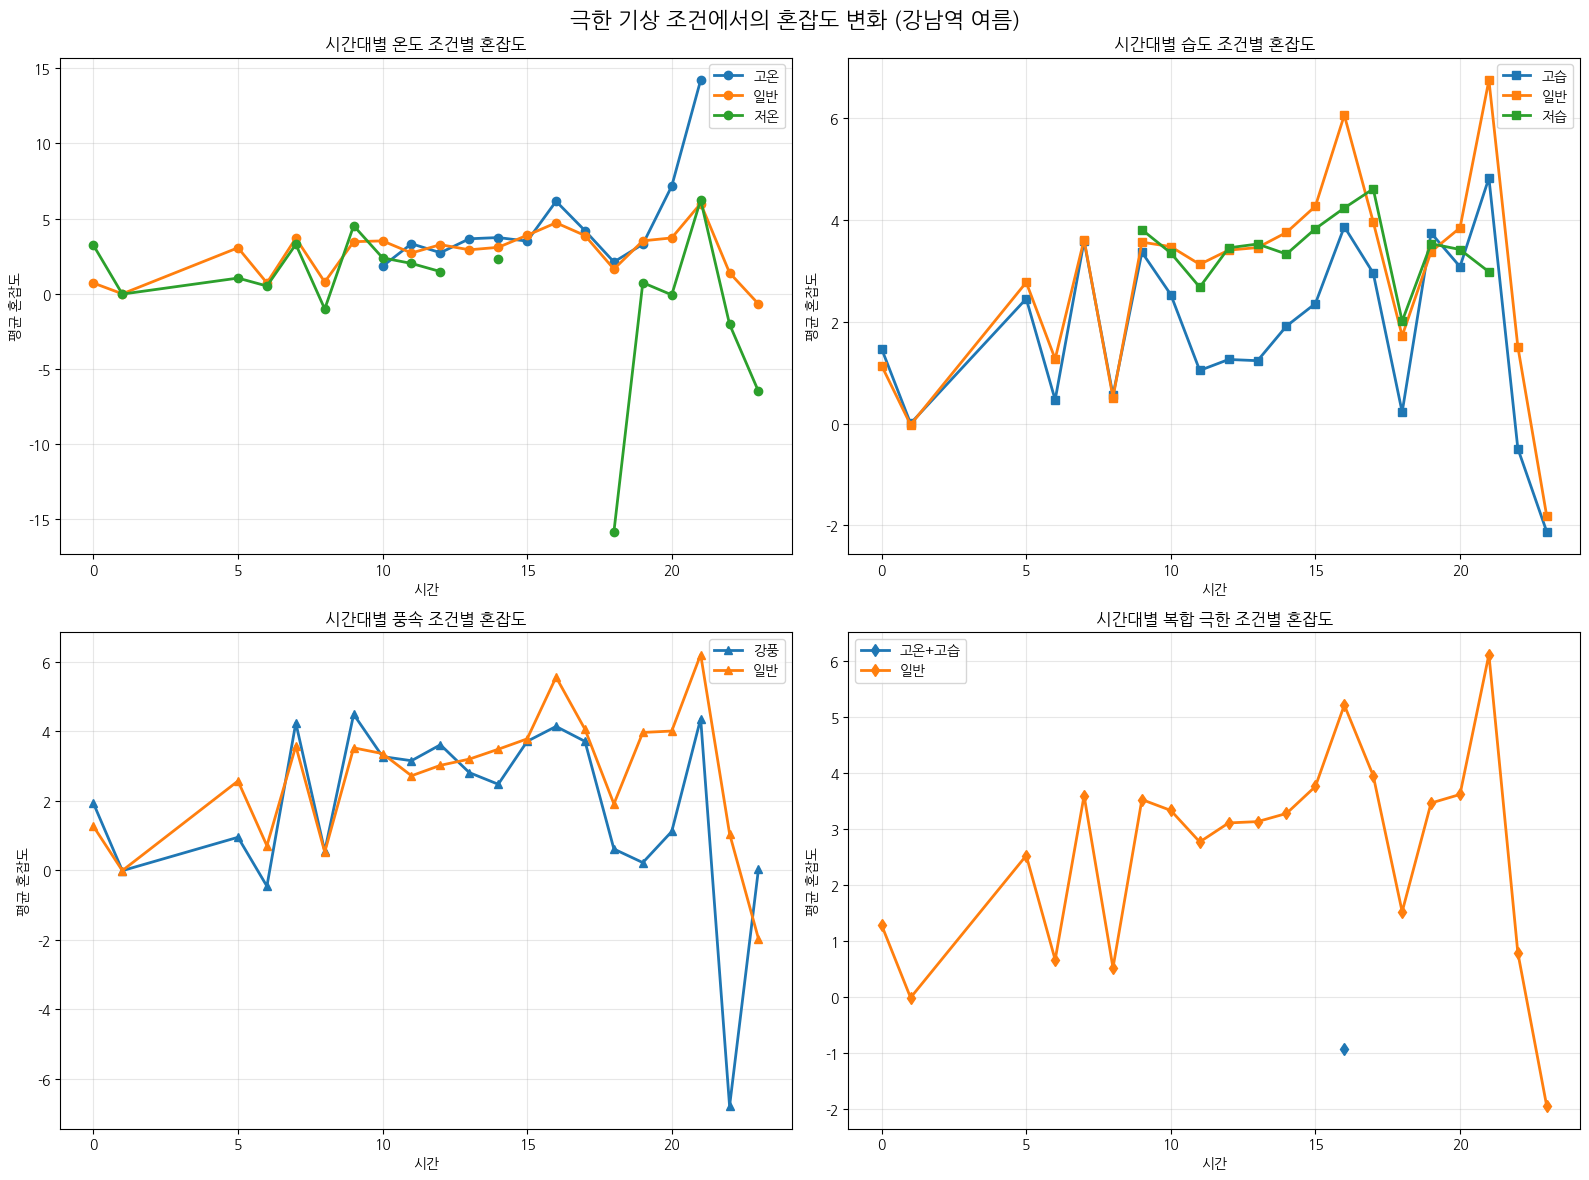


✅ 분석 완료!
📁 결과 파일:
  - weather_time_subplot_analysis.png
  - detailed_weather_analysis.png
  - extreme_weather_analysis.png


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import os
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 또는 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

def load_data():
    """데이터 로드 및 기본 전처리"""
    print("📊 데이터 로드 중...")
    
    # 사용자가 제공한 데이터 경로
    data_path = r'C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway23.csv'
    
    if not os.path.exists(data_path):
        print(f"❌ 데이터 파일을 찾을 수 없습니다: {data_path}")
        return None
    
    print(f"  로드 중: {data_path}")
    df = pd.read_csv(data_path, encoding='cp949')
    
    # 컬럼명 매핑 (사용자가 제공한 구조)
    column_mapping = {
        'train_subway23.tm': 'tm',
        'train_subway23.line': 'line',
        'train_subway23.station_number': 'station_number',
        'train_subway23.station_name': 'station_name',
        'train_subway23.direction': 'direction',
        'train_subway23.stn': 'stn',
        'train_subway23.ta': 'ta',
        'train_subway23.wd': 'wd',
        'train_subway23.ws': 'ws',
        'train_subway23.rn_day': 'rn_day',
        'train_subway23.rn_hr1': 'rn_hr1',
        'train_subway23.hm': 'hm',
        'train_subway23.si': 'si',
        'train_subway23.ta_chi': 'ta_chi',
        'train_subway23.congestion': 'congestion'
    }
    df = df.rename(columns=column_mapping)
    
    print(f"✅ 전체 데이터: {len(df):,}개")
    
    # 시간 정보 추출
    df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    df['m_hr1'] = df['datetime'].dt.hour  # 시간
    df['month'] = df['datetime'].dt.month  # 달
    df['dayofweek'] = df['datetime'].dt.dayofweek  # 요일 0 = 월요일, 6 = 일요일
    
    # 여름 데이터만 필터링 (6-8월) + 강남역
    selected_station = '강남'
    summer_df = df[(df['month'].isin([6,7,8])) & (df['station_name'] == selected_station)].copy()

    # 예측 결과 불러오기
    df_pred = pd.read_csv(r"C:\Users\COEL_03\Desktop\CLIMAX-main\pred_result_hour_only.csv") #경로에 맞게
    # 인덱스를 리셋해서 0부터 맞춰줌
    summer_df = summer_df.reset_index(drop=True)
    df_pred = df_pred.reset_index(drop=True)

    # 같은 순서로 예측값 삽입
    summer_df['predicted_congestion'] = df_pred['congestion2']
    summer_df['residual'] = summer_df['congestion'] - summer_df['predicted_congestion']



    # 결측치 처리 (-99를 NaN으로 변환)
    print("\n🚨 결측치 처리 중...")
    weather_cols = ['rn_day', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi', 'ta', 'wd']
    for col in weather_cols:
        if col in summer_df.columns:
            before_count = (summer_df[col] == -99).sum()
            summer_df[col] = summer_df[col].replace(-99, np.nan)
            print(f"{col}: -99 값 {before_count:,}개를 NaN으로 변환")
    
    if 'wd' in summer_df.columns:
        summer_df['wd'] = summer_df['wd'].replace(-9.9, np.nan)
    
    # 일사량 야간시간대 물리적 처리
    print("\n🌙 일사량 야간시간대 처리 중...")
    night_hours = [0, 1, 2, 3, 4, 5, 6, 19, 20, 21, 22, 23]
    night_mask = summer_df['m_hr1'].isin(night_hours)
    if 'si' in summer_df.columns:
        night_si_missing = summer_df.loc[night_mask, 'si'].isnull().sum()
        summer_df.loc[night_mask, 'si'] = 0.0
        print(f"야간시간대({night_hours}) 일사량 결측값 {night_si_missing:,}개를 0으로 설정")
    
    return summer_df

def create_weather_time_subplots(df):
    """🔴 기상변수 vs 시간대별 혼잡도 서브플롯 생성"""
    print("\n🔴 기상변수 vs 시간대별 혼잡도 분석")
    print("=" * 60)
    
    # 기상변수 정의 (사용자 데이터 구조에 맞게)
    weather_vars = {
        'ta': '기온 (°C)',
        'hm': '습도 (%)', 
        'ws': '풍속 (m/s)',
        'rn_hr1': '시간강수량 (mm)',
        'rn_day': '일강수량 (mm)',
        'si': '일사량 (MJ/m²)',
        'ta_chi': '체감온도 (°C)',
        'wd': '풍향 (도)'
    }
    
    # 사용 가능한 기상변수만 필터링
    available_weather_vars = {k: v for k, v in weather_vars.items() if k in df.columns}
    print(f"📊 분석 대상 기상변수: {list(available_weather_vars.keys())}")
    
    # 서브플롯 레이아웃 계산
    n_vars = len(available_weather_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    # 큰 서브플롯 생성
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    fig.suptitle('🔴 기상변수 vs 시간대별 혼잡도 분석 (강남역 여름)', fontsize=16, fontweight='bold')
    
    # 1차원 배열로 변환 (단일 행인 경우)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # 각 기상변수별 분석
    for idx, (var, var_name) in enumerate(available_weather_vars.items()):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        print(f"\n📈 {var_name} 분석 중...")
        
        # 결측치 제거
        clean_data = df[[var, 'm_hr1', 'residual']].dropna()
        
        if len(clean_data) == 0:
            ax.text(0.5, 0.5, f'{var_name}\n데이터 없음', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_title(f'{var_name} vs 혼잡도')
            continue
        
        # 시간대별 평균 계산
        hourly_stats = clean_data.groupby('m_hr1').agg({
            var: ['mean', 'std'],
            'residual': ['mean', 'std']
        }).round(2)
        
        # 시간대별 기상변수 평균과 혼잡도 평균
        hours = hourly_stats.index
        weather_means = hourly_stats[(var, 'mean')]
        congestion_means = hourly_stats[('residual', 'mean')]
        
        # 이중 Y축 그래프
        ax2 = ax.twinx()
        
        # 기상변수 (왼쪽 Y축)
        line1 = ax.plot(hours, weather_means, 'b-o', linewidth=2, markersize=6, 
                       label=var_name, color='blue')
        ax.set_xlabel('시간')
        ax.set_ylabel(var_name, color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        
        # 혼잡도 (오른쪽 Y축)
        line2 = ax2.plot(hours, congestion_means, 'r-s', linewidth=2, markersize=6,
                        label='혼잡도', color='red')
        ax2.set_ylabel('혼잡도', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # 제목과 그리드
        ax.set_title(f'{var_name} vs 혼잡도 (시간대별)', fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xticks(range(0, 24, 2))
        
        # 범례 (두 축의 선을 합쳐서 표시)
        lines = line1 + line2
        labels = [var_name, '혼잡도']
        ax.legend(lines, labels, loc='upper right')
        
        # 상관계수 계산 및 표시
        overall_corr = clean_data[var].corr(clean_data['residual'])
        ax.text(0.02, 0.98, f'전체 상관계수: {overall_corr:.3f}', 
               transform=ax.transAxes, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
               verticalalignment='top')
        
        print(f"  전체 상관계수: {overall_corr:.3f}")
        
        # 시간대별 상관계수 계산
        hourly_corrs = []
        for hour in range(24):
            hour_data = clean_data[clean_data['m_hr1'] == hour]
            if len(hour_data) > 10:  # 최소 10개 이상 데이터
                corr = hour_data[var].corr(hour_data['residual'])
                hourly_corrs.append(corr if not np.isnan(corr) else 0)
            else:
                hourly_corrs.append(0)
        
        # 가장 강한 상관관계 시간대 찾기
        max_corr_idx = np.argmax([abs(corr) for corr in hourly_corrs])
        max_corr = hourly_corrs[max_corr_idx]
        
        ax.text(0.02, 0.90, f'최강 상관: {max_corr_idx}시 ({max_corr:.3f})', 
               transform=ax.transAxes, fontsize=9,
               bbox=dict(boxstyle="round,pad=0.2", facecolor="yellow", alpha=0.7),
               verticalalignment='top')
        
        print(f"  최강 상관관계: {max_corr_idx}시 ({max_corr:.3f})")
    
    # 빈 서브플롯 숨기기
    for idx in range(len(available_weather_vars), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    
    # 저장 및 표시
    plt.savefig('../result/weather_time_subplot_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return available_weather_vars

def create_detailed_analysis(df, weather_vars):
    """상세 분석 그래프들"""
    print("\n📊 상세 분석 그래프 생성 중...")
    
    # 1. 시간대별 기상변수 분포 히트맵
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('시간대별 기상변수 분포 및 혼잡도 관계 (강남역 여름)', fontsize=16, fontweight='bold')
    
    # 1-1. 기온 히트맵
    if 'ta' in df.columns:
        ax = axes[0, 0]
        temp_data = df[['m_hr1', 'ta', 'residual']].dropna()
        if len(temp_data) > 0:
            # 기온 구간별로 그룹화
            temp_data['temp_bin'] = pd.cut(temp_data['ta'], bins=10)
            heatmap_data = temp_data.groupby(['m_hr1', 'temp_bin'])['residual'].mean().unstack()
            
            sns.heatmap(heatmap_data, ax=ax, cmap='YlOrRd', cbar_kws={'label': '평균 혼잡도'})
            ax.set_title('시간대별 기온-혼잡도 히트맵')
            ax.set_xlabel('기온 구간')
            ax.set_ylabel('시간')
    
    # 1-2. 습도 히트맵
    if 'hm' in df.columns:
        ax = axes[0, 1]
        humidity_data = df[['m_hr1', 'hm', 'residual']].dropna()
        if len(humidity_data) > 0:
            humidity_data['humidity_bin'] = pd.cut(humidity_data['hm'], bins=10)
            heatmap_data = humidity_data.groupby(['m_hr1', 'humidity_bin'])['residual'].mean().unstack()
            
            sns.heatmap(heatmap_data, ax=ax, cmap='Blues', cbar_kws={'label': '평균 혼잡도'})
            ax.set_title('시간대별 습도-혼잡도 히트맵')
            ax.set_xlabel('습도 구간')
            ax.set_ylabel('시간')
    
    # 1-3. 강수량 효과
    if 'rn_hr1' in df.columns:
        ax = axes[1, 0]
        rain_data = df[['m_hr1', 'rn_hr1', 'residual']].dropna()
        if len(rain_data) > 0:
            # 비가 오는 시간 vs 안 오는 시간
            rain_data['is_rainy'] = rain_data['rn_hr1'] > 0
            rain_effect = rain_data.groupby(['m_hr1', 'is_rainy'])['residual'].mean().unstack()
            
            if len(rain_effect.columns) == 2:
                rain_effect.plot(kind='bar', ax=ax, alpha=0.7)
                ax.set_title('시간대별 강수 효과')
                ax.set_xlabel('시간')
                ax.set_ylabel('평균 혼잡도')
                ax.legend(['맑음', '비옴'])
                ax.tick_params(axis='x', rotation=45)
    
    # 1-4. 체감온도 효과
    if 'ta_chi' in df.columns:
        ax = axes[1, 1]
        apparent_temp_data = df[['m_hr1', 'ta_chi', 'residual']].dropna()
        if len(apparent_temp_data) > 0:
            # 체감온도 구간별
            apparent_temp_data['temp_chi_bin'] = pd.cut(apparent_temp_data['ta_chi'], bins=8)
            temp_chi_effect = apparent_temp_data.groupby(['m_hr1', 'temp_chi_bin'])['residual'].mean().unstack()
            
            sns.heatmap(temp_chi_effect, ax=ax, cmap='RdYlBu_r', cbar_kws={'label': '평균 혼잡도'})
            ax.set_title('시간대별 체감온도-혼잡도 히트맵')
            ax.set_xlabel('체감온도 구간')
            ax.set_ylabel('시간')
    
    plt.tight_layout()
    plt.savefig('../result/detailed_weather_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. 극한 기상 조건 분석
    print("\n🌪️ 극한 기상 조건 분석...")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('극한 기상 조건에서의 혼잡도 변화 (강남역 여름)', fontsize=16, fontweight='bold')
    
    # 2-1. 고온/저온 효과
    if 'ta' in df.columns:
        ax = axes[0, 0]
        temp_data = df[['m_hr1', 'ta', 'residual']].dropna()
        if len(temp_data) > 0:
            # 고온(상위 10%), 저온(하위 10%), 일반 조건
            temp_high = temp_data['ta'].quantile(0.9)
            temp_low = temp_data['ta'].quantile(0.1)
            
            temp_data['temp_condition'] = '일반'
            temp_data.loc[temp_data['ta'] >= temp_high, 'temp_condition'] = '고온'
            temp_data.loc[temp_data['ta'] <= temp_low, 'temp_condition'] = '저온'
            
            temp_effect = temp_data.groupby(['m_hr1', 'temp_condition'])['residual'].mean().unstack()
            temp_effect.plot(kind='line', ax=ax, marker='o', linewidth=2)
            ax.set_title('시간대별 온도 조건별 혼잡도')
            ax.set_xlabel('시간')
            ax.set_ylabel('평균 혼잡도')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # 2-2. 고습/저습 효과
    if 'hm' in df.columns:
        ax = axes[0, 1]
        humidity_data = df[['m_hr1', 'hm', 'residual']].dropna()
        if len(humidity_data) > 0:
            humidity_high = humidity_data['hm'].quantile(0.9)
            humidity_low = humidity_data['hm'].quantile(0.1)
            
            humidity_data['humidity_condition'] = '일반'
            humidity_data.loc[humidity_data['hm'] >= humidity_high, 'humidity_condition'] = '고습'
            humidity_data.loc[humidity_data['hm'] <= humidity_low, 'humidity_condition'] = '저습'
            
            humidity_effect = humidity_data.groupby(['m_hr1', 'humidity_condition'])['residual'].mean().unstack()
            humidity_effect.plot(kind='line', ax=ax, marker='s', linewidth=2)
            ax.set_title('시간대별 습도 조건별 혼잡도')
            ax.set_xlabel('시간')
            ax.set_ylabel('평균 혼잡도')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # 2-3. 강풍 효과
    if 'ws' in df.columns:
        ax = axes[1, 0]
        wind_data = df[['m_hr1', 'ws', 'residual']].dropna()
        if len(wind_data) > 0:
            wind_high = wind_data['ws'].quantile(0.9)
            
            wind_data['wind_condition'] = '일반'
            wind_data.loc[wind_data['ws'] >= wind_high, 'wind_condition'] = '강풍'
            
            wind_effect = wind_data.groupby(['m_hr1', 'wind_condition'])['residual'].mean().unstack()
            wind_effect.plot(kind='line', ax=ax, marker='^', linewidth=2)
            ax.set_title('시간대별 풍속 조건별 혼잡도')
            ax.set_xlabel('시간')
            ax.set_ylabel('평균 혼잡도')
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    # 2-4. 복합 극한 조건
    ax = axes[1, 1]
    complex_data = df[['m_hr1', 'ta', 'hm', 'residual']].dropna()
    if len(complex_data) > 0:
        # 고온+고습 조건
        temp_high = complex_data['ta'].quantile(0.8)
        humidity_high = complex_data['hm'].quantile(0.8)
        
        complex_data['extreme_condition'] = '일반'
        extreme_mask = (complex_data['ta'] >= temp_high) & (complex_data['hm'] >= humidity_high)
        complex_data.loc[extreme_mask, 'extreme_condition'] = '고온+고습'
        
        extreme_effect = complex_data.groupby(['m_hr1', 'extreme_condition'])['residual'].mean().unstack()
        extreme_effect.plot(kind='line', ax=ax, marker='d', linewidth=2)
        ax.set_title('시간대별 복합 극한 조건별 혼잡도')
        ax.set_xlabel('시간')
        ax.set_ylabel('평균 혼잡도')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../result/extreme_weather_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    """메인 실행 함수"""
    print("🔴 기상변수 vs 시간대별 혼잡도 서브플롯 분석")
    print("=" * 60)
    
    # 데이터 로드
    df = load_data()
    if df is None:
        return
    
    # 기본 통계 출력
    print(f"\n📊 데이터 기본 정보:")
    print(f"  전체 데이터: {len(df):,}개")
    print(f"  시간대 범위: {df['m_hr1'].min()}시 ~ {df['m_hr1'].max()}시")
    print(f"  혼잡도 범위: {df['residual'].min():.1f} ~ {df['residual'].max():.1f}")
    print(f"  평균 혼잡도: {df['residual'].mean():.2f}")
    
    # 기상변수별 결측치 확인
    weather_cols = ['ta', 'hm', 'ws', 'rn_hr1', 'rn_day', 'si', 'ta_chi', 'wd']
    print(f"\n📊 기상변수 결측치:")
    for col in weather_cols:
        if col in df.columns:
            missing = df[col].isnull().sum()
            missing_pct = missing / len(df) * 100
            print(f"  {col}: {missing:,}개 ({missing_pct:.1f}%)")
    
    # 1. 메인 서브플롯 분석
    weather_vars = create_weather_time_subplots(df)
    
    # 2. 상세 분석
    create_detailed_analysis(df, weather_vars)
    
    print(f"\n✅ 분석 완료!")
    print(f"📁 결과 파일:")
    print(f"  - weather_time_subplot_analysis.png")
    print(f"  - detailed_weather_analysis.png") 
    print(f"  - extreme_weather_analysis.png")

if __name__ == "__main__":
    main()

📊 데이터 로드 중...
✅ 여름 강남역 데이터: 3,864개
✅ 잔차(residual) 컬럼 생성 완료

📈 시간대별 기상-잔차 산점도(Scatter Plot) 생성 시작...

Processing Weather Variable: 기온 (°C)
  ✅ 그래프 저장 완료: ../result/scatter_residual_vs_ta_by_all_hours.png


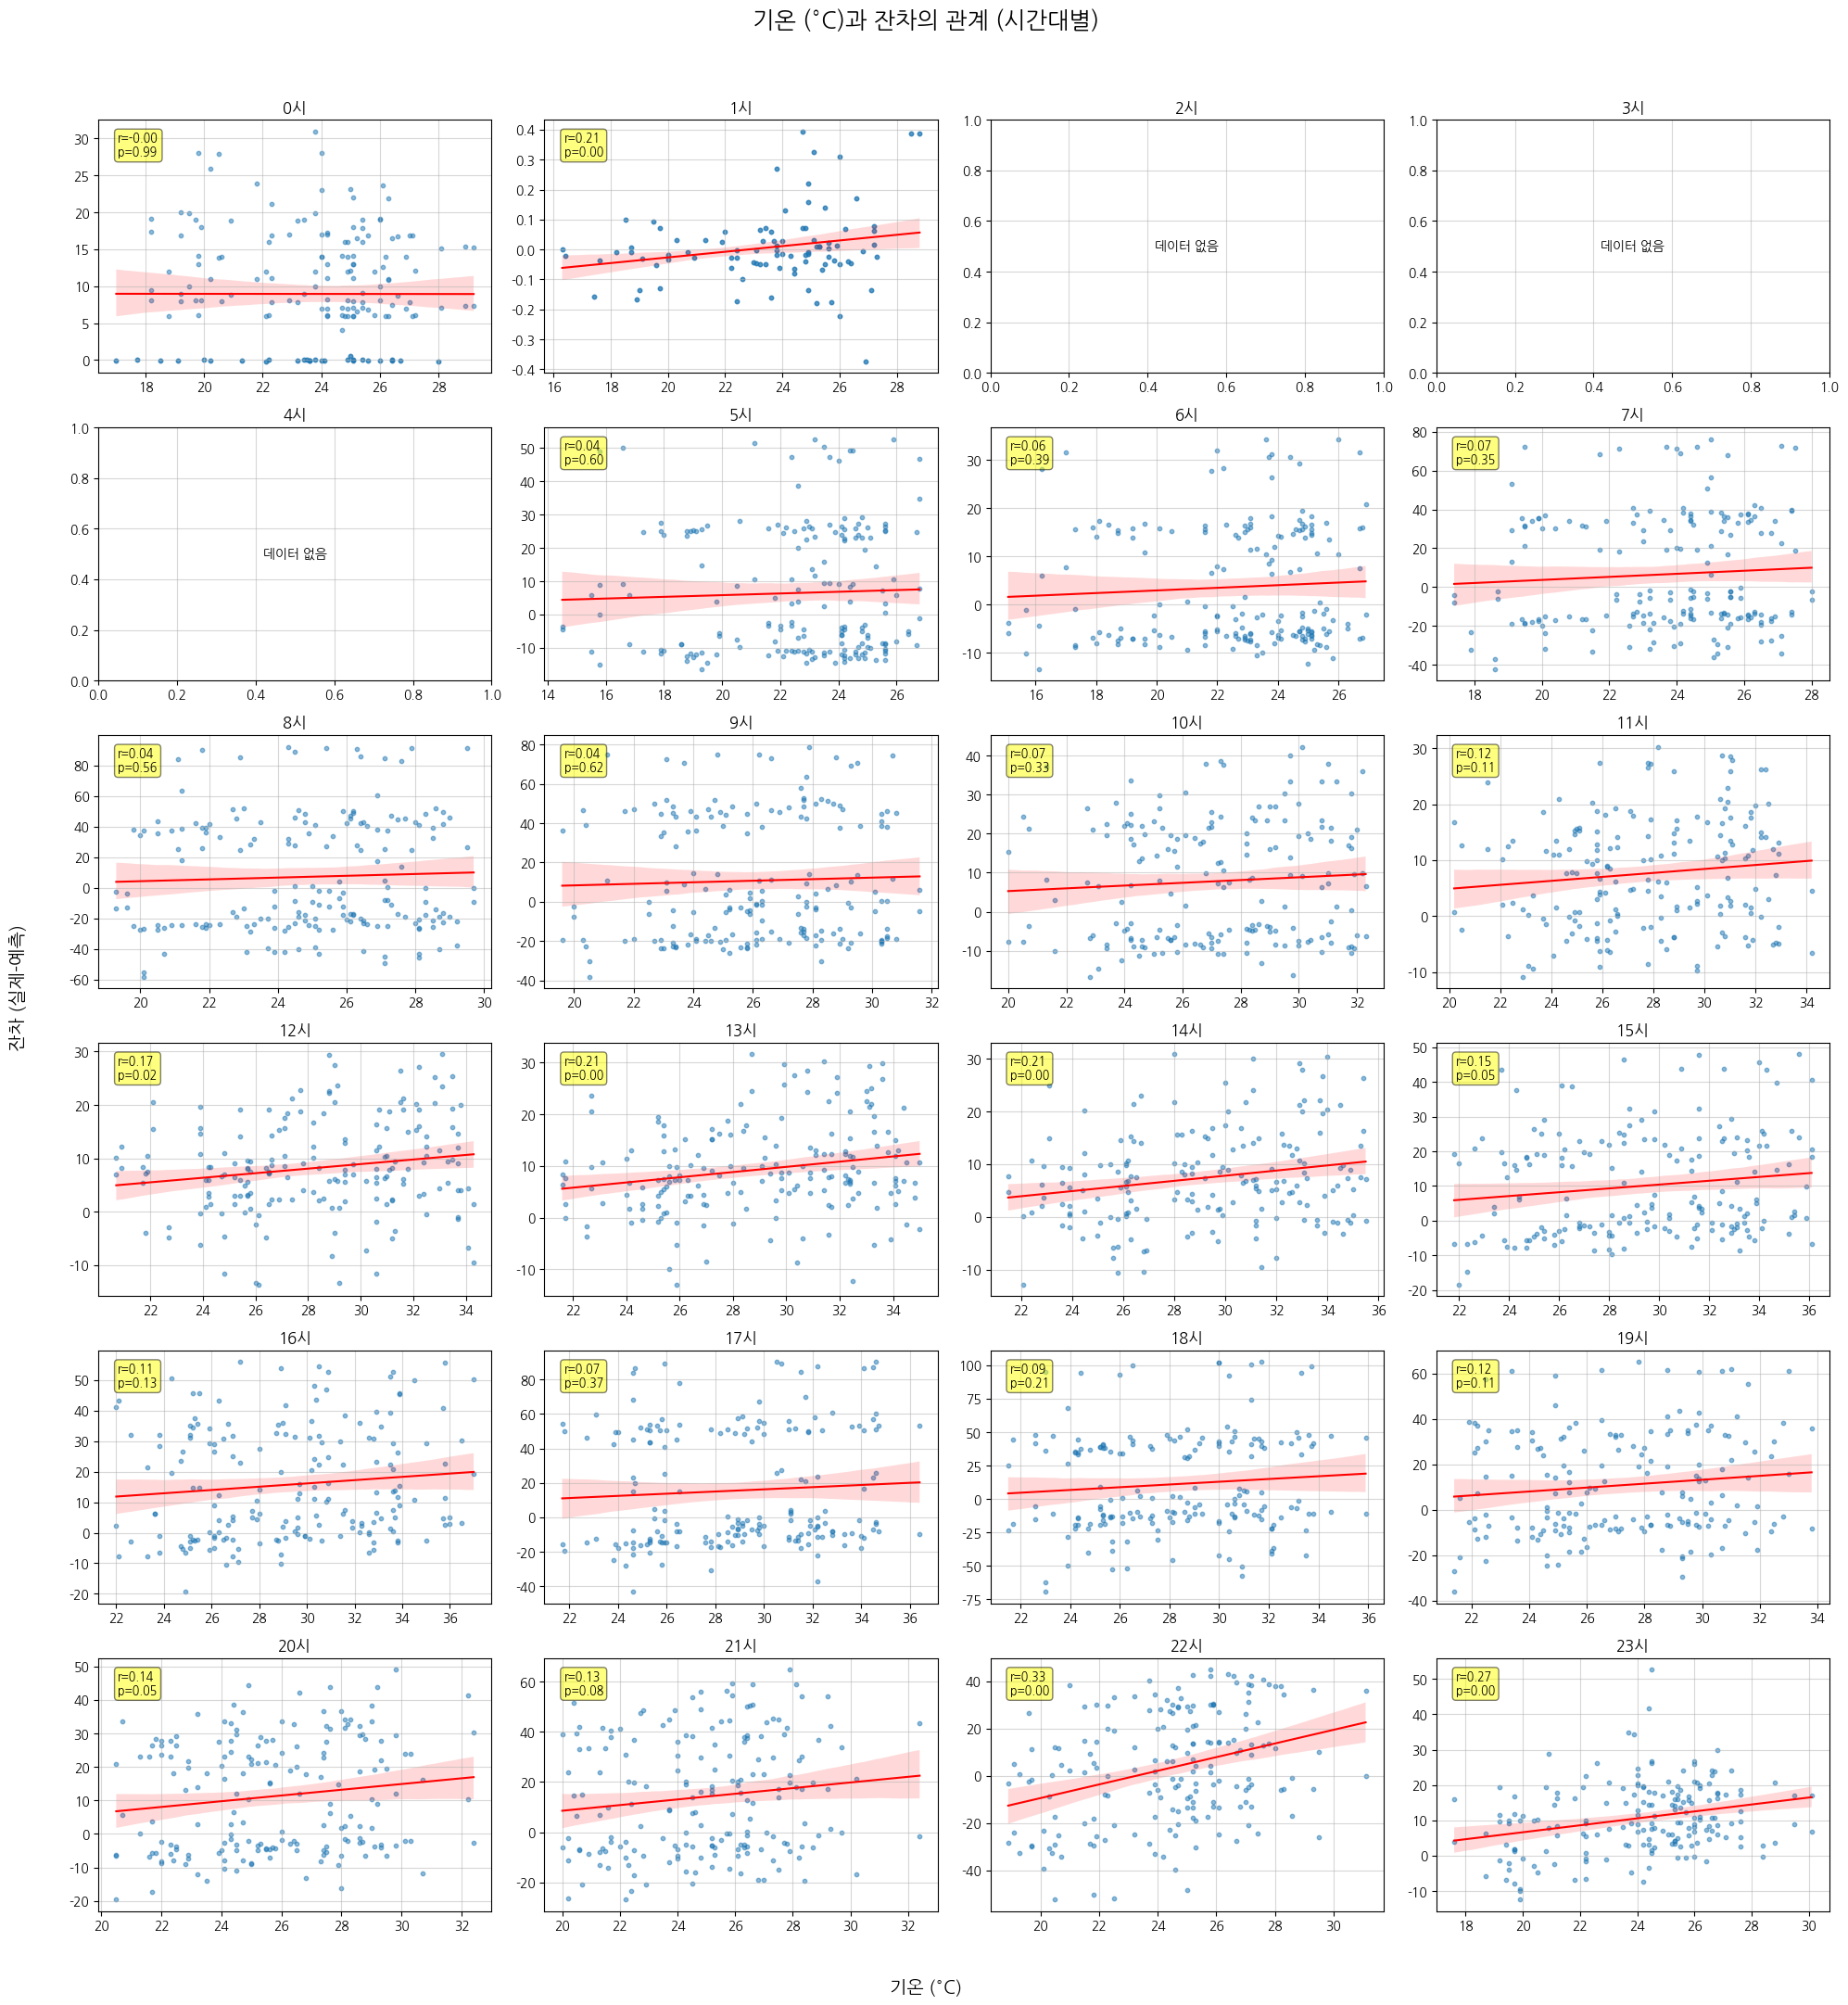


Processing Weather Variable: 습도 (%)
  ✅ 그래프 저장 완료: ../result/scatter_residual_vs_hm_by_all_hours.png


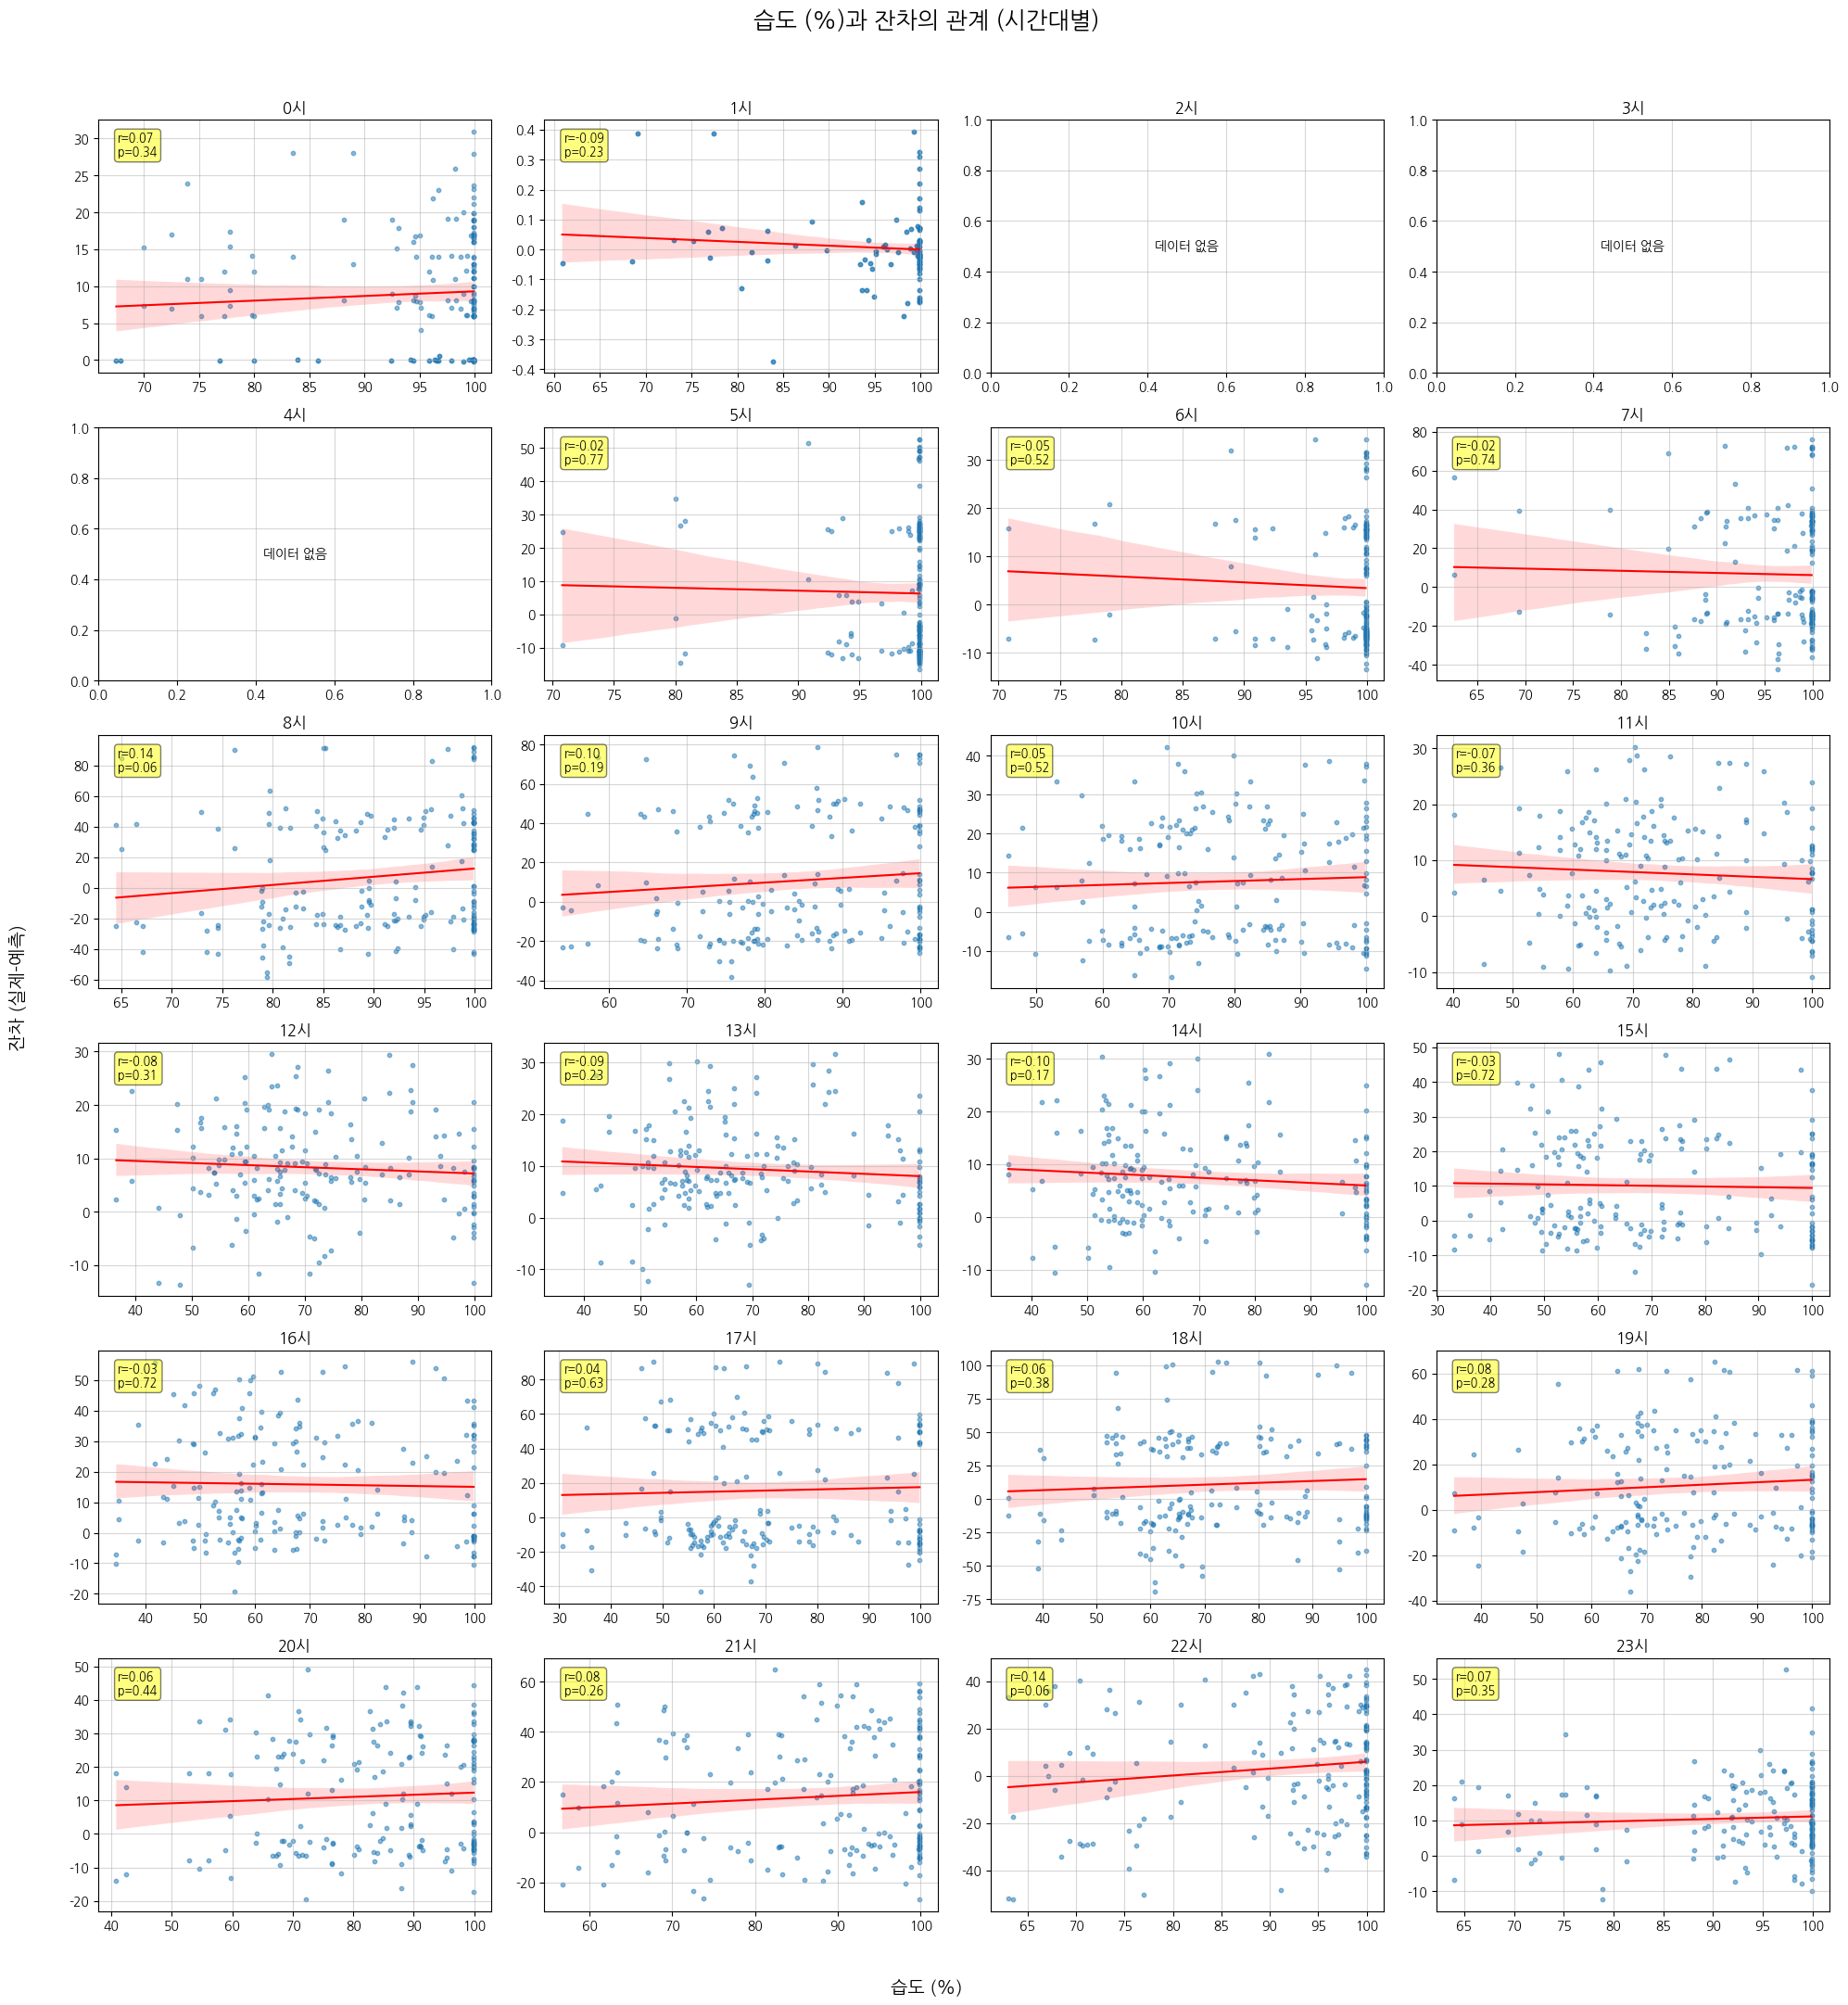


Processing Weather Variable: 풍속 (m/s)
  ✅ 그래프 저장 완료: ../result/scatter_residual_vs_ws_by_all_hours.png


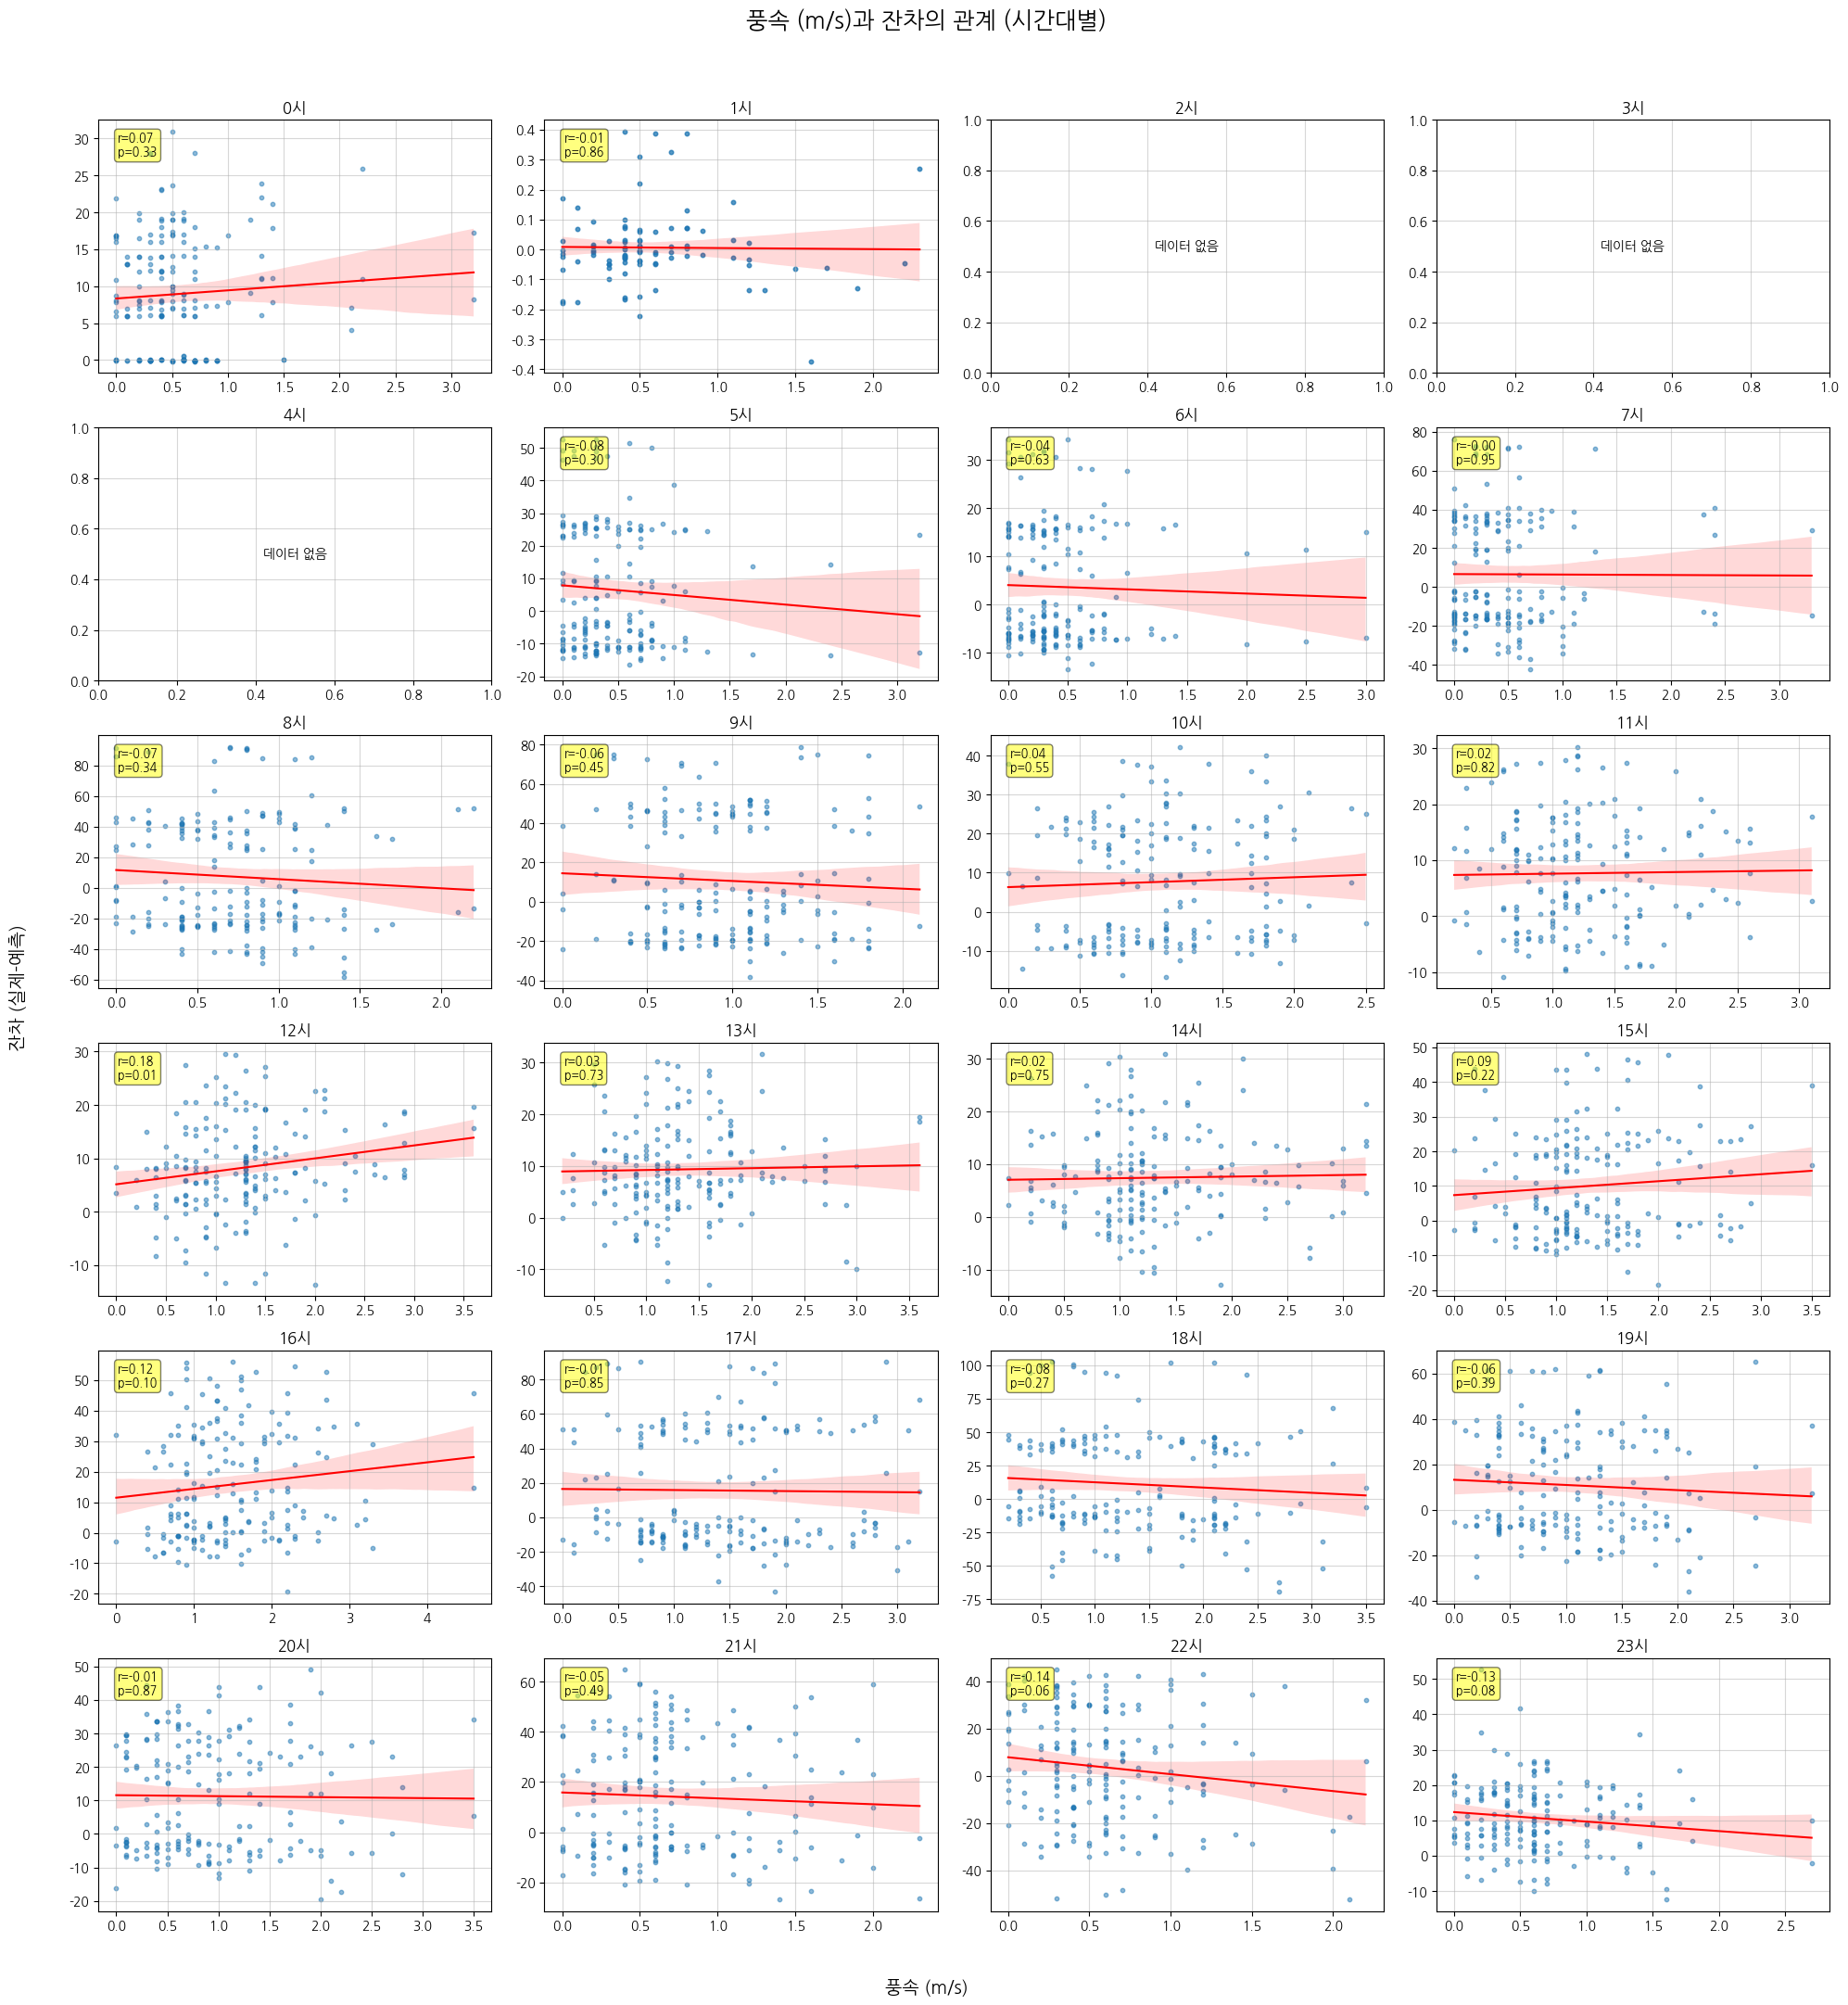


Processing Weather Variable: 시간강수량 (mm)
  ✅ 그래프 저장 완료: ../result/scatter_residual_vs_rn_hr1_by_all_hours.png


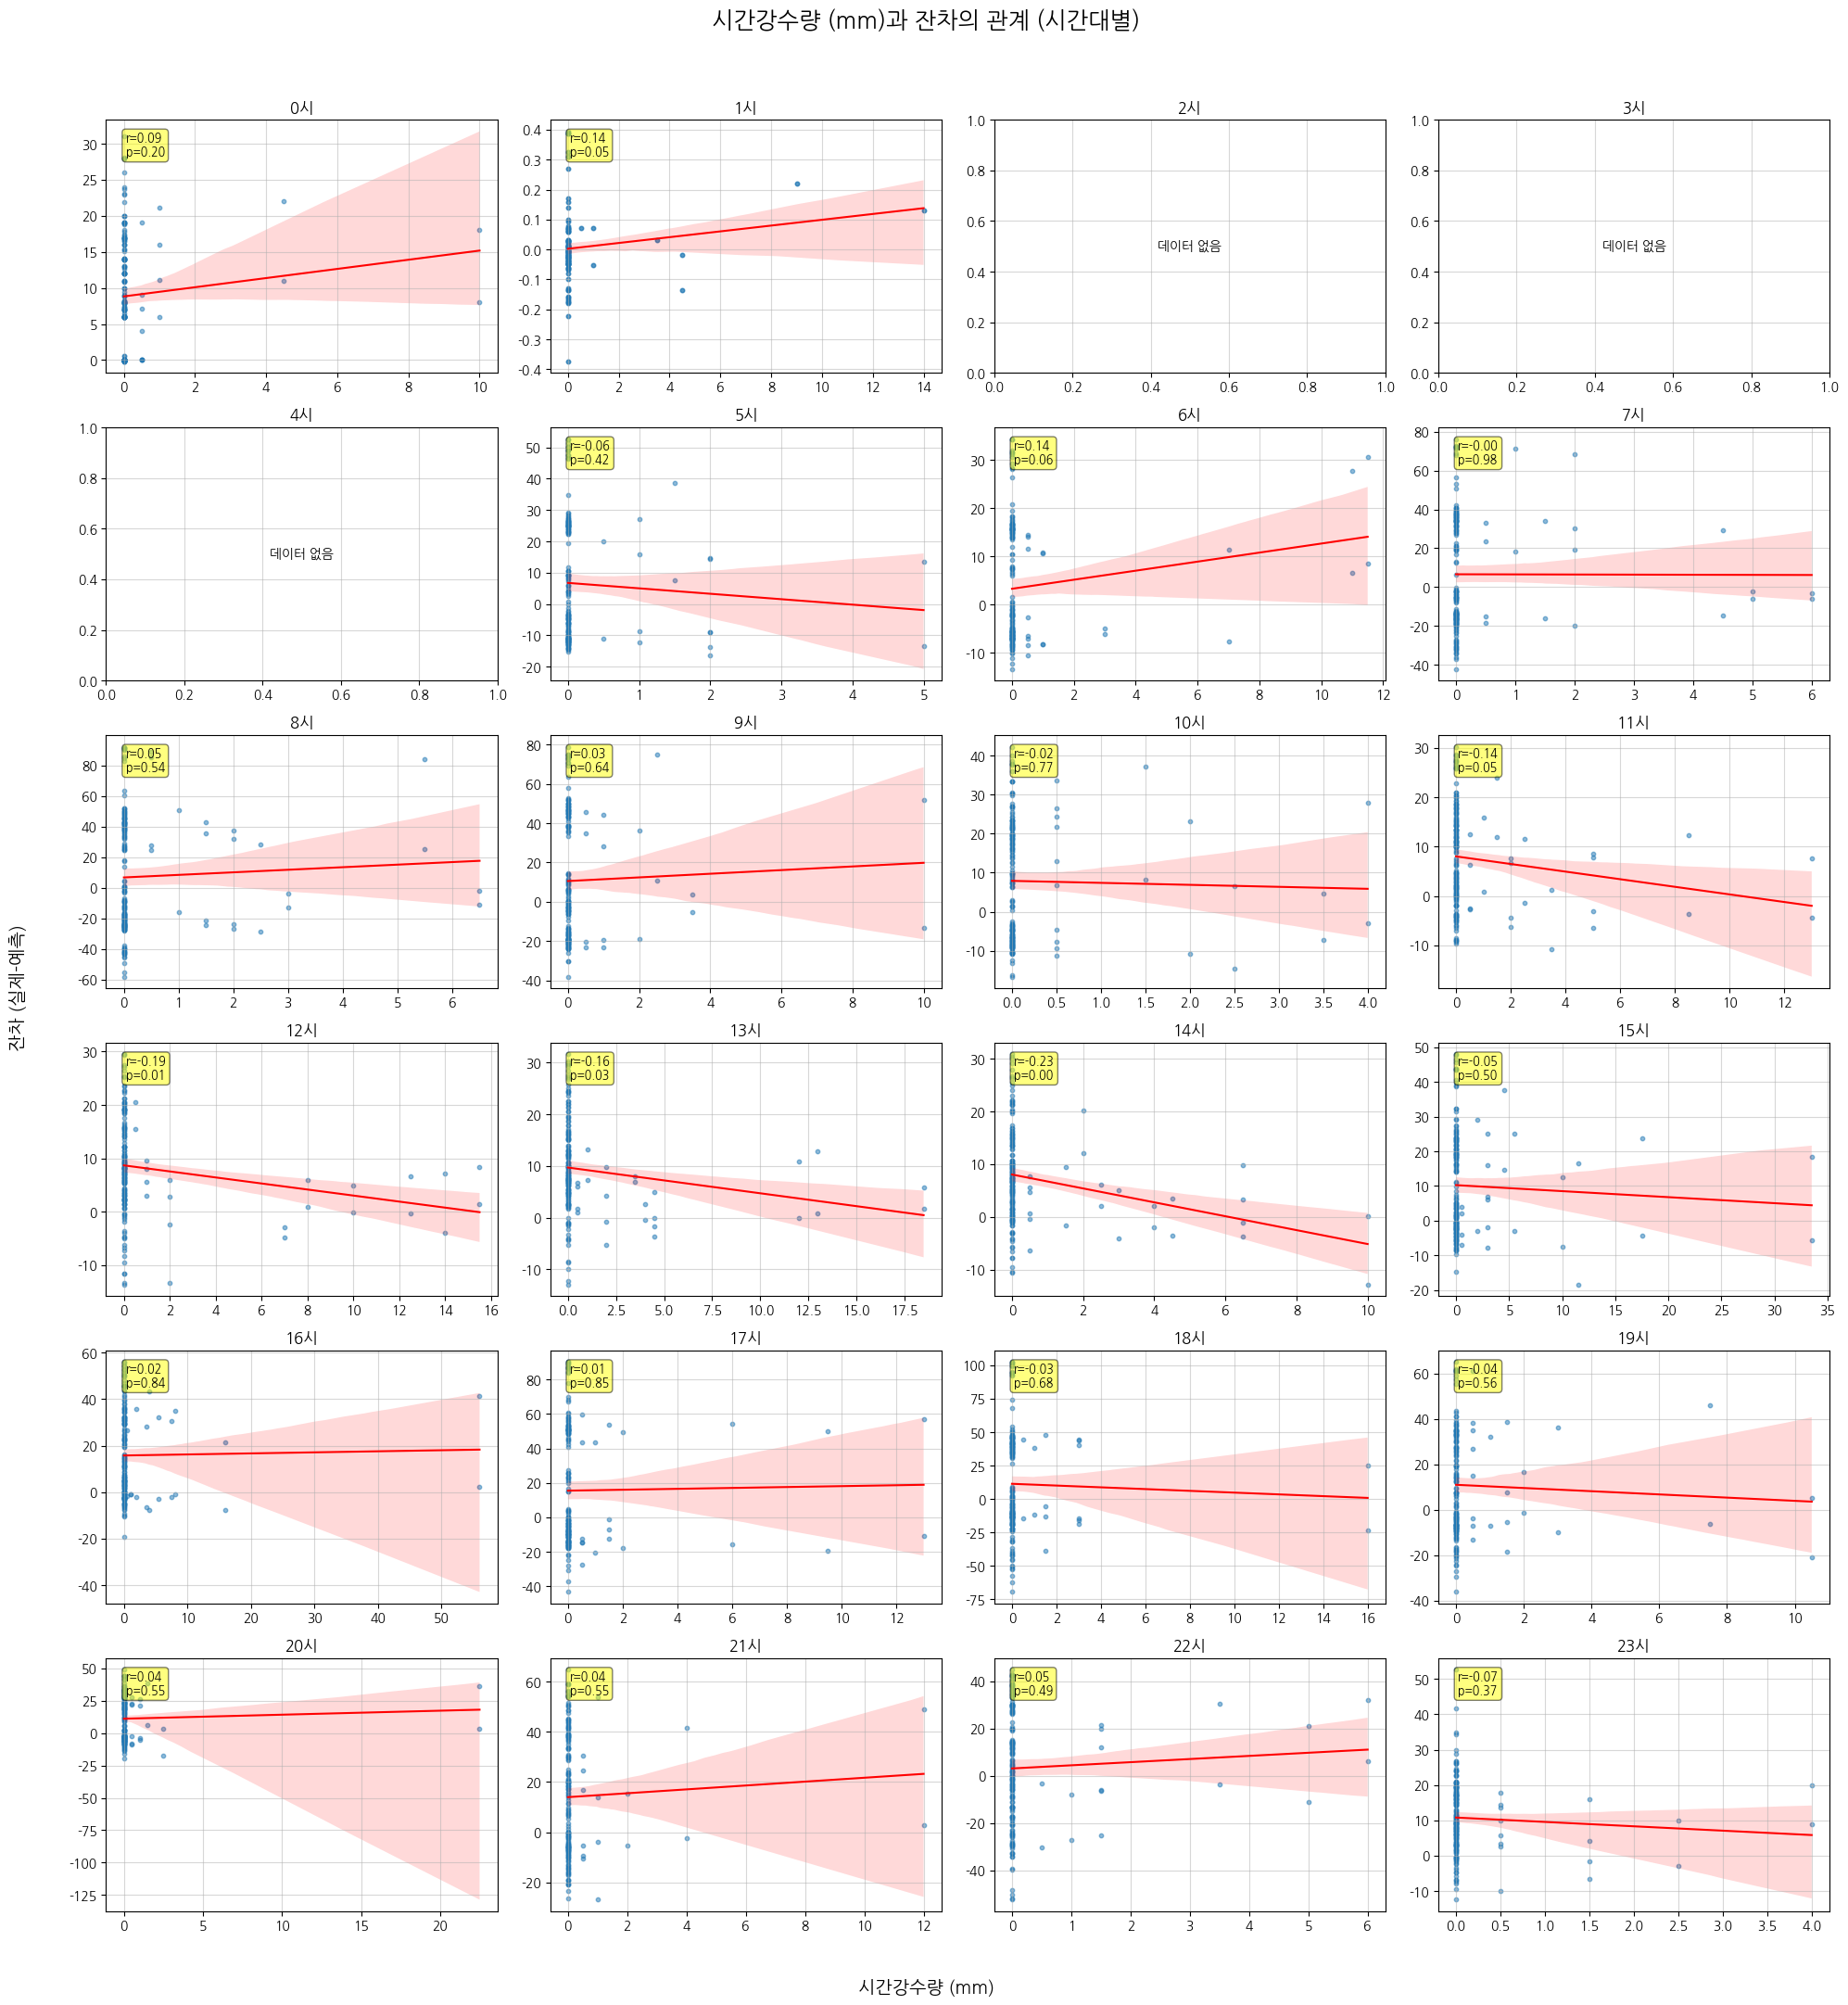


Processing Weather Variable: 일사량 (MJ/m²)
  ✅ 그래프 저장 완료: ../result/scatter_residual_vs_si_by_all_hours.png


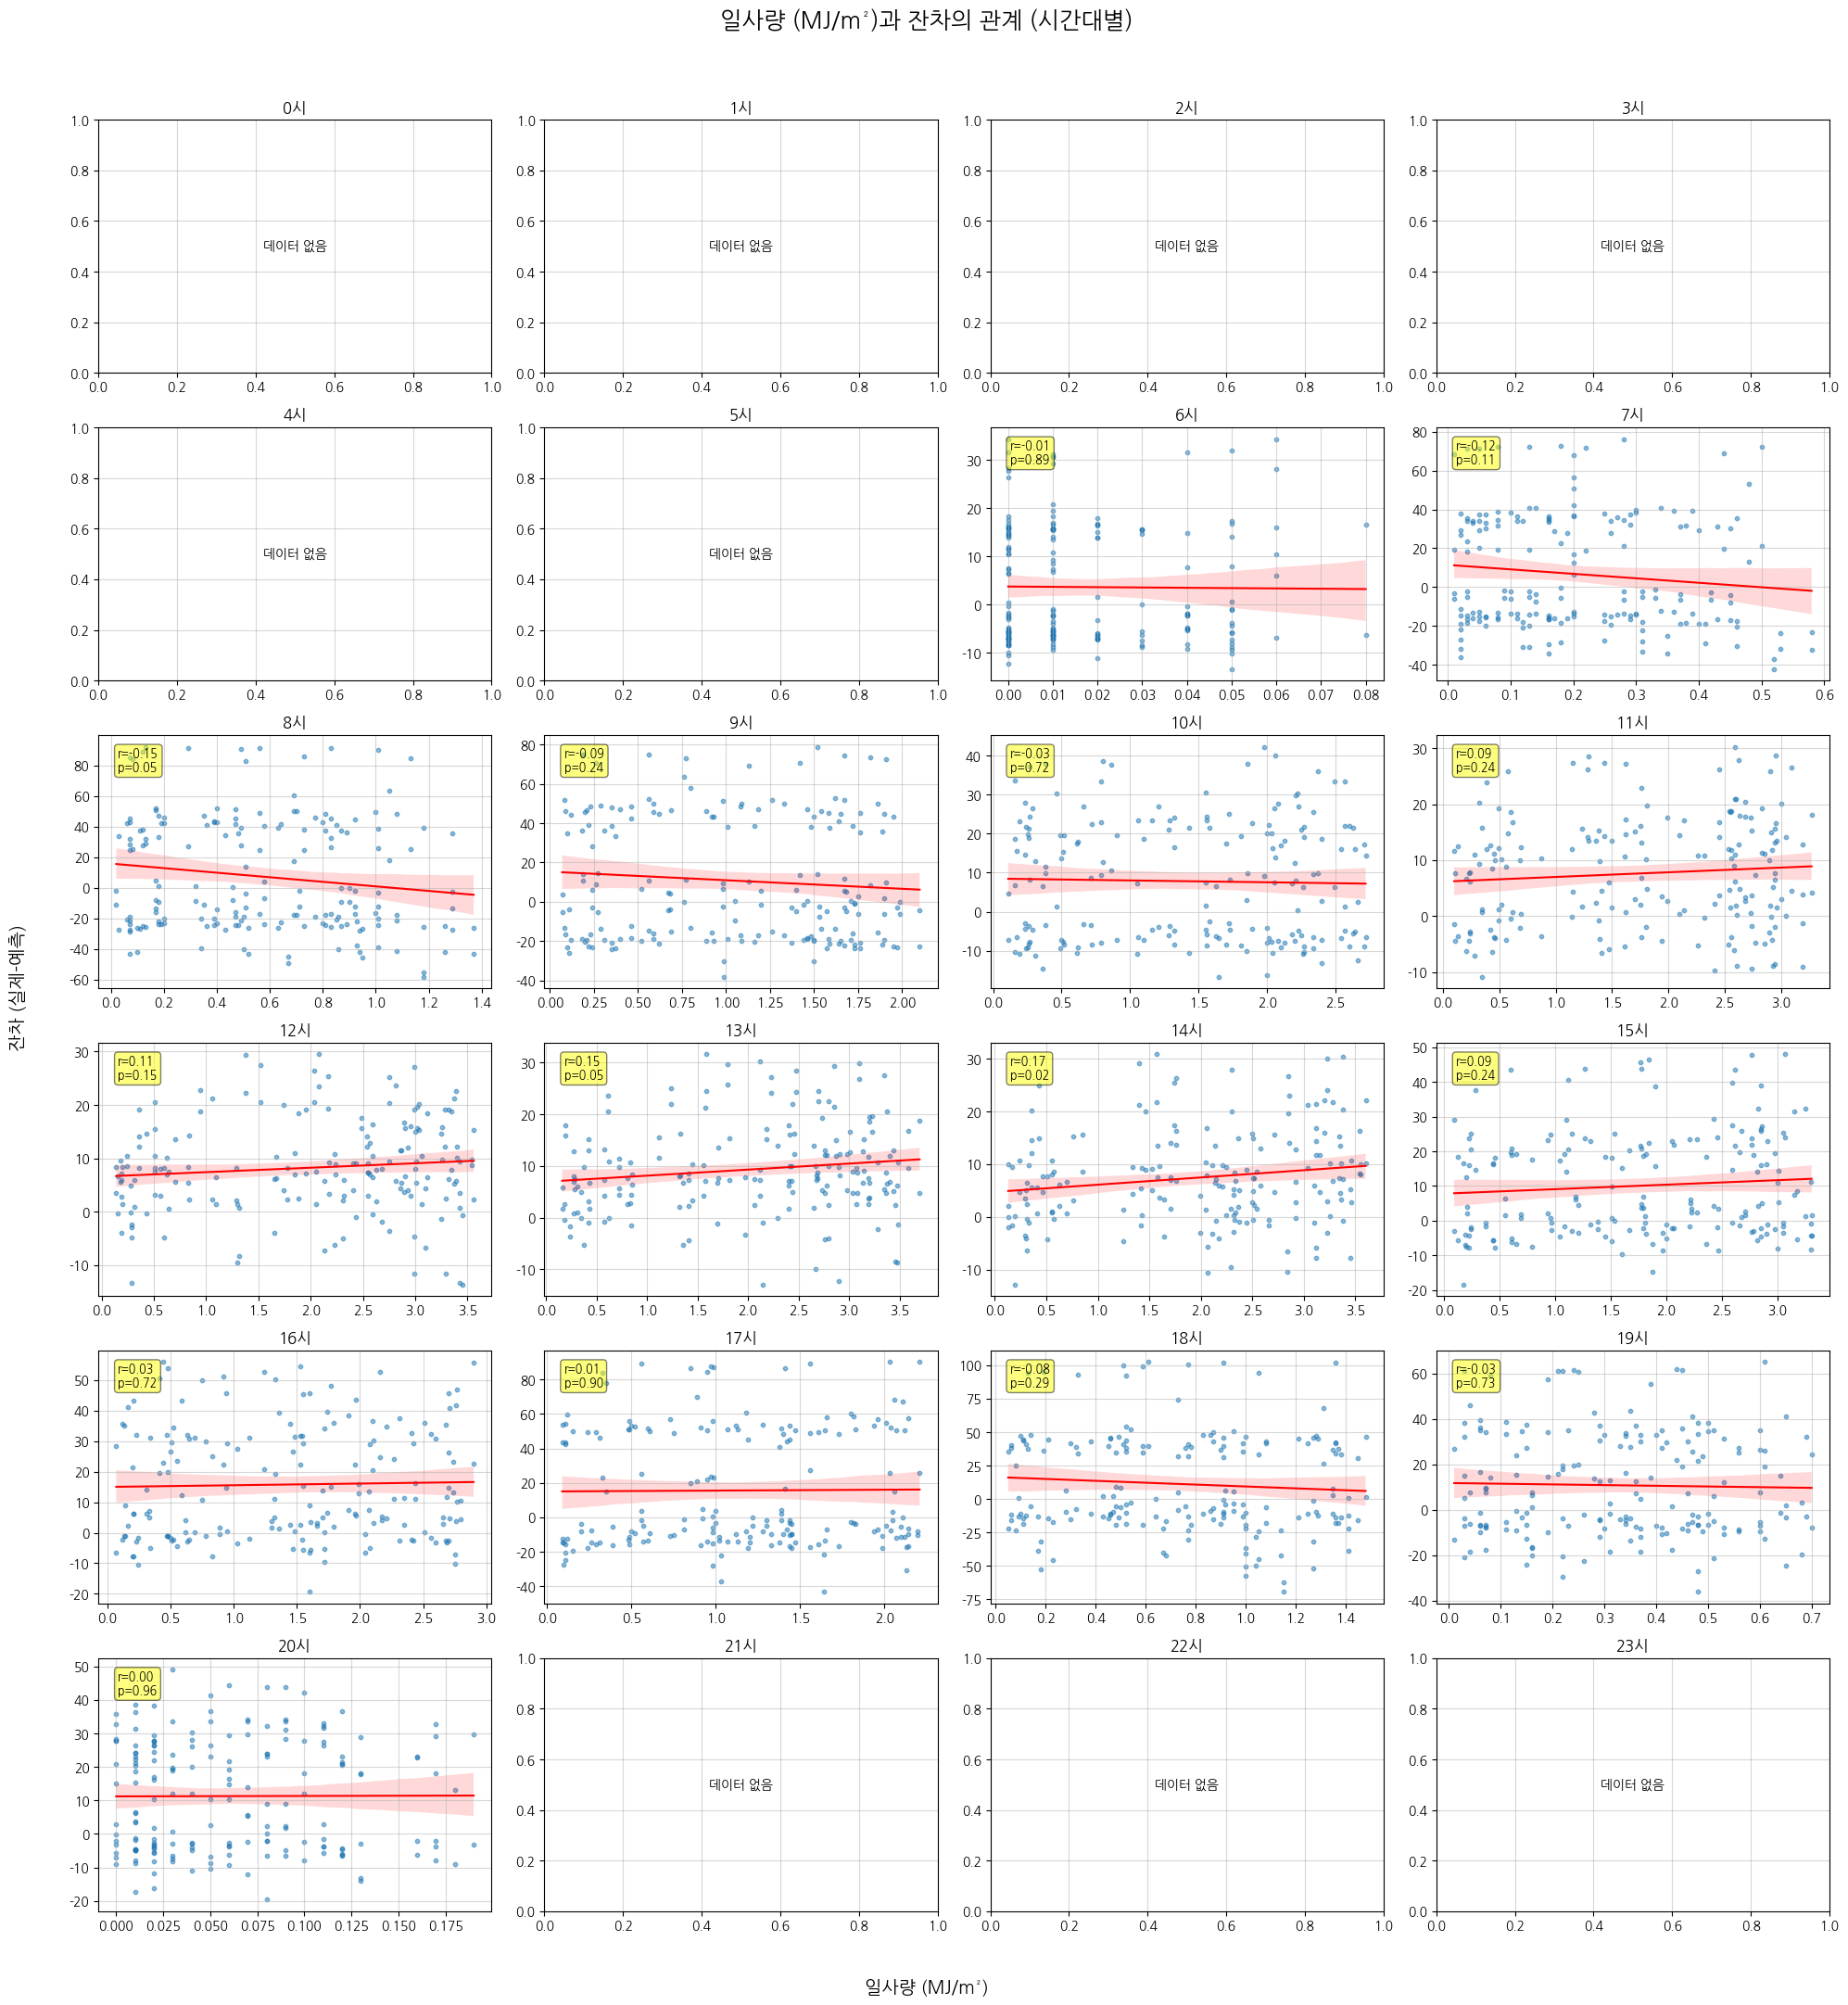


Processing Weather Variable: 체감온도 (°C)
  ✅ 그래프 저장 완료: ../result/scatter_residual_vs_ta_chi_by_all_hours.png


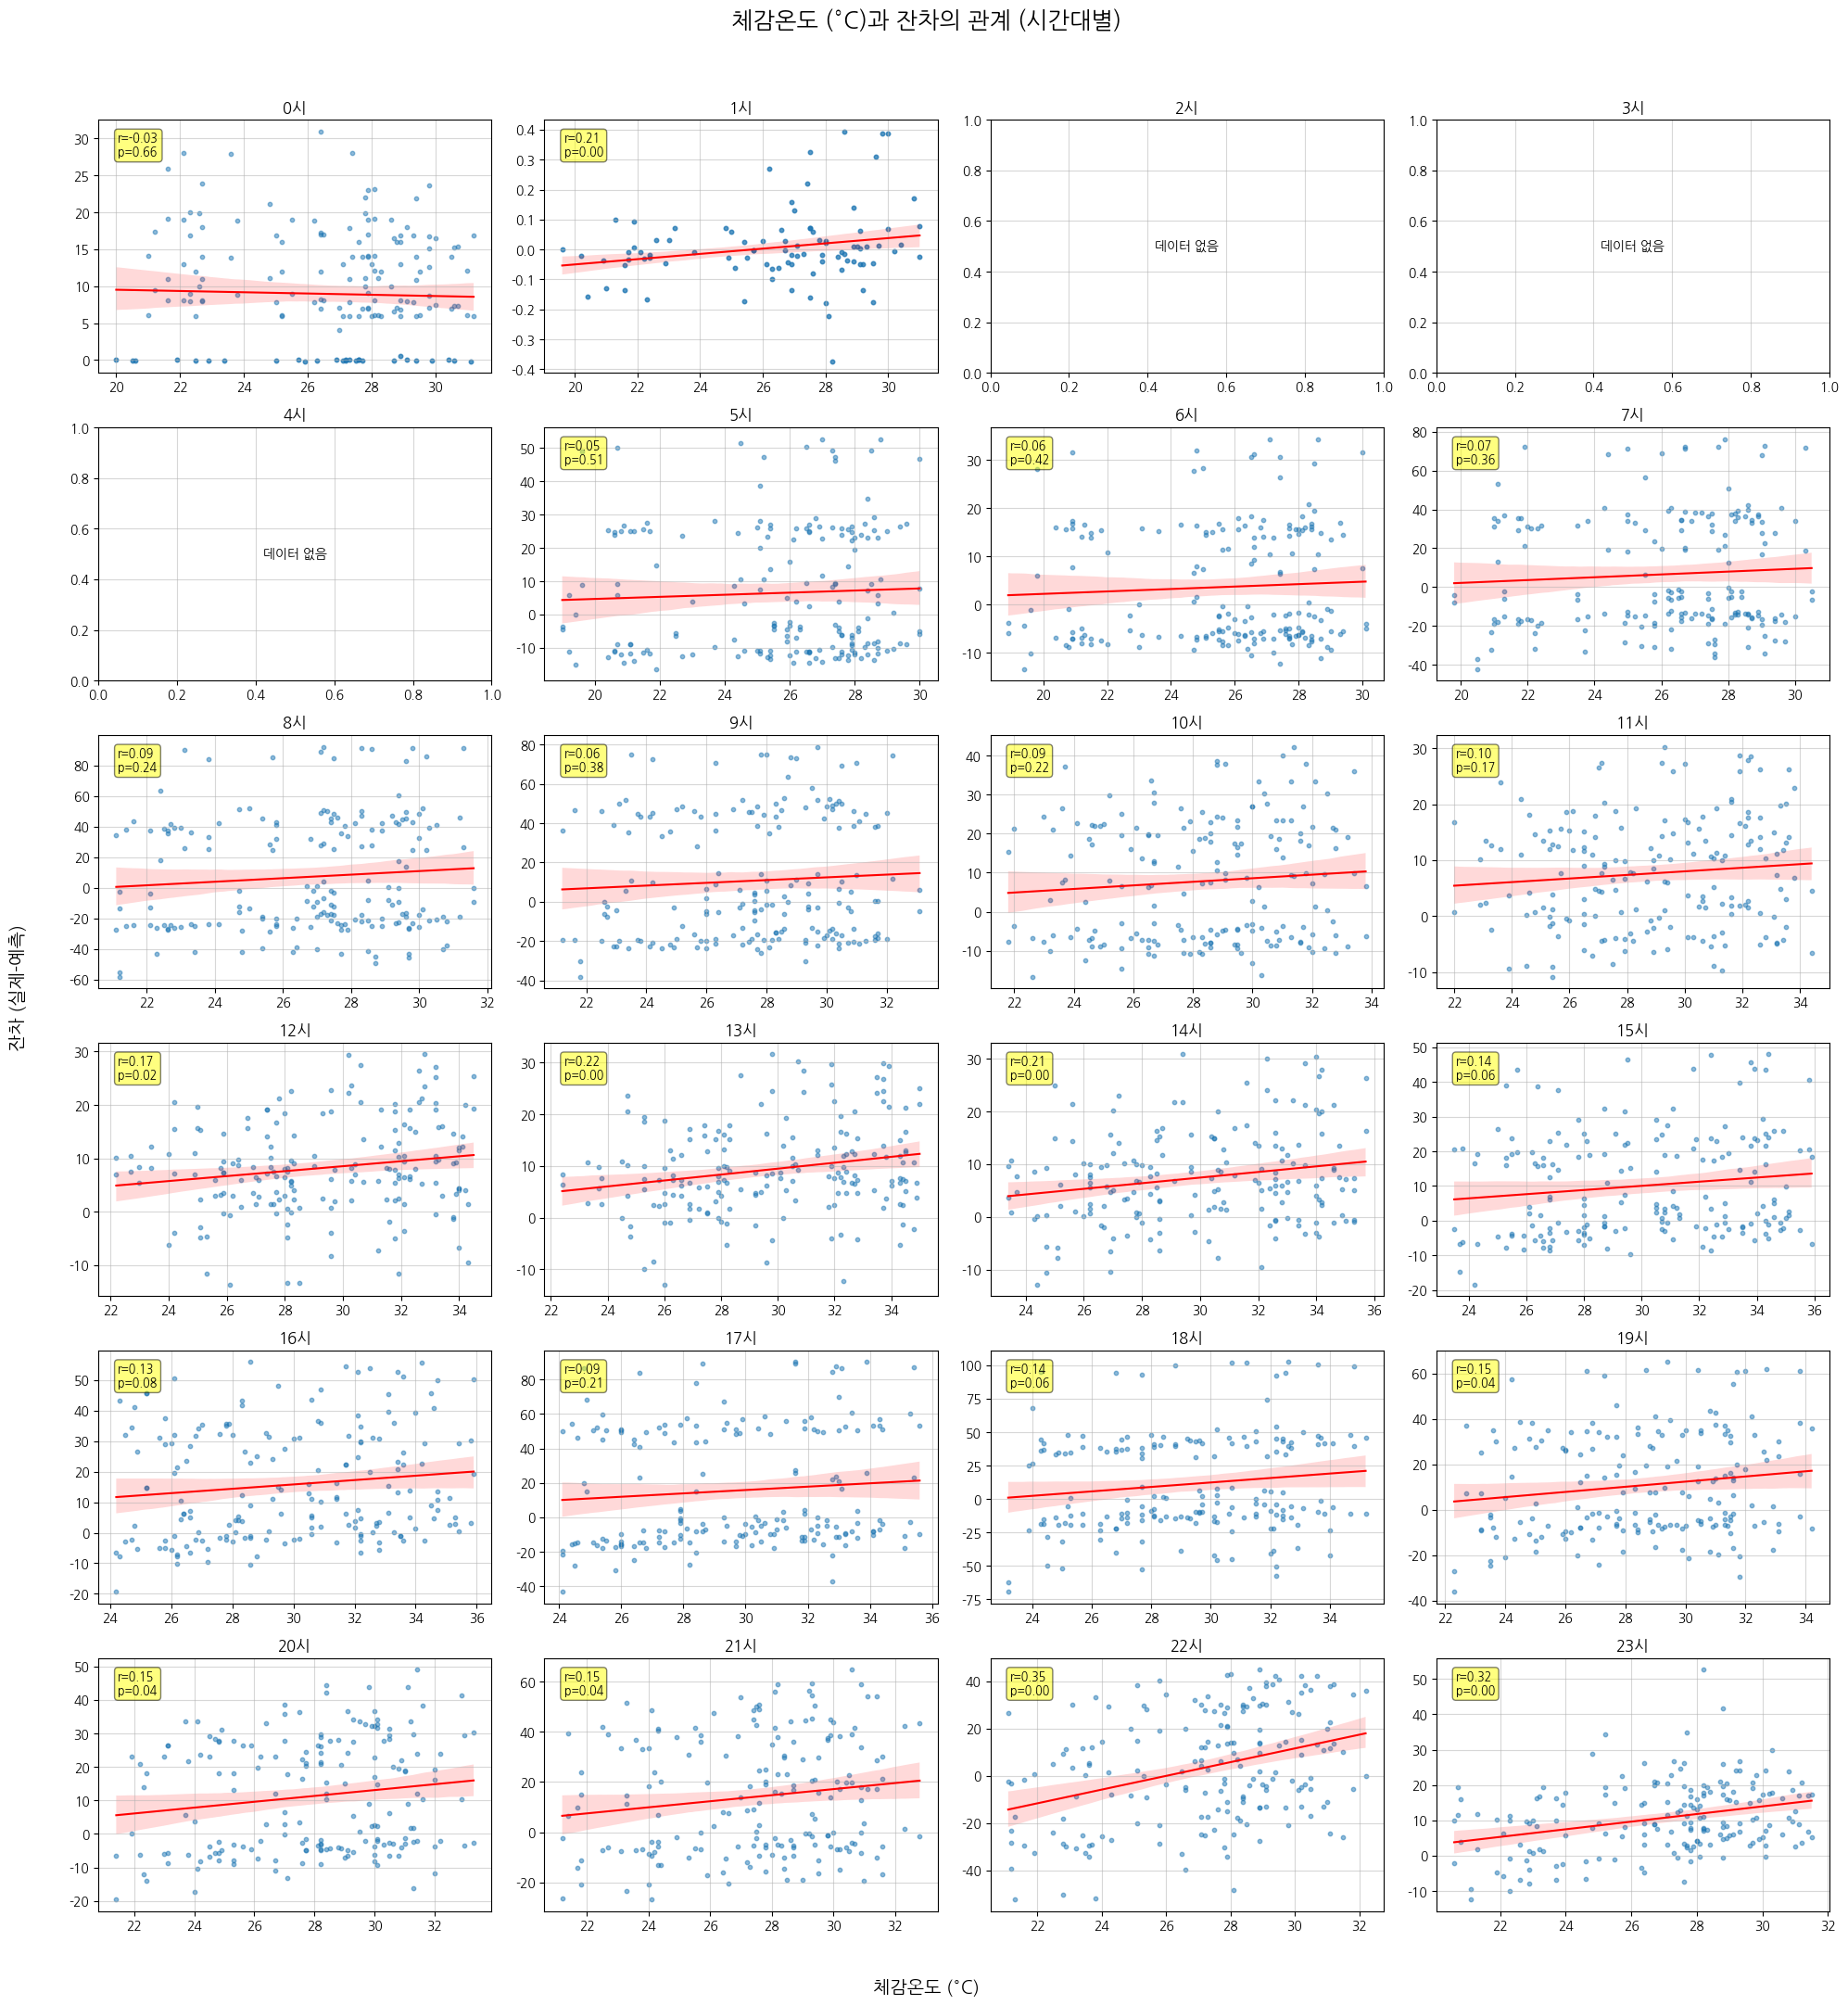


🎉 모든 분석이 완료되었습니다.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def load_data():
    """데이터 로드 및 전처리"""
    print("📊 데이터 로드 중...")
    data_path = r'C:\Users\COEL_03\Desktop\CLIMAX-main\projet\데이터\train_subway23.csv'
    if not os.path.exists(data_path):
        print(f"❌ 데이터 파일을 찾을 수 없습니다: {data_path}")
        return None
    
    df = pd.read_csv(data_path, encoding='cp949')
    column_mapping = {
        'train_subway23.tm': 'tm', 'train_subway23.station_name': 'station_name',
        'train_subway23.ta': 'ta', 'train_subway23.wd': 'wd', 'train_subway23.ws': 'ws',
        'train_subway23.rn_day': 'rn_day', 'train_subway23.rn_hr1': 'rn_hr1',
        'train_subway23.hm': 'hm', 'train_subway23.si': 'si',
        'train_subway23.ta_chi': 'ta_chi', 'train_subway23.congestion': 'congestion'
    }
    df = df.rename(columns=lambda c: column_mapping.get(c, c))
    
    df['datetime'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    df['date'] = pd.to_datetime(df['datetime'].dt.date)
    df['m_hr1'] = df['datetime'].dt.hour
    df['month'] = df['datetime'].dt.month
    
    selected_station = '강남'
    summer_df = df[(df['month'].isin([6,7,8])) & (df['station_name'] == selected_station)].copy()
    print(f"✅ 여름 강남역 데이터: {len(summer_df):,}개")

    pred_path = r"../pred_result_hour_only.csv"
    if not os.path.exists(pred_path):
        print(f"❌ 예측 결과 파일({pred_path})을 찾을 수 없습니다.")
        return summer_df

    df_pred = pd.read_csv(pred_path)
    summer_df = summer_df.reset_index(drop=True)
    df_pred = df_pred.reset_index(drop=True)

    min_len = min(len(summer_df), len(df_pred))
    summer_df = summer_df.iloc[:min_len]
    df_pred = df_pred.iloc[:min_len]

    summer_df['predicted_congestion'] = df_pred['congestion2']
    summer_df['residual'] = summer_df['congestion'] - summer_df['predicted_congestion']
    print("✅ 잔차(residual) 컬럼 생성 완료")
    
    weather_cols = ['rn_day', 'ws', 'rn_hr1', 'hm', 'si', 'ta_chi', 'ta', 'wd']
    for col in weather_cols:
        if col in summer_df.columns:
            summer_df[col] = summer_df[col].replace([-99, -9.9], np.nan)
    
    return summer_df

def create_daily_ts_by_hour_plots(df):
    """
    각 기상 변수별로 Figure를 생성하고, 그 안에 24시간별 Subplot(시계열)을 만듭니다.
    """
    print("\n📈 시간대별 일일 기상-잔차 시계열 플롯 생성 시작...")
    
    weather_vars = {
        'ta': '기온 (°C)', 'hm': '습도 (%)', 'ws': '풍속 (m/s)',
        'rn_hr1': '시간강수량 (mm)', 'si': '일사량 (MJ/m²)', 'ta_chi': '체감온도 (°C)'
    }
    available_weather_vars = {k: v for k, v in weather_vars.items() if k in df.columns}
    hours_to_analyze = range(24)

    for var, var_name in available_weather_vars.items():
        print(f"\nProcessing Weather Variable: {var_name}")
        
        # 기상 변수 하나당 Figure 하나 생성
        n_cols = 4
        n_rows = 6
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 20), sharex=True)
        fig.suptitle(f'일별 {var_name}과 잔차 추이 (시간대별)', fontsize=20, fontweight='bold')
        axes = axes.flatten()

        for i, hour in enumerate(hours_to_analyze):
            ax = axes[i]
            hour_data = df[df['m_hr1'] == hour].copy()
            
            if hour_data.empty:
                ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center')
                ax.set_title(f'{hour}시', fontsize=12, fontweight='bold')
                continue

            # 이중 Y축 설정
            ax2 = ax.twinx()

            # 기상 변수 플롯 (왼쪽 Y축)
            line1, = ax.plot(hour_data['date'], hour_data[var], color='blue', alpha=0.8, label=var_name)
            ax.tick_params(axis='y', labelcolor='blue', labelsize=8)
            
            # 잔차 플롯 (오른쪽 Y축)
            line2, = ax2.plot(hour_data['date'], hour_data['residual'], color='red', alpha=0.7, linestyle='--', label='잔차')
            ax2.tick_params(axis='y', labelcolor='red', labelsize=8)
            
            ax.set_title(f'{hour}시', fontsize=12, fontweight='bold')
            ax.grid(True, linestyle=':', alpha=0.6)
            
            # X축 날짜 포맷은 마지막 행에만 적용
            if i >= (n_rows - 1) * n_cols:
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
                ax.tick_params(axis='x', rotation=45, labelsize=8)
            else:
                plt.setp(ax.get_xticklabels(), visible=False)

        # 공통 Y축 라벨
        fig.text(0.01, 0.5, var_name, ha='center', va='center', rotation='vertical', fontsize=14, color='blue')
        fig.text(0.99, 0.5, '잔차 (실제-예측)', ha='center', va='center', rotation='vertical', fontsize=14, color='red')
            
        plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])

        # 파일 저장 및 출력
        save_path = f'../result/daily_ts_residual_vs_{var}_by_hour.png'
        plt.savefig(save_path, dpi=300)
        print(f"  ✅ 그래프 저장 완료: {save_path}")
        plt.show()

def main():
    """메인 실행 함수"""
    df = load_data()
    if df is not None:
        create_daily_ts_by_hour_plots(df)
        print("\n🎉 모든 분석이 완료되었습니다.")

if __name__ == "__main__":
    main()